In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

import warnings
warnings.filterwarnings("ignore")

from scipy.stats import chi2_contingency
import os 
import itertools

from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.model_selection import StratifiedKFold, train_test_split, GridSearchCV, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.metrics import f1_score, precision_score, recall_score
from sklearn.metrics import classification_report, make_scorer, confusion_matrix, roc_auc_score

In [3]:
train = pd.read_csv(r"datasets/train.csv")
train['main_activity'].replace({"Widlife Tourism": "Wildlife Tourism"}, inplace=True)

In [4]:
train.describe().T

,count,mean,std,min,25%,50%,75%,max
total_female,18504.0,0.936230,1.215582,0.0,0.0,1.0,1.0,49.0
total_male,18500.0,0.998757,1.173177,0.0,1.0,1.0,1.0,58.0
night_mainland,18506.0,9.141576,14.127449,0.0,3.0,6.0,11.0,365.0
night_zanzibar,18506.0,2.493516,5.275156,0.0,0.0,0.0,4.0,240.0


In [5]:
num_features = [col for col in train.select_dtypes(np.number)]
for f in num_features:
    train.loc[:, f] = train[f].fillna(lambda x: np.median(x))
    train["log_{}".format(f)] = (train[f] - train[f].min() + 1).transform(np.log)
        
cat_features = [
    x for x in train.select_dtypes(np.object).columns if x not in ("Tour_ID", "cost_category")
]

for feat in cat_features:
    train.loc[:, feat] = train[feat].astype(str).fillna("None")

combination = itertools.combinations(cat_features, 2)
for cat1, cat2 in combination:
    train[cat1 + "_" + cat2] = train[cat1].astype(str) + train[cat2].astype(str)

features = num_features.values + cat_features.values
for feat in features:
    num_pipeline=Pipeline([
        ("imputer", KNNImputer(n_neighbors=3)),
        ("scaler", StandardScaler()),
    ])
    
    cat_pipeline=Pipeline([
        ("imputer", SimpleImputer(strategy='most_frequent')),
        ("encoder", OneHotEncoder(sparse_output=False)),
    ])

    text_pipeline=Pipeline([
        ("vectorizer",OneHotEncoder(sparse_output=False)),
    ])

    pipe = ColumnTransformer([
        ("cat", cat_pipeline, cat),
        ("num", num_pipeline, num),
        ("text", text_pipeline, text),
    ])
    
    
    pipe.fit(train[feat])
    
    train.loc[:, feat] = pipe.transform(train[feat])
    

mapping = {
    "Lower Cost": 1,
    "Low Cost" : 2,
    "Normal Cost": 3,
    "High Cost": 4,
    "Higher Cost": 5,
    "Highest Cost": 6
} 

train.loc[:, "cost_category"] = train['cost_category'].map(mapping)

TypeError: '<=' not supported between instances of 'float' and 'function'

In [ ]:
train.head()

In [ ]:
def chi(data):
    col_drop=[]
    
    for col in data.columns:
        
        ct=pd.crosstab(y, data[col])
        chi2, p, _, _ =chi2_contingency(ct)
        
        if p >= 0.05:
            col_drop.append(col)
        elif chi2 <= 8000:
            col_drop.append(col)
            
    return col_drop

In [17]:
train.shape

(18506, 158)

In [27]:
X.head()

,country,tour_arrangement,country&age_group,country&travel_with,country&total_female,country&total_male,country&purpose,country&main_activity,country&info_source,country&tour_arrangement,...,package_transport_int&package_guided_tour,package_accomodation&package_food,package_accomodation&package_transport_tz,package_accomodation&package_sightseeing,package_accomodation&package_guided_tour,package_accomodation&package_insurance,package_accomodation&first_trip_tz,package_food&package_transport_tz,package_food&package_sightseeing,package_food&package_guided_tour
0,54,1,ITALY45-64,ITALYWith Children,ITALY0.0,ITALY2.0,ITALYVisiting Friends and Relatives,ITALYBeach Tourism,"ITALYFriends, relatives",ITALYPackage Tour,...,YesNo,YesYes,YesYes,YesNo,YesNo,YesNo,YesYes,YesYes,YesNo,YesNo
1,123,1,UNITED KINGDOM25-44,UNITED KINGDOMWith Spouse,UNITED KINGDOM1.0,UNITED KINGDOM1.0,UNITED KINGDOMLeisure and Holidays,UNITED KINGDOMWildlife Tourism,"UNITED KINGDOMTravel agent, tour operator",UNITED KINGDOMPackage Tour,...,YesNo,YesYes,YesYes,YesNo,YesNo,YesNo,YesYes,YesYes,YesNo,YesNo
2,124,1,UNITED STATES OF AMERICA65+,UNITED STATES OF AMERICAWith Spouse,UNITED STATES OF AMERICA1.0,UNITED STATES OF AMERICA1.0,UNITED STATES OF AMERICALeisure and Holidays,UNITED STATES OF AMERICAWildlife Tourism,"UNITED STATES OF AMERICATravel agent, tour ope...",UNITED STATES OF AMERICAPackage Tour,...,YesYes,YesYes,YesYes,YesYes,YesYes,YesNo,YesYes,YesYes,YesYes,YesYes
3,96,0,RWANDA25-44,RWANDAWith Spouse and Children,RWANDA3.0,RWANDA1.0,RWANDALeisure and Holidays,RWANDABeach Tourism,"RWANDARadio, TV, Web",RWANDAIndependent,...,NoNo,NoNo,NoNo,NoNo,NoNo,NoNo,NoNo,NoNo,NoNo,NoNo
4,124,1,UNITED STATES OF AMERICA45-64,UNITED STATES OF AMERICAAlone,UNITED STATES OF AMERICA0.0,UNITED STATES OF AMERICA1.0,UNITED STATES OF AMERICALeisure and Holidays,UNITED STATES OF AMERICAWildlife Tourism,"UNITED STATES OF AMERICATravel agent, tour ope...",UNITED STATES OF AMERICAPackage Tour,...,YesYes,YesYes,YesYes,YesNo,YesYes,YesYes,YesYes,YesYes,YesNo,YesYes


In [28]:
X = train.drop('cost_category', axis=1)
y = train['cost_category']

col_drop = chi(train)
train.drop(col_drop, axis=1, inplace=True)

In [19]:
col_drop

['Tour_ID',
 'age_group',
 'travel_with',
 'total_female',
 'total_male',
 'purpose',
 'main_activity',
 'info_source',
 'package_transport_int',
 'package_accomodation',
 'package_food',
 'package_transport_tz',
 'package_sightseeing',
 'package_guided_tour',
 'package_insurance',
 'night_mainland',
 'night_zanzibar',
 'first_trip_tz',
 'log_night_zanzibar',
 'age_group&travel_with',
 'age_group&total_female',
 'age_group&total_male',
 'age_group&main_activity',
 'age_group&info_source',
 'age_group&package_transport_int',
 'age_group&package_transport_tz',
 'age_group&package_sightseeing',
 'age_group&package_guided_tour',
 'age_group&package_insurance',
 'age_group&first_trip_tz',
 'travel_with&total_female',
 'travel_with&total_male',
 'travel_with&info_source',
 'travel_with&package_insurance',
 'travel_with&first_trip_tz',
 'total_female&total_male',
 'total_female&main_activity',
 'total_female&info_source',
 'total_female&package_sightseeing',
 'total_female&package_guided_tour

In [31]:
from sklearn.pipeline import Pipeline, FeatureUnion, make_pipeline
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, MinMaxScaler, OrdinalEncoder, RobustScaler
from sklearn.compose import ColumnTransformer
cat = []
huge_cat = []
num = [c for c in X.select_dtypes('int','float').columns]
for col in X.select_dtypes(['object', 'category']).columns:
    if col not in ['cost_category']:
        num_values=len(X[col].unique())
        if num_values<=20:
            cat.append(col)
        else:
            huge_cat.append(col)

num_pipeline=Pipeline([
    ("imputer", SimpleImputer(strategy='median')),
    ("scaler", StandardScaler()),
])

cat_pipeline=Pipeline([
    ("imputer", SimpleImputer(strategy='most_frequent')),
    ("encoder", OneHotEncoder(sparse_output=False)),
])

lcat_pipeline=Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ("vectorizer", OrdinalEncoder()),
])

pipe=ColumnTransformer([ 
    ("cat", cat_pipeline, cat),
    ("num", num_pipeline, num),
    ("text", lcat_pipeline, huge_cat),
])


X = pipe.fit_transform(X)

In [32]:
pipe.transformers_

[('cat',
  Pipeline(steps=[('imputer', SimpleImputer(strategy='most_frequent')),
                  ('encoder', OneHotEncoder(sparse_output=False))]),
  ['age_group&tour_arrangement',
   'age_group&package_accomodation',
   'age_group&package_food',
   'travel_with&tour_arrangement',
   'travel_with&package_transport_int',
   'travel_with&package_accomodation',
   'travel_with&package_food',
   'travel_with&package_transport_tz',
   'travel_with&package_sightseeing',
   'travel_with&package_guided_tour',
   'purpose&tour_arrangement',
   'purpose&package_transport_int',
   'purpose&package_accomodation',
   'purpose&package_food',
   'purpose&package_transport_tz',
   'purpose&package_sightseeing',
   'purpose&package_guided_tour',
   'main_activity&tour_arrangement',
   'main_activity&package_transport_int',
   'main_activity&package_accomodation',
   'main_activity&package_food',
   'main_activity&package_transport_tz',
   'info_source&tour_arrangement',
   'info_source&package_accomo

In [18]:
pipe.transformers_[1][1].get_feature_names_out()

array(['country', 'age_group', 'travel_with', 'purpose', 'main_activity',
       'info_source', 'tour_arrangement', 'package_transport_int',
       'package_accomodation', 'package_food', 'package_transport_tz',
       'package_sightseeing', 'package_guided_tour', 'package_insurance',
       'night_mainland', 'night_zanzibar', 'first_trip_tz'], dtype=object)

In [19]:
pd.DataFrame(lr.predict_proba(X_test))

NameError: name 'lr' is not defined

In [23]:
y

Tour_ID
tour_id1hffseyw    4
tour_idnacd7zag    4
tour_id62vz7e71    5
tour_idrc76tzix    1
tour_idn723m0n9    5
                  ..
tour_idmp5ciw50    1
tour_ideq0yncfs    1
tour_idv7pz3vs8    5
tour_idy6ydo00w    5
tour_idceoq9por    2
Name: cost_category, Length: 18506, dtype: int64

In [33]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=123)

In [47]:
le = LabelEncoder()
le = le.fit(y_train)
y_test = le.transform(y_test)

In [25]:
y_train, y_test

(Tour_ID
 tour_id0u4qn158    2
 tour_idcjg4lln7    5
 tour_id41pl8tl1    1
 tour_idptrb9blw    4
 tour_idx6hnuuxq    3
                   ..
 tour_idz2xpvfzt    4
 tour_idka4xccyo    6
 tour_idouxn57sd    4
 tour_idzjpswsam    5
 tour_idem7v1830    1
 Name: cost_category, Length: 14804, dtype: int64,
 Tour_ID
 tour_idzis9fxna    3
 tour_id2q0rudyo    1
 tour_idso00q4tv    3
 tour_idmsp951fh    1
 tour_idimhbkqwc    4
                   ..
 tour_idnvcjoxbb    2
 tour_id60eldjhm    5
 tour_id4toweior    4
 tour_idf32vah57    3
 tour_id54psn7o0    6
 Name: cost_category, Length: 3702, dtype: int64)

In [11]:
folds = StratifiedKFold(n_splits=10, shuffle=True, random_state=123)

for idx, (train, test) in enumerate (folds.split(X, y)):
    X_train, X_test = X[train], X[test]
    y_train, y_test = y[train], y[test]

In [34]:
lr = LogisticRegression(multi_class='multinomial',max_iter=10000,
                        penalty='l2', C= 0.01,
                        solver='lbfgs',
                        random_state=123)

lr.fit(X_train, y_train)

LogisticRegression(C=0.01, max_iter=10000, multi_class='multinomial',
                   random_state=123)

In [35]:
y_pred = lr.predict(X_test)
print(precision_score(y_test, y_pred, zero_division=0, average='weighted'))

0.4856624686431139


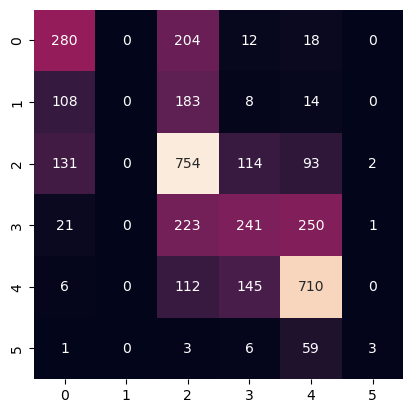

In [36]:
cm = confusion_matrix(y_test, y_pred)

sns.heatmap(cm, square=True, annot=True, fmt='d', cbar=False);

In [37]:
X.shape

(18506, 486)

In [25]:
LogisticRegression??

In [50]:
%%time
lrc = LogisticRegression(random_state=123)

crange = [0.001, 0.01, 0.1, 1.0, 10.0, 100.0]
params = [{'multi_class': ['ovr', 'multinomial'],
          'max_iter': [100, 1000, 10000],
           'C': crange,
          'penalty':['l1', 'l2', 'elasticnet'],
          'solver': ['lbfgs', 'liblinear', 'saga', 'sag', 'newton-cholesky'],
          'l1_ratio': [0.01, 0.2575, 0.505 , 0.7525, 1.0 ]}]

gs = GridSearchCV(estimator=lrc,
                  param_grid=params,
                  scoring='accuracy',
                  cv=3, verbose=2000)

gs.fit(X_train, y_train)

Fitting 3 folds for each of 2700 candidates, totalling 8100 fits
[CV 1/3; 1/2700] START C=0.001, l1_ratio=0.01, max_iter=100, multi_class=ovr, penalty=l1, solver=lbfgs
[CV 1/3; 1/2700] END C=0.001, l1_ratio=0.01, max_iter=100, multi_class=ovr, penalty=l1, solver=lbfgs;, score=nan total time=   0.0s
[CV 2/3; 1/2700] START C=0.001, l1_ratio=0.01, max_iter=100, multi_class=ovr, penalty=l1, solver=lbfgs
[CV 2/3; 1/2700] END C=0.001, l1_ratio=0.01, max_iter=100, multi_class=ovr, penalty=l1, solver=lbfgs;, score=nan total time=   0.0s
[CV 3/3; 1/2700] START C=0.001, l1_ratio=0.01, max_iter=100, multi_class=ovr, penalty=l1, solver=lbfgs
[CV 3/3; 1/2700] END C=0.001, l1_ratio=0.01, max_iter=100, multi_class=ovr, penalty=l1, solver=lbfgs;, score=nan total time=   0.0s
[CV 1/3; 2/2700] START C=0.001, l1_ratio=0.01, max_iter=100, multi_class=ovr, penalty=l1, solver=liblinear


C:\Users\User\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


[CV 1/3; 2/2700] END C=0.001, l1_ratio=0.01, max_iter=100, multi_class=ovr, penalty=l1, solver=liblinear;, score=0.458 total time=   0.4s
[CV 2/3; 2/2700] START C=0.001, l1_ratio=0.01, max_iter=100, multi_class=ovr, penalty=l1, solver=liblinear


C:\Users\User\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


[CV 2/3; 2/2700] END C=0.001, l1_ratio=0.01, max_iter=100, multi_class=ovr, penalty=l1, solver=liblinear;, score=0.460 total time=   0.1s
[CV 3/3; 2/2700] START C=0.001, l1_ratio=0.01, max_iter=100, multi_class=ovr, penalty=l1, solver=liblinear


C:\Users\User\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


[CV 3/3; 2/2700] END C=0.001, l1_ratio=0.01, max_iter=100, multi_class=ovr, penalty=l1, solver=liblinear;, score=0.453 total time=   0.2s
[CV 1/3; 3/2700] START C=0.001, l1_ratio=0.01, max_iter=100, multi_class=ovr, penalty=l1, solver=saga


C:\Users\User\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


[CV 1/3; 3/2700] END C=0.001, l1_ratio=0.01, max_iter=100, multi_class=ovr, penalty=l1, solver=saga;, score=0.306 total time=   2.3s
[CV 2/3; 3/2700] START C=0.001, l1_ratio=0.01, max_iter=100, multi_class=ovr, penalty=l1, solver=saga


C:\Users\User\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


[CV 2/3; 3/2700] END C=0.001, l1_ratio=0.01, max_iter=100, multi_class=ovr, penalty=l1, solver=saga;, score=0.306 total time=   2.3s
[CV 3/3; 3/2700] START C=0.001, l1_ratio=0.01, max_iter=100, multi_class=ovr, penalty=l1, solver=saga


C:\Users\User\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


[CV 3/3; 3/2700] END C=0.001, l1_ratio=0.01, max_iter=100, multi_class=ovr, penalty=l1, solver=saga;, score=0.306 total time=   2.6s
[CV 1/3; 4/2700] START C=0.001, l1_ratio=0.01, max_iter=100, multi_class=ovr, penalty=l1, solver=sag
[CV 1/3; 4/2700] END C=0.001, l1_ratio=0.01, max_iter=100, multi_class=ovr, penalty=l1, solver=sag;, score=nan total time=   0.0s
[CV 2/3; 4/2700] START C=0.001, l1_ratio=0.01, max_iter=100, multi_class=ovr, penalty=l1, solver=sag
[CV 2/3; 4/2700] END C=0.001, l1_ratio=0.01, max_iter=100, multi_class=ovr, penalty=l1, solver=sag;, score=nan total time=   0.0s
[CV 3/3; 4/2700] START C=0.001, l1_ratio=0.01, max_iter=100, multi_class=ovr, penalty=l1, solver=sag
[CV 3/3; 4/2700] END C=0.001, l1_ratio=0.01, max_iter=100, multi_class=ovr, penalty=l1, solver=sag;, score=nan total time=   0.0s
[CV 1/3; 5/2700] START C=0.001, l1_ratio=0.01, max_iter=100, multi_class=ovr, penalty=l1, solver=newton-cholesky
[CV 1/3; 5/2700] END C=0.001, l1_ratio=0.01, max_iter=100, mu

C:\Users\User\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 1/3; 6/2700] END C=0.001, l1_ratio=0.01, max_iter=100, multi_class=ovr, penalty=l2, solver=lbfgs;, score=0.469 total time=   1.0s
[CV 2/3; 6/2700] START C=0.001, l1_ratio=0.01, max_iter=100, multi_class=ovr, penalty=l2, solver=lbfgs


C:\Users\User\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 2/3; 6/2700] END C=0.001, l1_ratio=0.01, max_iter=100, multi_class=ovr, penalty=l2, solver=lbfgs;, score=0.468 total time=   0.5s
[CV 3/3; 6/2700] START C=0.001, l1_ratio=0.01, max_iter=100, multi_class=ovr, penalty=l2, solver=lbfgs


C:\Users\User\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 3/3; 6/2700] END C=0.001, l1_ratio=0.01, max_iter=100, multi_class=ovr, penalty=l2, solver=lbfgs;, score=0.464 total time=   0.5s
[CV 1/3; 7/2700] START C=0.001, l1_ratio=0.01, max_iter=100, multi_class=ovr, penalty=l2, solver=liblinear


C:\Users\User\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 1/3; 7/2700] END C=0.001, l1_ratio=0.01, max_iter=100, multi_class=ovr, penalty=l2, solver=liblinear;, score=0.469 total time=   0.2s
[CV 2/3; 7/2700] START C=0.001, l1_ratio=0.01, max_iter=100, multi_class=ovr, penalty=l2, solver=liblinear


C:\Users\User\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 2/3; 7/2700] END C=0.001, l1_ratio=0.01, max_iter=100, multi_class=ovr, penalty=l2, solver=liblinear;, score=0.467 total time=   0.2s
[CV 3/3; 7/2700] START C=0.001, l1_ratio=0.01, max_iter=100, multi_class=ovr, penalty=l2, solver=liblinear


C:\Users\User\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 3/3; 7/2700] END C=0.001, l1_ratio=0.01, max_iter=100, multi_class=ovr, penalty=l2, solver=liblinear;, score=0.465 total time=   0.2s
[CV 1/3; 8/2700] START C=0.001, l1_ratio=0.01, max_iter=100, multi_class=ovr, penalty=l2, solver=saga


C:\Users\User\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 1/3; 8/2700] END C=0.001, l1_ratio=0.01, max_iter=100, multi_class=ovr, penalty=l2, solver=saga;, score=0.469 total time=   5.3s
[CV 2/3; 8/2700] START C=0.001, l1_ratio=0.01, max_iter=100, multi_class=ovr, penalty=l2, solver=saga


C:\Users\User\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 2/3; 8/2700] END C=0.001, l1_ratio=0.01, max_iter=100, multi_class=ovr, penalty=l2, solver=saga;, score=0.468 total time=   6.8s
[CV 3/3; 8/2700] START C=0.001, l1_ratio=0.01, max_iter=100, multi_class=ovr, penalty=l2, solver=saga


C:\Users\User\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 3/3; 8/2700] END C=0.001, l1_ratio=0.01, max_iter=100, multi_class=ovr, penalty=l2, solver=saga;, score=0.464 total time=   5.4s
[CV 1/3; 9/2700] START C=0.001, l1_ratio=0.01, max_iter=100, multi_class=ovr, penalty=l2, solver=sag


C:\Users\User\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 1/3; 9/2700] END C=0.001, l1_ratio=0.01, max_iter=100, multi_class=ovr, penalty=l2, solver=sag;, score=0.469 total time=   2.7s
[CV 2/3; 9/2700] START C=0.001, l1_ratio=0.01, max_iter=100, multi_class=ovr, penalty=l2, solver=sag


C:\Users\User\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 2/3; 9/2700] END C=0.001, l1_ratio=0.01, max_iter=100, multi_class=ovr, penalty=l2, solver=sag;, score=0.468 total time=   2.5s
[CV 3/3; 9/2700] START C=0.001, l1_ratio=0.01, max_iter=100, multi_class=ovr, penalty=l2, solver=sag


C:\Users\User\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 3/3; 9/2700] END C=0.001, l1_ratio=0.01, max_iter=100, multi_class=ovr, penalty=l2, solver=sag;, score=0.464 total time=   3.0s
[CV 1/3; 10/2700] START C=0.001, l1_ratio=0.01, max_iter=100, multi_class=ovr, penalty=l2, solver=newton-cholesky


C:\Users\User\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 1/3; 10/2700] END C=0.001, l1_ratio=0.01, max_iter=100, multi_class=ovr, penalty=l2, solver=newton-cholesky;, score=0.469 total time=   1.8s
[CV 2/3; 10/2700] START C=0.001, l1_ratio=0.01, max_iter=100, multi_class=ovr, penalty=l2, solver=newton-cholesky


C:\Users\User\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 2/3; 10/2700] END C=0.001, l1_ratio=0.01, max_iter=100, multi_class=ovr, penalty=l2, solver=newton-cholesky;, score=0.468 total time=   1.7s
[CV 3/3; 10/2700] START C=0.001, l1_ratio=0.01, max_iter=100, multi_class=ovr, penalty=l2, solver=newton-cholesky


C:\Users\User\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 3/3; 10/2700] END C=0.001, l1_ratio=0.01, max_iter=100, multi_class=ovr, penalty=l2, solver=newton-cholesky;, score=0.464 total time=   1.4s
[CV 1/3; 11/2700] START C=0.001, l1_ratio=0.01, max_iter=100, multi_class=ovr, penalty=elasticnet, solver=lbfgs
[CV 1/3; 11/2700] END C=0.001, l1_ratio=0.01, max_iter=100, multi_class=ovr, penalty=elasticnet, solver=lbfgs;, score=nan total time=   0.0s
[CV 2/3; 11/2700] START C=0.001, l1_ratio=0.01, max_iter=100, multi_class=ovr, penalty=elasticnet, solver=lbfgs
[CV 2/3; 11/2700] END C=0.001, l1_ratio=0.01, max_iter=100, multi_class=ovr, penalty=elasticnet, solver=lbfgs;, score=nan total time=   0.0s
[CV 3/3; 11/2700] START C=0.001, l1_ratio=0.01, max_iter=100, multi_class=ovr, penalty=elasticnet, solver=lbfgs
[CV 3/3; 11/2700] END C=0.001, l1_ratio=0.01, max_iter=100, multi_class=ovr, penalty=elasticnet, solver=lbfgs;, score=nan total time=   0.0s
[CV 1/3; 12/2700] START C=0.001, l1_ratio=0.01, max_iter=100, multi_class=ovr, penalty=elasticne

C:\Users\User\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
C:\Users\User\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
C:\Users\User\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
C:\Users\User\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


[CV 1/3; 18/2700] END C=0.001, l1_ratio=0.01, max_iter=100, multi_class=multinomial, penalty=l1, solver=saga;, score=0.306 total time=   4.2s
[CV 2/3; 18/2700] START C=0.001, l1_ratio=0.01, max_iter=100, multi_class=multinomial, penalty=l1, solver=saga


C:\Users\User\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


[CV 2/3; 18/2700] END C=0.001, l1_ratio=0.01, max_iter=100, multi_class=multinomial, penalty=l1, solver=saga;, score=0.306 total time=   4.8s
[CV 3/3; 18/2700] START C=0.001, l1_ratio=0.01, max_iter=100, multi_class=multinomial, penalty=l1, solver=saga


C:\Users\User\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


[CV 3/3; 18/2700] END C=0.001, l1_ratio=0.01, max_iter=100, multi_class=multinomial, penalty=l1, solver=saga;, score=0.306 total time=   5.0s
[CV 1/3; 19/2700] START C=0.001, l1_ratio=0.01, max_iter=100, multi_class=multinomial, penalty=l1, solver=sag
[CV 1/3; 19/2700] END C=0.001, l1_ratio=0.01, max_iter=100, multi_class=multinomial, penalty=l1, solver=sag;, score=nan total time=   0.0s
[CV 2/3; 19/2700] START C=0.001, l1_ratio=0.01, max_iter=100, multi_class=multinomial, penalty=l1, solver=sag
[CV 2/3; 19/2700] END C=0.001, l1_ratio=0.01, max_iter=100, multi_class=multinomial, penalty=l1, solver=sag;, score=nan total time=   0.0s
[CV 3/3; 19/2700] START C=0.001, l1_ratio=0.01, max_iter=100, multi_class=multinomial, penalty=l1, solver=sag
[CV 3/3; 19/2700] END C=0.001, l1_ratio=0.01, max_iter=100, multi_class=multinomial, penalty=l1, solver=sag;, score=nan total time=   0.0s
[CV 1/3; 20/2700] START C=0.001, l1_ratio=0.01, max_iter=100, multi_class=multinomial, penalty=l1, solver=newto

C:\Users\User\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 1/3; 21/2700] END C=0.001, l1_ratio=0.01, max_iter=100, multi_class=multinomial, penalty=l2, solver=lbfgs;, score=0.478 total time=   0.7s
[CV 2/3; 21/2700] START C=0.001, l1_ratio=0.01, max_iter=100, multi_class=multinomial, penalty=l2, solver=lbfgs


C:\Users\User\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 2/3; 21/2700] END C=0.001, l1_ratio=0.01, max_iter=100, multi_class=multinomial, penalty=l2, solver=lbfgs;, score=0.474 total time=   0.5s
[CV 3/3; 21/2700] START C=0.001, l1_ratio=0.01, max_iter=100, multi_class=multinomial, penalty=l2, solver=lbfgs


C:\Users\User\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 3/3; 21/2700] END C=0.001, l1_ratio=0.01, max_iter=100, multi_class=multinomial, penalty=l2, solver=lbfgs;, score=0.471 total time=   0.5s
[CV 1/3; 22/2700] START C=0.001, l1_ratio=0.01, max_iter=100, multi_class=multinomial, penalty=l2, solver=liblinear
[CV 1/3; 22/2700] END C=0.001, l1_ratio=0.01, max_iter=100, multi_class=multinomial, penalty=l2, solver=liblinear;, score=nan total time=   0.0s
[CV 2/3; 22/2700] START C=0.001, l1_ratio=0.01, max_iter=100, multi_class=multinomial, penalty=l2, solver=liblinear
[CV 2/3; 22/2700] END C=0.001, l1_ratio=0.01, max_iter=100, multi_class=multinomial, penalty=l2, solver=liblinear;, score=nan total time=   0.0s
[CV 3/3; 22/2700] START C=0.001, l1_ratio=0.01, max_iter=100, multi_class=multinomial, penalty=l2, solver=liblinear
[CV 3/3; 22/2700] END C=0.001, l1_ratio=0.01, max_iter=100, multi_class=multinomial, penalty=l2, solver=liblinear;, score=nan total time=   0.0s
[CV 1/3; 23/2700] START C=0.001, l1_ratio=0.01, max_iter=100, multi_class=

C:\Users\User\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
C:\Users\User\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
C:\Users\User\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
C:\Users\User\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 1/3; 23/2700] END C=0.001, l1_ratio=0.01, max_iter=100, multi_class=multinomial, penalty=l2, solver=saga;, score=0.477 total time=   5.1s
[CV 2/3; 23/2700] START C=0.001, l1_ratio=0.01, max_iter=100, multi_class=multinomial, penalty=l2, solver=saga


C:\Users\User\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 2/3; 23/2700] END C=0.001, l1_ratio=0.01, max_iter=100, multi_class=multinomial, penalty=l2, solver=saga;, score=0.474 total time=   4.3s
[CV 3/3; 23/2700] START C=0.001, l1_ratio=0.01, max_iter=100, multi_class=multinomial, penalty=l2, solver=saga


C:\Users\User\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 3/3; 23/2700] END C=0.001, l1_ratio=0.01, max_iter=100, multi_class=multinomial, penalty=l2, solver=saga;, score=0.471 total time=   4.5s
[CV 1/3; 24/2700] START C=0.001, l1_ratio=0.01, max_iter=100, multi_class=multinomial, penalty=l2, solver=sag


C:\Users\User\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 1/3; 24/2700] END C=0.001, l1_ratio=0.01, max_iter=100, multi_class=multinomial, penalty=l2, solver=sag;, score=0.477 total time=   1.1s
[CV 2/3; 24/2700] START C=0.001, l1_ratio=0.01, max_iter=100, multi_class=multinomial, penalty=l2, solver=sag


C:\Users\User\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 2/3; 24/2700] END C=0.001, l1_ratio=0.01, max_iter=100, multi_class=multinomial, penalty=l2, solver=sag;, score=0.474 total time=   1.2s
[CV 3/3; 24/2700] START C=0.001, l1_ratio=0.01, max_iter=100, multi_class=multinomial, penalty=l2, solver=sag


C:\Users\User\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 3/3; 24/2700] END C=0.001, l1_ratio=0.01, max_iter=100, multi_class=multinomial, penalty=l2, solver=sag;, score=0.471 total time=   1.2s
[CV 1/3; 25/2700] START C=0.001, l1_ratio=0.01, max_iter=100, multi_class=multinomial, penalty=l2, solver=newton-cholesky
[CV 1/3; 25/2700] END C=0.001, l1_ratio=0.01, max_iter=100, multi_class=multinomial, penalty=l2, solver=newton-cholesky;, score=nan total time=   0.0s
[CV 2/3; 25/2700] START C=0.001, l1_ratio=0.01, max_iter=100, multi_class=multinomial, penalty=l2, solver=newton-cholesky
[CV 2/3; 25/2700] END C=0.001, l1_ratio=0.01, max_iter=100, multi_class=multinomial, penalty=l2, solver=newton-cholesky;, score=nan total time=   0.0s
[CV 3/3; 25/2700] START C=0.001, l1_ratio=0.01, max_iter=100, multi_class=multinomial, penalty=l2, solver=newton-cholesky
[CV 3/3; 25/2700] END C=0.001, l1_ratio=0.01, max_iter=100, multi_class=multinomial, penalty=l2, solver=newton-cholesky;, score=nan total time=   0.0s
[CV 1/3; 26/2700] START C=0.001, l1_rati

C:\Users\User\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
C:\Users\User\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
C:\Users\User\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 1/3; 28/2700] END C=0.001, l1_ratio=0.01, max_iter=100, multi_class=multinomial, penalty=elasticnet, solver=saga;, score=0.475 total time=   6.9s
[CV 2/3; 28/2700] START C=0.001, l1_ratio=0.01, max_iter=100, multi_class=multinomial, penalty=elasticnet, solver=saga
[CV 2/3; 28/2700] END C=0.001, l1_ratio=0.01, max_iter=100, multi_class=multinomial, penalty=elasticnet, solver=saga;, score=0.473 total time=   6.0s
[CV 3/3; 28/2700] START C=0.001, l1_ratio=0.01, max_iter=100, multi_class=multinomial, penalty=elasticnet, solver=saga
[CV 3/3; 28/2700] END C=0.001, l1_ratio=0.01, max_iter=100, multi_class=multinomial, penalty=elasticnet, solver=saga;, score=0.468 total time=   7.1s
[CV 1/3; 29/2700] START C=0.001, l1_ratio=0.01, max_iter=100, multi_class=multinomial, penalty=elasticnet, solver=sag
[CV 1/3; 29/2700] END C=0.001, l1_ratio=0.01, max_iter=100, multi_class=multinomial, penalty=elasticnet, solver=sag;, score=nan total time=   0.0s
[CV 2/3; 29/2700] START C=0.001, l1_ratio=0.01,

C:\Users\User\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


[CV 1/3; 32/2700] END C=0.001, l1_ratio=0.01, max_iter=1000, multi_class=ovr, penalty=l1, solver=liblinear;, score=0.458 total time=   0.1s
[CV 2/3; 32/2700] START C=0.001, l1_ratio=0.01, max_iter=1000, multi_class=ovr, penalty=l1, solver=liblinear


C:\Users\User\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


[CV 2/3; 32/2700] END C=0.001, l1_ratio=0.01, max_iter=1000, multi_class=ovr, penalty=l1, solver=liblinear;, score=0.460 total time=   0.2s
[CV 3/3; 32/2700] START C=0.001, l1_ratio=0.01, max_iter=1000, multi_class=ovr, penalty=l1, solver=liblinear


C:\Users\User\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


[CV 3/3; 32/2700] END C=0.001, l1_ratio=0.01, max_iter=1000, multi_class=ovr, penalty=l1, solver=liblinear;, score=0.453 total time=   0.2s
[CV 1/3; 33/2700] START C=0.001, l1_ratio=0.01, max_iter=1000, multi_class=ovr, penalty=l1, solver=saga


C:\Users\User\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


[CV 1/3; 33/2700] END C=0.001, l1_ratio=0.01, max_iter=1000, multi_class=ovr, penalty=l1, solver=saga;, score=0.306 total time=   2.5s
[CV 2/3; 33/2700] START C=0.001, l1_ratio=0.01, max_iter=1000, multi_class=ovr, penalty=l1, solver=saga


C:\Users\User\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


[CV 2/3; 33/2700] END C=0.001, l1_ratio=0.01, max_iter=1000, multi_class=ovr, penalty=l1, solver=saga;, score=0.306 total time=   2.2s
[CV 3/3; 33/2700] START C=0.001, l1_ratio=0.01, max_iter=1000, multi_class=ovr, penalty=l1, solver=saga


C:\Users\User\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


[CV 3/3; 33/2700] END C=0.001, l1_ratio=0.01, max_iter=1000, multi_class=ovr, penalty=l1, solver=saga;, score=0.306 total time=   2.0s
[CV 1/3; 34/2700] START C=0.001, l1_ratio=0.01, max_iter=1000, multi_class=ovr, penalty=l1, solver=sag
[CV 1/3; 34/2700] END C=0.001, l1_ratio=0.01, max_iter=1000, multi_class=ovr, penalty=l1, solver=sag;, score=nan total time=   0.0s
[CV 2/3; 34/2700] START C=0.001, l1_ratio=0.01, max_iter=1000, multi_class=ovr, penalty=l1, solver=sag
[CV 2/3; 34/2700] END C=0.001, l1_ratio=0.01, max_iter=1000, multi_class=ovr, penalty=l1, solver=sag;, score=nan total time=   0.0s
[CV 3/3; 34/2700] START C=0.001, l1_ratio=0.01, max_iter=1000, multi_class=ovr, penalty=l1, solver=sag
[CV 3/3; 34/2700] END C=0.001, l1_ratio=0.01, max_iter=1000, multi_class=ovr, penalty=l1, solver=sag;, score=nan total time=   0.0s
[CV 1/3; 35/2700] START C=0.001, l1_ratio=0.01, max_iter=1000, multi_class=ovr, penalty=l1, solver=newton-cholesky
[CV 1/3; 35/2700] END C=0.001, l1_ratio=0.01,

C:\Users\User\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 1/3; 36/2700] END C=0.001, l1_ratio=0.01, max_iter=1000, multi_class=ovr, penalty=l2, solver=lbfgs;, score=0.469 total time=   0.4s
[CV 2/3; 36/2700] START C=0.001, l1_ratio=0.01, max_iter=1000, multi_class=ovr, penalty=l2, solver=lbfgs


C:\Users\User\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 2/3; 36/2700] END C=0.001, l1_ratio=0.01, max_iter=1000, multi_class=ovr, penalty=l2, solver=lbfgs;, score=0.468 total time=   0.4s
[CV 3/3; 36/2700] START C=0.001, l1_ratio=0.01, max_iter=1000, multi_class=ovr, penalty=l2, solver=lbfgs


C:\Users\User\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 3/3; 36/2700] END C=0.001, l1_ratio=0.01, max_iter=1000, multi_class=ovr, penalty=l2, solver=lbfgs;, score=0.464 total time=   0.5s
[CV 1/3; 37/2700] START C=0.001, l1_ratio=0.01, max_iter=1000, multi_class=ovr, penalty=l2, solver=liblinear


C:\Users\User\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 1/3; 37/2700] END C=0.001, l1_ratio=0.01, max_iter=1000, multi_class=ovr, penalty=l2, solver=liblinear;, score=0.469 total time=   0.2s
[CV 2/3; 37/2700] START C=0.001, l1_ratio=0.01, max_iter=1000, multi_class=ovr, penalty=l2, solver=liblinear


C:\Users\User\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 2/3; 37/2700] END C=0.001, l1_ratio=0.01, max_iter=1000, multi_class=ovr, penalty=l2, solver=liblinear;, score=0.467 total time=   0.2s
[CV 3/3; 37/2700] START C=0.001, l1_ratio=0.01, max_iter=1000, multi_class=ovr, penalty=l2, solver=liblinear


C:\Users\User\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 3/3; 37/2700] END C=0.001, l1_ratio=0.01, max_iter=1000, multi_class=ovr, penalty=l2, solver=liblinear;, score=0.465 total time=   0.2s
[CV 1/3; 38/2700] START C=0.001, l1_ratio=0.01, max_iter=1000, multi_class=ovr, penalty=l2, solver=saga


C:\Users\User\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 1/3; 38/2700] END C=0.001, l1_ratio=0.01, max_iter=1000, multi_class=ovr, penalty=l2, solver=saga;, score=0.469 total time=   6.1s
[CV 2/3; 38/2700] START C=0.001, l1_ratio=0.01, max_iter=1000, multi_class=ovr, penalty=l2, solver=saga


C:\Users\User\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 2/3; 38/2700] END C=0.001, l1_ratio=0.01, max_iter=1000, multi_class=ovr, penalty=l2, solver=saga;, score=0.468 total time=   6.5s
[CV 3/3; 38/2700] START C=0.001, l1_ratio=0.01, max_iter=1000, multi_class=ovr, penalty=l2, solver=saga


C:\Users\User\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 3/3; 38/2700] END C=0.001, l1_ratio=0.01, max_iter=1000, multi_class=ovr, penalty=l2, solver=saga;, score=0.464 total time=   6.5s
[CV 1/3; 39/2700] START C=0.001, l1_ratio=0.01, max_iter=1000, multi_class=ovr, penalty=l2, solver=sag


C:\Users\User\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 1/3; 39/2700] END C=0.001, l1_ratio=0.01, max_iter=1000, multi_class=ovr, penalty=l2, solver=sag;, score=0.469 total time=   3.5s
[CV 2/3; 39/2700] START C=0.001, l1_ratio=0.01, max_iter=1000, multi_class=ovr, penalty=l2, solver=sag


C:\Users\User\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 2/3; 39/2700] END C=0.001, l1_ratio=0.01, max_iter=1000, multi_class=ovr, penalty=l2, solver=sag;, score=0.468 total time=   2.7s
[CV 3/3; 39/2700] START C=0.001, l1_ratio=0.01, max_iter=1000, multi_class=ovr, penalty=l2, solver=sag


C:\Users\User\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 3/3; 39/2700] END C=0.001, l1_ratio=0.01, max_iter=1000, multi_class=ovr, penalty=l2, solver=sag;, score=0.464 total time=   2.7s
[CV 1/3; 40/2700] START C=0.001, l1_ratio=0.01, max_iter=1000, multi_class=ovr, penalty=l2, solver=newton-cholesky


C:\Users\User\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 1/3; 40/2700] END C=0.001, l1_ratio=0.01, max_iter=1000, multi_class=ovr, penalty=l2, solver=newton-cholesky;, score=0.469 total time=   1.4s
[CV 2/3; 40/2700] START C=0.001, l1_ratio=0.01, max_iter=1000, multi_class=ovr, penalty=l2, solver=newton-cholesky


C:\Users\User\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 2/3; 40/2700] END C=0.001, l1_ratio=0.01, max_iter=1000, multi_class=ovr, penalty=l2, solver=newton-cholesky;, score=0.468 total time=   1.4s
[CV 3/3; 40/2700] START C=0.001, l1_ratio=0.01, max_iter=1000, multi_class=ovr, penalty=l2, solver=newton-cholesky


C:\Users\User\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 3/3; 40/2700] END C=0.001, l1_ratio=0.01, max_iter=1000, multi_class=ovr, penalty=l2, solver=newton-cholesky;, score=0.464 total time=   1.4s
[CV 1/3; 41/2700] START C=0.001, l1_ratio=0.01, max_iter=1000, multi_class=ovr, penalty=elasticnet, solver=lbfgs
[CV 1/3; 41/2700] END C=0.001, l1_ratio=0.01, max_iter=1000, multi_class=ovr, penalty=elasticnet, solver=lbfgs;, score=nan total time=   0.0s
[CV 2/3; 41/2700] START C=0.001, l1_ratio=0.01, max_iter=1000, multi_class=ovr, penalty=elasticnet, solver=lbfgs
[CV 2/3; 41/2700] END C=0.001, l1_ratio=0.01, max_iter=1000, multi_class=ovr, penalty=elasticnet, solver=lbfgs;, score=nan total time=   0.0s
[CV 3/3; 41/2700] START C=0.001, l1_ratio=0.01, max_iter=1000, multi_class=ovr, penalty=elasticnet, solver=lbfgs
[CV 3/3; 41/2700] END C=0.001, l1_ratio=0.01, max_iter=1000, multi_class=ovr, penalty=elasticnet, solver=lbfgs;, score=nan total time=   0.0s
[CV 1/3; 42/2700] START C=0.001, l1_ratio=0.01, max_iter=1000, multi_class=ovr, penalty=e

C:\Users\User\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
C:\Users\User\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
C:\Users\User\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
C:\Users\User\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


[CV 2/3; 47/2700] END C=0.001, l1_ratio=0.01, max_iter=1000, multi_class=multinomial, penalty=l1, solver=liblinear;, score=nan total time=   0.0s
[CV 3/3; 47/2700] START C=0.001, l1_ratio=0.01, max_iter=1000, multi_class=multinomial, penalty=l1, solver=liblinear
[CV 3/3; 47/2700] END C=0.001, l1_ratio=0.01, max_iter=1000, multi_class=multinomial, penalty=l1, solver=liblinear;, score=nan total time=   0.0s
[CV 1/3; 48/2700] START C=0.001, l1_ratio=0.01, max_iter=1000, multi_class=multinomial, penalty=l1, solver=saga
[CV 1/3; 48/2700] END C=0.001, l1_ratio=0.01, max_iter=1000, multi_class=multinomial, penalty=l1, solver=saga;, score=0.306 total time=   3.8s
[CV 2/3; 48/2700] START C=0.001, l1_ratio=0.01, max_iter=1000, multi_class=multinomial, penalty=l1, solver=saga


C:\Users\User\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


[CV 2/3; 48/2700] END C=0.001, l1_ratio=0.01, max_iter=1000, multi_class=multinomial, penalty=l1, solver=saga;, score=0.306 total time=   4.6s
[CV 3/3; 48/2700] START C=0.001, l1_ratio=0.01, max_iter=1000, multi_class=multinomial, penalty=l1, solver=saga


C:\Users\User\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


[CV 3/3; 48/2700] END C=0.001, l1_ratio=0.01, max_iter=1000, multi_class=multinomial, penalty=l1, solver=saga;, score=0.306 total time=   5.7s
[CV 1/3; 49/2700] START C=0.001, l1_ratio=0.01, max_iter=1000, multi_class=multinomial, penalty=l1, solver=sag
[CV 1/3; 49/2700] END C=0.001, l1_ratio=0.01, max_iter=1000, multi_class=multinomial, penalty=l1, solver=sag;, score=nan total time=   0.0s
[CV 2/3; 49/2700] START C=0.001, l1_ratio=0.01, max_iter=1000, multi_class=multinomial, penalty=l1, solver=sag
[CV 2/3; 49/2700] END C=0.001, l1_ratio=0.01, max_iter=1000, multi_class=multinomial, penalty=l1, solver=sag;, score=nan total time=   0.0s
[CV 3/3; 49/2700] START C=0.001, l1_ratio=0.01, max_iter=1000, multi_class=multinomial, penalty=l1, solver=sag
[CV 3/3; 49/2700] END C=0.001, l1_ratio=0.01, max_iter=1000, multi_class=multinomial, penalty=l1, solver=sag;, score=nan total time=   0.0s
[CV 1/3; 50/2700] START C=0.001, l1_ratio=0.01, max_iter=1000, multi_class=multinomial, penalty=l1, solv

C:\Users\User\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 1/3; 51/2700] END C=0.001, l1_ratio=0.01, max_iter=1000, multi_class=multinomial, penalty=l2, solver=lbfgs;, score=0.478 total time=   0.6s
[CV 2/3; 51/2700] START C=0.001, l1_ratio=0.01, max_iter=1000, multi_class=multinomial, penalty=l2, solver=lbfgs


C:\Users\User\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 2/3; 51/2700] END C=0.001, l1_ratio=0.01, max_iter=1000, multi_class=multinomial, penalty=l2, solver=lbfgs;, score=0.474 total time=   0.6s
[CV 3/3; 51/2700] START C=0.001, l1_ratio=0.01, max_iter=1000, multi_class=multinomial, penalty=l2, solver=lbfgs


C:\Users\User\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 3/3; 51/2700] END C=0.001, l1_ratio=0.01, max_iter=1000, multi_class=multinomial, penalty=l2, solver=lbfgs;, score=0.471 total time=   0.7s
[CV 1/3; 52/2700] START C=0.001, l1_ratio=0.01, max_iter=1000, multi_class=multinomial, penalty=l2, solver=liblinear
[CV 1/3; 52/2700] END C=0.001, l1_ratio=0.01, max_iter=1000, multi_class=multinomial, penalty=l2, solver=liblinear;, score=nan total time=   0.0s
[CV 2/3; 52/2700] START C=0.001, l1_ratio=0.01, max_iter=1000, multi_class=multinomial, penalty=l2, solver=liblinear
[CV 2/3; 52/2700] END C=0.001, l1_ratio=0.01, max_iter=1000, multi_class=multinomial, penalty=l2, solver=liblinear;, score=nan total time=   0.0s
[CV 3/3; 52/2700] START C=0.001, l1_ratio=0.01, max_iter=1000, multi_class=multinomial, penalty=l2, solver=liblinear
[CV 3/3; 52/2700] END C=0.001, l1_ratio=0.01, max_iter=1000, multi_class=multinomial, penalty=l2, solver=liblinear;, score=nan total time=   0.0s
[CV 1/3; 53/2700] START C=0.001, l1_ratio=0.01, max_iter=1000, mult

C:\Users\User\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
C:\Users\User\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
C:\Users\User\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
C:\Users\User\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 1/3; 53/2700] END C=0.001, l1_ratio=0.01, max_iter=1000, multi_class=multinomial, penalty=l2, solver=saga;, score=0.477 total time=   4.4s
[CV 2/3; 53/2700] START C=0.001, l1_ratio=0.01, max_iter=1000, multi_class=multinomial, penalty=l2, solver=saga


C:\Users\User\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 2/3; 53/2700] END C=0.001, l1_ratio=0.01, max_iter=1000, multi_class=multinomial, penalty=l2, solver=saga;, score=0.474 total time=   4.7s
[CV 3/3; 53/2700] START C=0.001, l1_ratio=0.01, max_iter=1000, multi_class=multinomial, penalty=l2, solver=saga


C:\Users\User\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 3/3; 53/2700] END C=0.001, l1_ratio=0.01, max_iter=1000, multi_class=multinomial, penalty=l2, solver=saga;, score=0.471 total time=   4.8s
[CV 1/3; 54/2700] START C=0.001, l1_ratio=0.01, max_iter=1000, multi_class=multinomial, penalty=l2, solver=sag


C:\Users\User\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 1/3; 54/2700] END C=0.001, l1_ratio=0.01, max_iter=1000, multi_class=multinomial, penalty=l2, solver=sag;, score=0.477 total time=   1.1s
[CV 2/3; 54/2700] START C=0.001, l1_ratio=0.01, max_iter=1000, multi_class=multinomial, penalty=l2, solver=sag


C:\Users\User\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 2/3; 54/2700] END C=0.001, l1_ratio=0.01, max_iter=1000, multi_class=multinomial, penalty=l2, solver=sag;, score=0.474 total time=   1.1s
[CV 3/3; 54/2700] START C=0.001, l1_ratio=0.01, max_iter=1000, multi_class=multinomial, penalty=l2, solver=sag


C:\Users\User\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 3/3; 54/2700] END C=0.001, l1_ratio=0.01, max_iter=1000, multi_class=multinomial, penalty=l2, solver=sag;, score=0.471 total time=   1.2s
[CV 1/3; 55/2700] START C=0.001, l1_ratio=0.01, max_iter=1000, multi_class=multinomial, penalty=l2, solver=newton-cholesky
[CV 1/3; 55/2700] END C=0.001, l1_ratio=0.01, max_iter=1000, multi_class=multinomial, penalty=l2, solver=newton-cholesky;, score=nan total time=   0.0s
[CV 2/3; 55/2700] START C=0.001, l1_ratio=0.01, max_iter=1000, multi_class=multinomial, penalty=l2, solver=newton-cholesky
[CV 2/3; 55/2700] END C=0.001, l1_ratio=0.01, max_iter=1000, multi_class=multinomial, penalty=l2, solver=newton-cholesky;, score=nan total time=   0.0s
[CV 3/3; 55/2700] START C=0.001, l1_ratio=0.01, max_iter=1000, multi_class=multinomial, penalty=l2, solver=newton-cholesky
[CV 3/3; 55/2700] END C=0.001, l1_ratio=0.01, max_iter=1000, multi_class=multinomial, penalty=l2, solver=newton-cholesky;, score=nan total time=   0.0s
[CV 1/3; 56/2700] START C=0.001, 

C:\Users\User\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
C:\Users\User\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
C:\Users\User\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 1/3; 58/2700] END C=0.001, l1_ratio=0.01, max_iter=1000, multi_class=multinomial, penalty=elasticnet, solver=saga;, score=0.475 total time=   6.7s
[CV 2/3; 58/2700] START C=0.001, l1_ratio=0.01, max_iter=1000, multi_class=multinomial, penalty=elasticnet, solver=saga
[CV 2/3; 58/2700] END C=0.001, l1_ratio=0.01, max_iter=1000, multi_class=multinomial, penalty=elasticnet, solver=saga;, score=0.473 total time=   6.5s
[CV 3/3; 58/2700] START C=0.001, l1_ratio=0.01, max_iter=1000, multi_class=multinomial, penalty=elasticnet, solver=saga
[CV 3/3; 58/2700] END C=0.001, l1_ratio=0.01, max_iter=1000, multi_class=multinomial, penalty=elasticnet, solver=saga;, score=0.468 total time=   6.5s
[CV 1/3; 59/2700] START C=0.001, l1_ratio=0.01, max_iter=1000, multi_class=multinomial, penalty=elasticnet, solver=sag
[CV 1/3; 59/2700] END C=0.001, l1_ratio=0.01, max_iter=1000, multi_class=multinomial, penalty=elasticnet, solver=sag;, score=nan total time=   0.0s
[CV 2/3; 59/2700] START C=0.001, l1_rati

C:\Users\User\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


[CV 1/3; 62/2700] END C=0.001, l1_ratio=0.01, max_iter=10000, multi_class=ovr, penalty=l1, solver=liblinear;, score=0.458 total time=   0.1s
[CV 2/3; 62/2700] START C=0.001, l1_ratio=0.01, max_iter=10000, multi_class=ovr, penalty=l1, solver=liblinear


C:\Users\User\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


[CV 2/3; 62/2700] END C=0.001, l1_ratio=0.01, max_iter=10000, multi_class=ovr, penalty=l1, solver=liblinear;, score=0.460 total time=   0.1s
[CV 3/3; 62/2700] START C=0.001, l1_ratio=0.01, max_iter=10000, multi_class=ovr, penalty=l1, solver=liblinear


C:\Users\User\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


[CV 3/3; 62/2700] END C=0.001, l1_ratio=0.01, max_iter=10000, multi_class=ovr, penalty=l1, solver=liblinear;, score=0.453 total time=   0.1s
[CV 1/3; 63/2700] START C=0.001, l1_ratio=0.01, max_iter=10000, multi_class=ovr, penalty=l1, solver=saga


C:\Users\User\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


[CV 1/3; 63/2700] END C=0.001, l1_ratio=0.01, max_iter=10000, multi_class=ovr, penalty=l1, solver=saga;, score=0.306 total time=   3.1s
[CV 2/3; 63/2700] START C=0.001, l1_ratio=0.01, max_iter=10000, multi_class=ovr, penalty=l1, solver=saga


C:\Users\User\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


[CV 2/3; 63/2700] END C=0.001, l1_ratio=0.01, max_iter=10000, multi_class=ovr, penalty=l1, solver=saga;, score=0.306 total time=   2.3s
[CV 3/3; 63/2700] START C=0.001, l1_ratio=0.01, max_iter=10000, multi_class=ovr, penalty=l1, solver=saga


C:\Users\User\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


[CV 3/3; 63/2700] END C=0.001, l1_ratio=0.01, max_iter=10000, multi_class=ovr, penalty=l1, solver=saga;, score=0.306 total time=   2.0s
[CV 1/3; 64/2700] START C=0.001, l1_ratio=0.01, max_iter=10000, multi_class=ovr, penalty=l1, solver=sag
[CV 1/3; 64/2700] END C=0.001, l1_ratio=0.01, max_iter=10000, multi_class=ovr, penalty=l1, solver=sag;, score=nan total time=   0.0s
[CV 2/3; 64/2700] START C=0.001, l1_ratio=0.01, max_iter=10000, multi_class=ovr, penalty=l1, solver=sag
[CV 2/3; 64/2700] END C=0.001, l1_ratio=0.01, max_iter=10000, multi_class=ovr, penalty=l1, solver=sag;, score=nan total time=   0.0s
[CV 3/3; 64/2700] START C=0.001, l1_ratio=0.01, max_iter=10000, multi_class=ovr, penalty=l1, solver=sag
[CV 3/3; 64/2700] END C=0.001, l1_ratio=0.01, max_iter=10000, multi_class=ovr, penalty=l1, solver=sag;, score=nan total time=   0.0s
[CV 1/3; 65/2700] START C=0.001, l1_ratio=0.01, max_iter=10000, multi_class=ovr, penalty=l1, solver=newton-cholesky
[CV 1/3; 65/2700] END C=0.001, l1_rat

C:\Users\User\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 1/3; 66/2700] END C=0.001, l1_ratio=0.01, max_iter=10000, multi_class=ovr, penalty=l2, solver=lbfgs;, score=0.469 total time=   0.4s
[CV 2/3; 66/2700] START C=0.001, l1_ratio=0.01, max_iter=10000, multi_class=ovr, penalty=l2, solver=lbfgs


C:\Users\User\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 2/3; 66/2700] END C=0.001, l1_ratio=0.01, max_iter=10000, multi_class=ovr, penalty=l2, solver=lbfgs;, score=0.468 total time=   0.4s
[CV 3/3; 66/2700] START C=0.001, l1_ratio=0.01, max_iter=10000, multi_class=ovr, penalty=l2, solver=lbfgs


C:\Users\User\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 3/3; 66/2700] END C=0.001, l1_ratio=0.01, max_iter=10000, multi_class=ovr, penalty=l2, solver=lbfgs;, score=0.464 total time=   0.4s
[CV 1/3; 67/2700] START C=0.001, l1_ratio=0.01, max_iter=10000, multi_class=ovr, penalty=l2, solver=liblinear


C:\Users\User\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 1/3; 67/2700] END C=0.001, l1_ratio=0.01, max_iter=10000, multi_class=ovr, penalty=l2, solver=liblinear;, score=0.469 total time=   0.2s
[CV 2/3; 67/2700] START C=0.001, l1_ratio=0.01, max_iter=10000, multi_class=ovr, penalty=l2, solver=liblinear


C:\Users\User\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 2/3; 67/2700] END C=0.001, l1_ratio=0.01, max_iter=10000, multi_class=ovr, penalty=l2, solver=liblinear;, score=0.467 total time=   0.2s
[CV 3/3; 67/2700] START C=0.001, l1_ratio=0.01, max_iter=10000, multi_class=ovr, penalty=l2, solver=liblinear


C:\Users\User\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 3/3; 67/2700] END C=0.001, l1_ratio=0.01, max_iter=10000, multi_class=ovr, penalty=l2, solver=liblinear;, score=0.465 total time=   0.2s
[CV 1/3; 68/2700] START C=0.001, l1_ratio=0.01, max_iter=10000, multi_class=ovr, penalty=l2, solver=saga


C:\Users\User\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 1/3; 68/2700] END C=0.001, l1_ratio=0.01, max_iter=10000, multi_class=ovr, penalty=l2, solver=saga;, score=0.469 total time=   5.4s
[CV 2/3; 68/2700] START C=0.001, l1_ratio=0.01, max_iter=10000, multi_class=ovr, penalty=l2, solver=saga


C:\Users\User\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 2/3; 68/2700] END C=0.001, l1_ratio=0.01, max_iter=10000, multi_class=ovr, penalty=l2, solver=saga;, score=0.468 total time=   6.6s
[CV 3/3; 68/2700] START C=0.001, l1_ratio=0.01, max_iter=10000, multi_class=ovr, penalty=l2, solver=saga


C:\Users\User\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 3/3; 68/2700] END C=0.001, l1_ratio=0.01, max_iter=10000, multi_class=ovr, penalty=l2, solver=saga;, score=0.464 total time=   5.6s
[CV 1/3; 69/2700] START C=0.001, l1_ratio=0.01, max_iter=10000, multi_class=ovr, penalty=l2, solver=sag


C:\Users\User\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 1/3; 69/2700] END C=0.001, l1_ratio=0.01, max_iter=10000, multi_class=ovr, penalty=l2, solver=sag;, score=0.469 total time=   2.5s
[CV 2/3; 69/2700] START C=0.001, l1_ratio=0.01, max_iter=10000, multi_class=ovr, penalty=l2, solver=sag


C:\Users\User\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 2/3; 69/2700] END C=0.001, l1_ratio=0.01, max_iter=10000, multi_class=ovr, penalty=l2, solver=sag;, score=0.468 total time=   3.0s
[CV 3/3; 69/2700] START C=0.001, l1_ratio=0.01, max_iter=10000, multi_class=ovr, penalty=l2, solver=sag


C:\Users\User\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 3/3; 69/2700] END C=0.001, l1_ratio=0.01, max_iter=10000, multi_class=ovr, penalty=l2, solver=sag;, score=0.464 total time=   3.5s
[CV 1/3; 70/2700] START C=0.001, l1_ratio=0.01, max_iter=10000, multi_class=ovr, penalty=l2, solver=newton-cholesky


C:\Users\User\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 1/3; 70/2700] END C=0.001, l1_ratio=0.01, max_iter=10000, multi_class=ovr, penalty=l2, solver=newton-cholesky;, score=0.469 total time=   1.4s
[CV 2/3; 70/2700] START C=0.001, l1_ratio=0.01, max_iter=10000, multi_class=ovr, penalty=l2, solver=newton-cholesky


C:\Users\User\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 2/3; 70/2700] END C=0.001, l1_ratio=0.01, max_iter=10000, multi_class=ovr, penalty=l2, solver=newton-cholesky;, score=0.468 total time=   1.3s
[CV 3/3; 70/2700] START C=0.001, l1_ratio=0.01, max_iter=10000, multi_class=ovr, penalty=l2, solver=newton-cholesky


C:\Users\User\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 3/3; 70/2700] END C=0.001, l1_ratio=0.01, max_iter=10000, multi_class=ovr, penalty=l2, solver=newton-cholesky;, score=0.464 total time=   1.5s
[CV 1/3; 71/2700] START C=0.001, l1_ratio=0.01, max_iter=10000, multi_class=ovr, penalty=elasticnet, solver=lbfgs
[CV 1/3; 71/2700] END C=0.001, l1_ratio=0.01, max_iter=10000, multi_class=ovr, penalty=elasticnet, solver=lbfgs;, score=nan total time=   0.0s
[CV 2/3; 71/2700] START C=0.001, l1_ratio=0.01, max_iter=10000, multi_class=ovr, penalty=elasticnet, solver=lbfgs
[CV 2/3; 71/2700] END C=0.001, l1_ratio=0.01, max_iter=10000, multi_class=ovr, penalty=elasticnet, solver=lbfgs;, score=nan total time=   0.0s
[CV 3/3; 71/2700] START C=0.001, l1_ratio=0.01, max_iter=10000, multi_class=ovr, penalty=elasticnet, solver=lbfgs
[CV 3/3; 71/2700] END C=0.001, l1_ratio=0.01, max_iter=10000, multi_class=ovr, penalty=elasticnet, solver=lbfgs;, score=nan total time=   0.0s
[CV 1/3; 72/2700] START C=0.001, l1_ratio=0.01, max_iter=10000, multi_class=ovr, p

C:\Users\User\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
C:\Users\User\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
C:\Users\User\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
C:\Users\User\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


[CV 2/3; 77/2700] END C=0.001, l1_ratio=0.01, max_iter=10000, multi_class=multinomial, penalty=l1, solver=liblinear;, score=nan total time=   0.0s
[CV 3/3; 77/2700] START C=0.001, l1_ratio=0.01, max_iter=10000, multi_class=multinomial, penalty=l1, solver=liblinear
[CV 3/3; 77/2700] END C=0.001, l1_ratio=0.01, max_iter=10000, multi_class=multinomial, penalty=l1, solver=liblinear;, score=nan total time=   0.0s
[CV 1/3; 78/2700] START C=0.001, l1_ratio=0.01, max_iter=10000, multi_class=multinomial, penalty=l1, solver=saga
[CV 1/3; 78/2700] END C=0.001, l1_ratio=0.01, max_iter=10000, multi_class=multinomial, penalty=l1, solver=saga;, score=0.306 total time=   4.4s
[CV 2/3; 78/2700] START C=0.001, l1_ratio=0.01, max_iter=10000, multi_class=multinomial, penalty=l1, solver=saga


C:\Users\User\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


[CV 2/3; 78/2700] END C=0.001, l1_ratio=0.01, max_iter=10000, multi_class=multinomial, penalty=l1, solver=saga;, score=0.306 total time=   4.5s
[CV 3/3; 78/2700] START C=0.001, l1_ratio=0.01, max_iter=10000, multi_class=multinomial, penalty=l1, solver=saga


C:\Users\User\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


[CV 3/3; 78/2700] END C=0.001, l1_ratio=0.01, max_iter=10000, multi_class=multinomial, penalty=l1, solver=saga;, score=0.306 total time=   5.0s
[CV 1/3; 79/2700] START C=0.001, l1_ratio=0.01, max_iter=10000, multi_class=multinomial, penalty=l1, solver=sag
[CV 1/3; 79/2700] END C=0.001, l1_ratio=0.01, max_iter=10000, multi_class=multinomial, penalty=l1, solver=sag;, score=nan total time=   0.0s
[CV 2/3; 79/2700] START C=0.001, l1_ratio=0.01, max_iter=10000, multi_class=multinomial, penalty=l1, solver=sag
[CV 2/3; 79/2700] END C=0.001, l1_ratio=0.01, max_iter=10000, multi_class=multinomial, penalty=l1, solver=sag;, score=nan total time=   0.0s
[CV 3/3; 79/2700] START C=0.001, l1_ratio=0.01, max_iter=10000, multi_class=multinomial, penalty=l1, solver=sag
[CV 3/3; 79/2700] END C=0.001, l1_ratio=0.01, max_iter=10000, multi_class=multinomial, penalty=l1, solver=sag;, score=nan total time=   0.0s
[CV 1/3; 80/2700] START C=0.001, l1_ratio=0.01, max_iter=10000, multi_class=multinomial, penalty=

C:\Users\User\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 1/3; 81/2700] END C=0.001, l1_ratio=0.01, max_iter=10000, multi_class=multinomial, penalty=l2, solver=lbfgs;, score=0.478 total time=   0.6s
[CV 2/3; 81/2700] START C=0.001, l1_ratio=0.01, max_iter=10000, multi_class=multinomial, penalty=l2, solver=lbfgs


C:\Users\User\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 2/3; 81/2700] END C=0.001, l1_ratio=0.01, max_iter=10000, multi_class=multinomial, penalty=l2, solver=lbfgs;, score=0.474 total time=   0.6s
[CV 3/3; 81/2700] START C=0.001, l1_ratio=0.01, max_iter=10000, multi_class=multinomial, penalty=l2, solver=lbfgs


C:\Users\User\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 3/3; 81/2700] END C=0.001, l1_ratio=0.01, max_iter=10000, multi_class=multinomial, penalty=l2, solver=lbfgs;, score=0.471 total time=   0.9s
[CV 1/3; 82/2700] START C=0.001, l1_ratio=0.01, max_iter=10000, multi_class=multinomial, penalty=l2, solver=liblinear
[CV 1/3; 82/2700] END C=0.001, l1_ratio=0.01, max_iter=10000, multi_class=multinomial, penalty=l2, solver=liblinear;, score=nan total time=   0.0s
[CV 2/3; 82/2700] START C=0.001, l1_ratio=0.01, max_iter=10000, multi_class=multinomial, penalty=l2, solver=liblinear
[CV 2/3; 82/2700] END C=0.001, l1_ratio=0.01, max_iter=10000, multi_class=multinomial, penalty=l2, solver=liblinear;, score=nan total time=   0.0s
[CV 3/3; 82/2700] START C=0.001, l1_ratio=0.01, max_iter=10000, multi_class=multinomial, penalty=l2, solver=liblinear
[CV 3/3; 82/2700] END C=0.001, l1_ratio=0.01, max_iter=10000, multi_class=multinomial, penalty=l2, solver=liblinear;, score=nan total time=   0.0s
[CV 1/3; 83/2700] START C=0.001, l1_ratio=0.01, max_iter=100

C:\Users\User\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
C:\Users\User\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
C:\Users\User\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
C:\Users\User\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 1/3; 83/2700] END C=0.001, l1_ratio=0.01, max_iter=10000, multi_class=multinomial, penalty=l2, solver=saga;, score=0.477 total time=   5.2s
[CV 2/3; 83/2700] START C=0.001, l1_ratio=0.01, max_iter=10000, multi_class=multinomial, penalty=l2, solver=saga


C:\Users\User\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 2/3; 83/2700] END C=0.001, l1_ratio=0.01, max_iter=10000, multi_class=multinomial, penalty=l2, solver=saga;, score=0.474 total time=   4.4s
[CV 3/3; 83/2700] START C=0.001, l1_ratio=0.01, max_iter=10000, multi_class=multinomial, penalty=l2, solver=saga


C:\Users\User\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 3/3; 83/2700] END C=0.001, l1_ratio=0.01, max_iter=10000, multi_class=multinomial, penalty=l2, solver=saga;, score=0.471 total time=   4.5s
[CV 1/3; 84/2700] START C=0.001, l1_ratio=0.01, max_iter=10000, multi_class=multinomial, penalty=l2, solver=sag


C:\Users\User\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 1/3; 84/2700] END C=0.001, l1_ratio=0.01, max_iter=10000, multi_class=multinomial, penalty=l2, solver=sag;, score=0.477 total time=   1.3s
[CV 2/3; 84/2700] START C=0.001, l1_ratio=0.01, max_iter=10000, multi_class=multinomial, penalty=l2, solver=sag


C:\Users\User\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 2/3; 84/2700] END C=0.001, l1_ratio=0.01, max_iter=10000, multi_class=multinomial, penalty=l2, solver=sag;, score=0.474 total time=   1.5s
[CV 3/3; 84/2700] START C=0.001, l1_ratio=0.01, max_iter=10000, multi_class=multinomial, penalty=l2, solver=sag


C:\Users\User\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 3/3; 84/2700] END C=0.001, l1_ratio=0.01, max_iter=10000, multi_class=multinomial, penalty=l2, solver=sag;, score=0.471 total time=   1.3s
[CV 1/3; 85/2700] START C=0.001, l1_ratio=0.01, max_iter=10000, multi_class=multinomial, penalty=l2, solver=newton-cholesky
[CV 1/3; 85/2700] END C=0.001, l1_ratio=0.01, max_iter=10000, multi_class=multinomial, penalty=l2, solver=newton-cholesky;, score=nan total time=   0.0s
[CV 2/3; 85/2700] START C=0.001, l1_ratio=0.01, max_iter=10000, multi_class=multinomial, penalty=l2, solver=newton-cholesky
[CV 2/3; 85/2700] END C=0.001, l1_ratio=0.01, max_iter=10000, multi_class=multinomial, penalty=l2, solver=newton-cholesky;, score=nan total time=   0.0s
[CV 3/3; 85/2700] START C=0.001, l1_ratio=0.01, max_iter=10000, multi_class=multinomial, penalty=l2, solver=newton-cholesky
[CV 3/3; 85/2700] END C=0.001, l1_ratio=0.01, max_iter=10000, multi_class=multinomial, penalty=l2, solver=newton-cholesky;, score=nan total time=   0.0s
[CV 1/3; 86/2700] START C=

C:\Users\User\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
C:\Users\User\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
C:\Users\User\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 1/3; 88/2700] END C=0.001, l1_ratio=0.01, max_iter=10000, multi_class=multinomial, penalty=elasticnet, solver=saga;, score=0.475 total time=   6.0s
[CV 2/3; 88/2700] START C=0.001, l1_ratio=0.01, max_iter=10000, multi_class=multinomial, penalty=elasticnet, solver=saga
[CV 2/3; 88/2700] END C=0.001, l1_ratio=0.01, max_iter=10000, multi_class=multinomial, penalty=elasticnet, solver=saga;, score=0.473 total time=   6.3s
[CV 3/3; 88/2700] START C=0.001, l1_ratio=0.01, max_iter=10000, multi_class=multinomial, penalty=elasticnet, solver=saga
[CV 3/3; 88/2700] END C=0.001, l1_ratio=0.01, max_iter=10000, multi_class=multinomial, penalty=elasticnet, solver=saga;, score=0.468 total time=   7.3s
[CV 1/3; 89/2700] START C=0.001, l1_ratio=0.01, max_iter=10000, multi_class=multinomial, penalty=elasticnet, solver=sag
[CV 1/3; 89/2700] END C=0.001, l1_ratio=0.01, max_iter=10000, multi_class=multinomial, penalty=elasticnet, solver=sag;, score=nan total time=   0.0s
[CV 2/3; 89/2700] START C=0.001, 

C:\Users\User\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


[CV 1/3; 92/2700] END C=0.001, l1_ratio=0.2575, max_iter=100, multi_class=ovr, penalty=l1, solver=liblinear;, score=0.458 total time=   0.1s
[CV 2/3; 92/2700] START C=0.001, l1_ratio=0.2575, max_iter=100, multi_class=ovr, penalty=l1, solver=liblinear


C:\Users\User\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


[CV 2/3; 92/2700] END C=0.001, l1_ratio=0.2575, max_iter=100, multi_class=ovr, penalty=l1, solver=liblinear;, score=0.460 total time=   0.1s
[CV 3/3; 92/2700] START C=0.001, l1_ratio=0.2575, max_iter=100, multi_class=ovr, penalty=l1, solver=liblinear


C:\Users\User\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


[CV 3/3; 92/2700] END C=0.001, l1_ratio=0.2575, max_iter=100, multi_class=ovr, penalty=l1, solver=liblinear;, score=0.453 total time=   0.1s
[CV 1/3; 93/2700] START C=0.001, l1_ratio=0.2575, max_iter=100, multi_class=ovr, penalty=l1, solver=saga


C:\Users\User\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


[CV 1/3; 93/2700] END C=0.001, l1_ratio=0.2575, max_iter=100, multi_class=ovr, penalty=l1, solver=saga;, score=0.306 total time=   2.3s
[CV 2/3; 93/2700] START C=0.001, l1_ratio=0.2575, max_iter=100, multi_class=ovr, penalty=l1, solver=saga


C:\Users\User\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


[CV 2/3; 93/2700] END C=0.001, l1_ratio=0.2575, max_iter=100, multi_class=ovr, penalty=l1, solver=saga;, score=0.306 total time=   2.1s
[CV 3/3; 93/2700] START C=0.001, l1_ratio=0.2575, max_iter=100, multi_class=ovr, penalty=l1, solver=saga


C:\Users\User\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


[CV 3/3; 93/2700] END C=0.001, l1_ratio=0.2575, max_iter=100, multi_class=ovr, penalty=l1, solver=saga;, score=0.306 total time=   1.9s
[CV 1/3; 94/2700] START C=0.001, l1_ratio=0.2575, max_iter=100, multi_class=ovr, penalty=l1, solver=sag
[CV 1/3; 94/2700] END C=0.001, l1_ratio=0.2575, max_iter=100, multi_class=ovr, penalty=l1, solver=sag;, score=nan total time=   0.0s
[CV 2/3; 94/2700] START C=0.001, l1_ratio=0.2575, max_iter=100, multi_class=ovr, penalty=l1, solver=sag
[CV 2/3; 94/2700] END C=0.001, l1_ratio=0.2575, max_iter=100, multi_class=ovr, penalty=l1, solver=sag;, score=nan total time=   0.0s
[CV 3/3; 94/2700] START C=0.001, l1_ratio=0.2575, max_iter=100, multi_class=ovr, penalty=l1, solver=sag
[CV 3/3; 94/2700] END C=0.001, l1_ratio=0.2575, max_iter=100, multi_class=ovr, penalty=l1, solver=sag;, score=nan total time=   0.0s
[CV 1/3; 95/2700] START C=0.001, l1_ratio=0.2575, max_iter=100, multi_class=ovr, penalty=l1, solver=newton-cholesky
[CV 1/3; 95/2700] END C=0.001, l1_rat

C:\Users\User\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 1/3; 96/2700] END C=0.001, l1_ratio=0.2575, max_iter=100, multi_class=ovr, penalty=l2, solver=lbfgs;, score=0.469 total time=   0.5s
[CV 2/3; 96/2700] START C=0.001, l1_ratio=0.2575, max_iter=100, multi_class=ovr, penalty=l2, solver=lbfgs


C:\Users\User\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 2/3; 96/2700] END C=0.001, l1_ratio=0.2575, max_iter=100, multi_class=ovr, penalty=l2, solver=lbfgs;, score=0.468 total time=   0.5s
[CV 3/3; 96/2700] START C=0.001, l1_ratio=0.2575, max_iter=100, multi_class=ovr, penalty=l2, solver=lbfgs


C:\Users\User\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 3/3; 96/2700] END C=0.001, l1_ratio=0.2575, max_iter=100, multi_class=ovr, penalty=l2, solver=lbfgs;, score=0.464 total time=   0.7s
[CV 1/3; 97/2700] START C=0.001, l1_ratio=0.2575, max_iter=100, multi_class=ovr, penalty=l2, solver=liblinear


C:\Users\User\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 1/3; 97/2700] END C=0.001, l1_ratio=0.2575, max_iter=100, multi_class=ovr, penalty=l2, solver=liblinear;, score=0.469 total time=   0.2s
[CV 2/3; 97/2700] START C=0.001, l1_ratio=0.2575, max_iter=100, multi_class=ovr, penalty=l2, solver=liblinear


C:\Users\User\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 2/3; 97/2700] END C=0.001, l1_ratio=0.2575, max_iter=100, multi_class=ovr, penalty=l2, solver=liblinear;, score=0.467 total time=   0.3s
[CV 3/3; 97/2700] START C=0.001, l1_ratio=0.2575, max_iter=100, multi_class=ovr, penalty=l2, solver=liblinear


C:\Users\User\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 3/3; 97/2700] END C=0.001, l1_ratio=0.2575, max_iter=100, multi_class=ovr, penalty=l2, solver=liblinear;, score=0.465 total time=   0.2s
[CV 1/3; 98/2700] START C=0.001, l1_ratio=0.2575, max_iter=100, multi_class=ovr, penalty=l2, solver=saga


C:\Users\User\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 1/3; 98/2700] END C=0.001, l1_ratio=0.2575, max_iter=100, multi_class=ovr, penalty=l2, solver=saga;, score=0.469 total time=   5.7s
[CV 2/3; 98/2700] START C=0.001, l1_ratio=0.2575, max_iter=100, multi_class=ovr, penalty=l2, solver=saga


C:\Users\User\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 2/3; 98/2700] END C=0.001, l1_ratio=0.2575, max_iter=100, multi_class=ovr, penalty=l2, solver=saga;, score=0.468 total time=   5.8s
[CV 3/3; 98/2700] START C=0.001, l1_ratio=0.2575, max_iter=100, multi_class=ovr, penalty=l2, solver=saga


C:\Users\User\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 3/3; 98/2700] END C=0.001, l1_ratio=0.2575, max_iter=100, multi_class=ovr, penalty=l2, solver=saga;, score=0.464 total time=   6.3s
[CV 1/3; 99/2700] START C=0.001, l1_ratio=0.2575, max_iter=100, multi_class=ovr, penalty=l2, solver=sag


C:\Users\User\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 1/3; 99/2700] END C=0.001, l1_ratio=0.2575, max_iter=100, multi_class=ovr, penalty=l2, solver=sag;, score=0.469 total time=   2.5s
[CV 2/3; 99/2700] START C=0.001, l1_ratio=0.2575, max_iter=100, multi_class=ovr, penalty=l2, solver=sag


C:\Users\User\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 2/3; 99/2700] END C=0.001, l1_ratio=0.2575, max_iter=100, multi_class=ovr, penalty=l2, solver=sag;, score=0.468 total time=   2.4s
[CV 3/3; 99/2700] START C=0.001, l1_ratio=0.2575, max_iter=100, multi_class=ovr, penalty=l2, solver=sag


C:\Users\User\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 3/3; 99/2700] END C=0.001, l1_ratio=0.2575, max_iter=100, multi_class=ovr, penalty=l2, solver=sag;, score=0.464 total time=   2.5s
[CV 1/3; 100/2700] START C=0.001, l1_ratio=0.2575, max_iter=100, multi_class=ovr, penalty=l2, solver=newton-cholesky


C:\Users\User\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 1/3; 100/2700] END C=0.001, l1_ratio=0.2575, max_iter=100, multi_class=ovr, penalty=l2, solver=newton-cholesky;, score=0.469 total time=   1.3s
[CV 2/3; 100/2700] START C=0.001, l1_ratio=0.2575, max_iter=100, multi_class=ovr, penalty=l2, solver=newton-cholesky


C:\Users\User\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 2/3; 100/2700] END C=0.001, l1_ratio=0.2575, max_iter=100, multi_class=ovr, penalty=l2, solver=newton-cholesky;, score=0.468 total time=   1.4s
[CV 3/3; 100/2700] START C=0.001, l1_ratio=0.2575, max_iter=100, multi_class=ovr, penalty=l2, solver=newton-cholesky


C:\Users\User\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 3/3; 100/2700] END C=0.001, l1_ratio=0.2575, max_iter=100, multi_class=ovr, penalty=l2, solver=newton-cholesky;, score=0.464 total time=   1.6s
[CV 1/3; 101/2700] START C=0.001, l1_ratio=0.2575, max_iter=100, multi_class=ovr, penalty=elasticnet, solver=lbfgs
[CV 1/3; 101/2700] END C=0.001, l1_ratio=0.2575, max_iter=100, multi_class=ovr, penalty=elasticnet, solver=lbfgs;, score=nan total time=   0.0s
[CV 2/3; 101/2700] START C=0.001, l1_ratio=0.2575, max_iter=100, multi_class=ovr, penalty=elasticnet, solver=lbfgs
[CV 2/3; 101/2700] END C=0.001, l1_ratio=0.2575, max_iter=100, multi_class=ovr, penalty=elasticnet, solver=lbfgs;, score=nan total time=   0.0s
[CV 3/3; 101/2700] START C=0.001, l1_ratio=0.2575, max_iter=100, multi_class=ovr, penalty=elasticnet, solver=lbfgs
[CV 3/3; 101/2700] END C=0.001, l1_ratio=0.2575, max_iter=100, multi_class=ovr, penalty=elasticnet, solver=lbfgs;, score=nan total time=   0.0s
[CV 1/3; 102/2700] START C=0.001, l1_ratio=0.2575, max_iter=100, multi_clas

C:\Users\User\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
C:\Users\User\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
C:\Users\User\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
C:\Users\User\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


[CV 3/3; 107/2700] END C=0.001, l1_ratio=0.2575, max_iter=100, multi_class=multinomial, penalty=l1, solver=liblinear;, score=nan total time=   0.0s
[CV 1/3; 108/2700] START C=0.001, l1_ratio=0.2575, max_iter=100, multi_class=multinomial, penalty=l1, solver=saga
[CV 1/3; 108/2700] END C=0.001, l1_ratio=0.2575, max_iter=100, multi_class=multinomial, penalty=l1, solver=saga;, score=0.306 total time=   3.7s
[CV 2/3; 108/2700] START C=0.001, l1_ratio=0.2575, max_iter=100, multi_class=multinomial, penalty=l1, solver=saga


C:\Users\User\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


[CV 2/3; 108/2700] END C=0.001, l1_ratio=0.2575, max_iter=100, multi_class=multinomial, penalty=l1, solver=saga;, score=0.306 total time=   4.6s
[CV 3/3; 108/2700] START C=0.001, l1_ratio=0.2575, max_iter=100, multi_class=multinomial, penalty=l1, solver=saga


C:\Users\User\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


[CV 3/3; 108/2700] END C=0.001, l1_ratio=0.2575, max_iter=100, multi_class=multinomial, penalty=l1, solver=saga;, score=0.306 total time=   5.4s
[CV 1/3; 109/2700] START C=0.001, l1_ratio=0.2575, max_iter=100, multi_class=multinomial, penalty=l1, solver=sag
[CV 1/3; 109/2700] END C=0.001, l1_ratio=0.2575, max_iter=100, multi_class=multinomial, penalty=l1, solver=sag;, score=nan total time=   0.0s
[CV 2/3; 109/2700] START C=0.001, l1_ratio=0.2575, max_iter=100, multi_class=multinomial, penalty=l1, solver=sag
[CV 2/3; 109/2700] END C=0.001, l1_ratio=0.2575, max_iter=100, multi_class=multinomial, penalty=l1, solver=sag;, score=nan total time=   0.0s
[CV 3/3; 109/2700] START C=0.001, l1_ratio=0.2575, max_iter=100, multi_class=multinomial, penalty=l1, solver=sag
[CV 3/3; 109/2700] END C=0.001, l1_ratio=0.2575, max_iter=100, multi_class=multinomial, penalty=l1, solver=sag;, score=nan total time=   0.0s
[CV 1/3; 110/2700] START C=0.001, l1_ratio=0.2575, max_iter=100, multi_class=multinomial, 

C:\Users\User\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 1/3; 111/2700] END C=0.001, l1_ratio=0.2575, max_iter=100, multi_class=multinomial, penalty=l2, solver=lbfgs;, score=0.478 total time=   0.6s
[CV 2/3; 111/2700] START C=0.001, l1_ratio=0.2575, max_iter=100, multi_class=multinomial, penalty=l2, solver=lbfgs


C:\Users\User\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 2/3; 111/2700] END C=0.001, l1_ratio=0.2575, max_iter=100, multi_class=multinomial, penalty=l2, solver=lbfgs;, score=0.474 total time=   0.5s
[CV 3/3; 111/2700] START C=0.001, l1_ratio=0.2575, max_iter=100, multi_class=multinomial, penalty=l2, solver=lbfgs


C:\Users\User\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 3/3; 111/2700] END C=0.001, l1_ratio=0.2575, max_iter=100, multi_class=multinomial, penalty=l2, solver=lbfgs;, score=0.471 total time=   0.6s
[CV 1/3; 112/2700] START C=0.001, l1_ratio=0.2575, max_iter=100, multi_class=multinomial, penalty=l2, solver=liblinear
[CV 1/3; 112/2700] END C=0.001, l1_ratio=0.2575, max_iter=100, multi_class=multinomial, penalty=l2, solver=liblinear;, score=nan total time=   0.0s
[CV 2/3; 112/2700] START C=0.001, l1_ratio=0.2575, max_iter=100, multi_class=multinomial, penalty=l2, solver=liblinear
[CV 2/3; 112/2700] END C=0.001, l1_ratio=0.2575, max_iter=100, multi_class=multinomial, penalty=l2, solver=liblinear;, score=nan total time=   0.0s
[CV 3/3; 112/2700] START C=0.001, l1_ratio=0.2575, max_iter=100, multi_class=multinomial, penalty=l2, solver=liblinear
[CV 3/3; 112/2700] END C=0.001, l1_ratio=0.2575, max_iter=100, multi_class=multinomial, penalty=l2, solver=liblinear;, score=nan total time=   0.0s
[CV 1/3; 113/2700] START C=0.001, l1_ratio=0.2575, ma

C:\Users\User\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
C:\Users\User\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
C:\Users\User\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
C:\Users\User\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 1/3; 113/2700] END C=0.001, l1_ratio=0.2575, max_iter=100, multi_class=multinomial, penalty=l2, solver=saga;, score=0.477 total time=   4.5s
[CV 2/3; 113/2700] START C=0.001, l1_ratio=0.2575, max_iter=100, multi_class=multinomial, penalty=l2, solver=saga


C:\Users\User\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 2/3; 113/2700] END C=0.001, l1_ratio=0.2575, max_iter=100, multi_class=multinomial, penalty=l2, solver=saga;, score=0.474 total time=   4.3s
[CV 3/3; 113/2700] START C=0.001, l1_ratio=0.2575, max_iter=100, multi_class=multinomial, penalty=l2, solver=saga


C:\Users\User\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 3/3; 113/2700] END C=0.001, l1_ratio=0.2575, max_iter=100, multi_class=multinomial, penalty=l2, solver=saga;, score=0.471 total time=   4.8s
[CV 1/3; 114/2700] START C=0.001, l1_ratio=0.2575, max_iter=100, multi_class=multinomial, penalty=l2, solver=sag


C:\Users\User\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 1/3; 114/2700] END C=0.001, l1_ratio=0.2575, max_iter=100, multi_class=multinomial, penalty=l2, solver=sag;, score=0.477 total time=   1.5s
[CV 2/3; 114/2700] START C=0.001, l1_ratio=0.2575, max_iter=100, multi_class=multinomial, penalty=l2, solver=sag


C:\Users\User\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 2/3; 114/2700] END C=0.001, l1_ratio=0.2575, max_iter=100, multi_class=multinomial, penalty=l2, solver=sag;, score=0.474 total time=   1.2s
[CV 3/3; 114/2700] START C=0.001, l1_ratio=0.2575, max_iter=100, multi_class=multinomial, penalty=l2, solver=sag


C:\Users\User\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 3/3; 114/2700] END C=0.001, l1_ratio=0.2575, max_iter=100, multi_class=multinomial, penalty=l2, solver=sag;, score=0.471 total time=   1.2s
[CV 1/3; 115/2700] START C=0.001, l1_ratio=0.2575, max_iter=100, multi_class=multinomial, penalty=l2, solver=newton-cholesky
[CV 1/3; 115/2700] END C=0.001, l1_ratio=0.2575, max_iter=100, multi_class=multinomial, penalty=l2, solver=newton-cholesky;, score=nan total time=   0.0s
[CV 2/3; 115/2700] START C=0.001, l1_ratio=0.2575, max_iter=100, multi_class=multinomial, penalty=l2, solver=newton-cholesky
[CV 2/3; 115/2700] END C=0.001, l1_ratio=0.2575, max_iter=100, multi_class=multinomial, penalty=l2, solver=newton-cholesky;, score=nan total time=   0.0s
[CV 3/3; 115/2700] START C=0.001, l1_ratio=0.2575, max_iter=100, multi_class=multinomial, penalty=l2, solver=newton-cholesky
[CV 3/3; 115/2700] END C=0.001, l1_ratio=0.2575, max_iter=100, multi_class=multinomial, penalty=l2, solver=newton-cholesky;, score=nan total time=   0.0s
[CV 1/3; 116/2700] 

C:\Users\User\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
C:\Users\User\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
C:\Users\User\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 1/3; 118/2700] END C=0.001, l1_ratio=0.2575, max_iter=100, multi_class=multinomial, penalty=elasticnet, solver=saga;, score=0.463 total time=   4.7s
[CV 2/3; 118/2700] START C=0.001, l1_ratio=0.2575, max_iter=100, multi_class=multinomial, penalty=elasticnet, solver=saga
[CV 2/3; 118/2700] END C=0.001, l1_ratio=0.2575, max_iter=100, multi_class=multinomial, penalty=elasticnet, solver=saga;, score=0.462 total time=   5.2s
[CV 3/3; 118/2700] START C=0.001, l1_ratio=0.2575, max_iter=100, multi_class=multinomial, penalty=elasticnet, solver=saga
[CV 3/3; 118/2700] END C=0.001, l1_ratio=0.2575, max_iter=100, multi_class=multinomial, penalty=elasticnet, solver=saga;, score=0.457 total time=   6.0s
[CV 1/3; 119/2700] START C=0.001, l1_ratio=0.2575, max_iter=100, multi_class=multinomial, penalty=elasticnet, solver=sag
[CV 1/3; 119/2700] END C=0.001, l1_ratio=0.2575, max_iter=100, multi_class=multinomial, penalty=elasticnet, solver=sag;, score=nan total time=   0.0s
[CV 2/3; 119/2700] START C

C:\Users\User\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


[CV 1/3; 122/2700] END C=0.001, l1_ratio=0.2575, max_iter=1000, multi_class=ovr, penalty=l1, solver=liblinear;, score=0.458 total time=   0.1s
[CV 2/3; 122/2700] START C=0.001, l1_ratio=0.2575, max_iter=1000, multi_class=ovr, penalty=l1, solver=liblinear


C:\Users\User\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


[CV 2/3; 122/2700] END C=0.001, l1_ratio=0.2575, max_iter=1000, multi_class=ovr, penalty=l1, solver=liblinear;, score=0.460 total time=   0.2s
[CV 3/3; 122/2700] START C=0.001, l1_ratio=0.2575, max_iter=1000, multi_class=ovr, penalty=l1, solver=liblinear


C:\Users\User\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


[CV 3/3; 122/2700] END C=0.001, l1_ratio=0.2575, max_iter=1000, multi_class=ovr, penalty=l1, solver=liblinear;, score=0.453 total time=   0.1s
[CV 1/3; 123/2700] START C=0.001, l1_ratio=0.2575, max_iter=1000, multi_class=ovr, penalty=l1, solver=saga


C:\Users\User\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


[CV 1/3; 123/2700] END C=0.001, l1_ratio=0.2575, max_iter=1000, multi_class=ovr, penalty=l1, solver=saga;, score=0.306 total time=   2.3s
[CV 2/3; 123/2700] START C=0.001, l1_ratio=0.2575, max_iter=1000, multi_class=ovr, penalty=l1, solver=saga


C:\Users\User\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


[CV 2/3; 123/2700] END C=0.001, l1_ratio=0.2575, max_iter=1000, multi_class=ovr, penalty=l1, solver=saga;, score=0.306 total time=   2.3s
[CV 3/3; 123/2700] START C=0.001, l1_ratio=0.2575, max_iter=1000, multi_class=ovr, penalty=l1, solver=saga


C:\Users\User\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


[CV 3/3; 123/2700] END C=0.001, l1_ratio=0.2575, max_iter=1000, multi_class=ovr, penalty=l1, solver=saga;, score=0.306 total time=   2.0s
[CV 1/3; 124/2700] START C=0.001, l1_ratio=0.2575, max_iter=1000, multi_class=ovr, penalty=l1, solver=sag
[CV 1/3; 124/2700] END C=0.001, l1_ratio=0.2575, max_iter=1000, multi_class=ovr, penalty=l1, solver=sag;, score=nan total time=   0.0s
[CV 2/3; 124/2700] START C=0.001, l1_ratio=0.2575, max_iter=1000, multi_class=ovr, penalty=l1, solver=sag
[CV 2/3; 124/2700] END C=0.001, l1_ratio=0.2575, max_iter=1000, multi_class=ovr, penalty=l1, solver=sag;, score=nan total time=   0.0s
[CV 3/3; 124/2700] START C=0.001, l1_ratio=0.2575, max_iter=1000, multi_class=ovr, penalty=l1, solver=sag
[CV 3/3; 124/2700] END C=0.001, l1_ratio=0.2575, max_iter=1000, multi_class=ovr, penalty=l1, solver=sag;, score=nan total time=   0.0s
[CV 1/3; 125/2700] START C=0.001, l1_ratio=0.2575, max_iter=1000, multi_class=ovr, penalty=l1, solver=newton-cholesky
[CV 1/3; 125/2700] EN

C:\Users\User\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 1/3; 126/2700] END C=0.001, l1_ratio=0.2575, max_iter=1000, multi_class=ovr, penalty=l2, solver=lbfgs;, score=0.469 total time=   0.5s
[CV 2/3; 126/2700] START C=0.001, l1_ratio=0.2575, max_iter=1000, multi_class=ovr, penalty=l2, solver=lbfgs


C:\Users\User\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 2/3; 126/2700] END C=0.001, l1_ratio=0.2575, max_iter=1000, multi_class=ovr, penalty=l2, solver=lbfgs;, score=0.468 total time=   0.4s
[CV 3/3; 126/2700] START C=0.001, l1_ratio=0.2575, max_iter=1000, multi_class=ovr, penalty=l2, solver=lbfgs


C:\Users\User\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 3/3; 126/2700] END C=0.001, l1_ratio=0.2575, max_iter=1000, multi_class=ovr, penalty=l2, solver=lbfgs;, score=0.464 total time=   0.4s
[CV 1/3; 127/2700] START C=0.001, l1_ratio=0.2575, max_iter=1000, multi_class=ovr, penalty=l2, solver=liblinear


C:\Users\User\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 1/3; 127/2700] END C=0.001, l1_ratio=0.2575, max_iter=1000, multi_class=ovr, penalty=l2, solver=liblinear;, score=0.469 total time=   0.2s
[CV 2/3; 127/2700] START C=0.001, l1_ratio=0.2575, max_iter=1000, multi_class=ovr, penalty=l2, solver=liblinear


C:\Users\User\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 2/3; 127/2700] END C=0.001, l1_ratio=0.2575, max_iter=1000, multi_class=ovr, penalty=l2, solver=liblinear;, score=0.467 total time=   0.3s
[CV 3/3; 127/2700] START C=0.001, l1_ratio=0.2575, max_iter=1000, multi_class=ovr, penalty=l2, solver=liblinear


C:\Users\User\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 3/3; 127/2700] END C=0.001, l1_ratio=0.2575, max_iter=1000, multi_class=ovr, penalty=l2, solver=liblinear;, score=0.465 total time=   0.2s
[CV 1/3; 128/2700] START C=0.001, l1_ratio=0.2575, max_iter=1000, multi_class=ovr, penalty=l2, solver=saga


C:\Users\User\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 1/3; 128/2700] END C=0.001, l1_ratio=0.2575, max_iter=1000, multi_class=ovr, penalty=l2, solver=saga;, score=0.469 total time=   6.0s
[CV 2/3; 128/2700] START C=0.001, l1_ratio=0.2575, max_iter=1000, multi_class=ovr, penalty=l2, solver=saga


C:\Users\User\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 2/3; 128/2700] END C=0.001, l1_ratio=0.2575, max_iter=1000, multi_class=ovr, penalty=l2, solver=saga;, score=0.468 total time=   6.2s
[CV 3/3; 128/2700] START C=0.001, l1_ratio=0.2575, max_iter=1000, multi_class=ovr, penalty=l2, solver=saga


C:\Users\User\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 3/3; 128/2700] END C=0.001, l1_ratio=0.2575, max_iter=1000, multi_class=ovr, penalty=l2, solver=saga;, score=0.464 total time=   6.4s
[CV 1/3; 129/2700] START C=0.001, l1_ratio=0.2575, max_iter=1000, multi_class=ovr, penalty=l2, solver=sag


C:\Users\User\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 1/3; 129/2700] END C=0.001, l1_ratio=0.2575, max_iter=1000, multi_class=ovr, penalty=l2, solver=sag;, score=0.469 total time=   2.5s
[CV 2/3; 129/2700] START C=0.001, l1_ratio=0.2575, max_iter=1000, multi_class=ovr, penalty=l2, solver=sag


C:\Users\User\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 2/3; 129/2700] END C=0.001, l1_ratio=0.2575, max_iter=1000, multi_class=ovr, penalty=l2, solver=sag;, score=0.468 total time=   2.9s
[CV 3/3; 129/2700] START C=0.001, l1_ratio=0.2575, max_iter=1000, multi_class=ovr, penalty=l2, solver=sag


C:\Users\User\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 3/3; 129/2700] END C=0.001, l1_ratio=0.2575, max_iter=1000, multi_class=ovr, penalty=l2, solver=sag;, score=0.464 total time=   2.9s
[CV 1/3; 130/2700] START C=0.001, l1_ratio=0.2575, max_iter=1000, multi_class=ovr, penalty=l2, solver=newton-cholesky


C:\Users\User\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 1/3; 130/2700] END C=0.001, l1_ratio=0.2575, max_iter=1000, multi_class=ovr, penalty=l2, solver=newton-cholesky;, score=0.469 total time=   1.6s
[CV 2/3; 130/2700] START C=0.001, l1_ratio=0.2575, max_iter=1000, multi_class=ovr, penalty=l2, solver=newton-cholesky


C:\Users\User\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 2/3; 130/2700] END C=0.001, l1_ratio=0.2575, max_iter=1000, multi_class=ovr, penalty=l2, solver=newton-cholesky;, score=0.468 total time=   1.5s
[CV 3/3; 130/2700] START C=0.001, l1_ratio=0.2575, max_iter=1000, multi_class=ovr, penalty=l2, solver=newton-cholesky


C:\Users\User\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 3/3; 130/2700] END C=0.001, l1_ratio=0.2575, max_iter=1000, multi_class=ovr, penalty=l2, solver=newton-cholesky;, score=0.464 total time=   1.6s
[CV 1/3; 131/2700] START C=0.001, l1_ratio=0.2575, max_iter=1000, multi_class=ovr, penalty=elasticnet, solver=lbfgs
[CV 1/3; 131/2700] END C=0.001, l1_ratio=0.2575, max_iter=1000, multi_class=ovr, penalty=elasticnet, solver=lbfgs;, score=nan total time=   0.0s
[CV 2/3; 131/2700] START C=0.001, l1_ratio=0.2575, max_iter=1000, multi_class=ovr, penalty=elasticnet, solver=lbfgs
[CV 2/3; 131/2700] END C=0.001, l1_ratio=0.2575, max_iter=1000, multi_class=ovr, penalty=elasticnet, solver=lbfgs;, score=nan total time=   0.0s
[CV 3/3; 131/2700] START C=0.001, l1_ratio=0.2575, max_iter=1000, multi_class=ovr, penalty=elasticnet, solver=lbfgs
[CV 3/3; 131/2700] END C=0.001, l1_ratio=0.2575, max_iter=1000, multi_class=ovr, penalty=elasticnet, solver=lbfgs;, score=nan total time=   0.0s
[CV 1/3; 132/2700] START C=0.001, l1_ratio=0.2575, max_iter=1000, mu

C:\Users\User\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
C:\Users\User\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
C:\Users\User\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
C:\Users\User\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


[CV 3/3; 137/2700] END C=0.001, l1_ratio=0.2575, max_iter=1000, multi_class=multinomial, penalty=l1, solver=liblinear;, score=nan total time=   0.0s
[CV 1/3; 138/2700] START C=0.001, l1_ratio=0.2575, max_iter=1000, multi_class=multinomial, penalty=l1, solver=saga
[CV 1/3; 138/2700] END C=0.001, l1_ratio=0.2575, max_iter=1000, multi_class=multinomial, penalty=l1, solver=saga;, score=0.306 total time=   3.8s
[CV 2/3; 138/2700] START C=0.001, l1_ratio=0.2575, max_iter=1000, multi_class=multinomial, penalty=l1, solver=saga


C:\Users\User\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


[CV 2/3; 138/2700] END C=0.001, l1_ratio=0.2575, max_iter=1000, multi_class=multinomial, penalty=l1, solver=saga;, score=0.306 total time=   4.5s
[CV 3/3; 138/2700] START C=0.001, l1_ratio=0.2575, max_iter=1000, multi_class=multinomial, penalty=l1, solver=saga


C:\Users\User\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


[CV 3/3; 138/2700] END C=0.001, l1_ratio=0.2575, max_iter=1000, multi_class=multinomial, penalty=l1, solver=saga;, score=0.306 total time=   5.7s
[CV 1/3; 139/2700] START C=0.001, l1_ratio=0.2575, max_iter=1000, multi_class=multinomial, penalty=l1, solver=sag
[CV 1/3; 139/2700] END C=0.001, l1_ratio=0.2575, max_iter=1000, multi_class=multinomial, penalty=l1, solver=sag;, score=nan total time=   0.0s
[CV 2/3; 139/2700] START C=0.001, l1_ratio=0.2575, max_iter=1000, multi_class=multinomial, penalty=l1, solver=sag
[CV 2/3; 139/2700] END C=0.001, l1_ratio=0.2575, max_iter=1000, multi_class=multinomial, penalty=l1, solver=sag;, score=nan total time=   0.0s
[CV 3/3; 139/2700] START C=0.001, l1_ratio=0.2575, max_iter=1000, multi_class=multinomial, penalty=l1, solver=sag
[CV 3/3; 139/2700] END C=0.001, l1_ratio=0.2575, max_iter=1000, multi_class=multinomial, penalty=l1, solver=sag;, score=nan total time=   0.0s
[CV 1/3; 140/2700] START C=0.001, l1_ratio=0.2575, max_iter=1000, multi_class=multi

C:\Users\User\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 1/3; 141/2700] END C=0.001, l1_ratio=0.2575, max_iter=1000, multi_class=multinomial, penalty=l2, solver=lbfgs;, score=0.478 total time=   0.6s
[CV 2/3; 141/2700] START C=0.001, l1_ratio=0.2575, max_iter=1000, multi_class=multinomial, penalty=l2, solver=lbfgs


C:\Users\User\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 2/3; 141/2700] END C=0.001, l1_ratio=0.2575, max_iter=1000, multi_class=multinomial, penalty=l2, solver=lbfgs;, score=0.474 total time=   0.5s
[CV 3/3; 141/2700] START C=0.001, l1_ratio=0.2575, max_iter=1000, multi_class=multinomial, penalty=l2, solver=lbfgs


C:\Users\User\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 3/3; 141/2700] END C=0.001, l1_ratio=0.2575, max_iter=1000, multi_class=multinomial, penalty=l2, solver=lbfgs;, score=0.471 total time=   0.5s
[CV 1/3; 142/2700] START C=0.001, l1_ratio=0.2575, max_iter=1000, multi_class=multinomial, penalty=l2, solver=liblinear
[CV 1/3; 142/2700] END C=0.001, l1_ratio=0.2575, max_iter=1000, multi_class=multinomial, penalty=l2, solver=liblinear;, score=nan total time=   0.0s
[CV 2/3; 142/2700] START C=0.001, l1_ratio=0.2575, max_iter=1000, multi_class=multinomial, penalty=l2, solver=liblinear
[CV 2/3; 142/2700] END C=0.001, l1_ratio=0.2575, max_iter=1000, multi_class=multinomial, penalty=l2, solver=liblinear;, score=nan total time=   0.0s
[CV 3/3; 142/2700] START C=0.001, l1_ratio=0.2575, max_iter=1000, multi_class=multinomial, penalty=l2, solver=liblinear
[CV 3/3; 142/2700] END C=0.001, l1_ratio=0.2575, max_iter=1000, multi_class=multinomial, penalty=l2, solver=liblinear;, score=nan total time=   0.0s
[CV 1/3; 143/2700] START C=0.001, l1_ratio=0.2

C:\Users\User\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
C:\Users\User\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
C:\Users\User\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
C:\Users\User\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 1/3; 143/2700] END C=0.001, l1_ratio=0.2575, max_iter=1000, multi_class=multinomial, penalty=l2, solver=saga;, score=0.477 total time=   4.4s
[CV 2/3; 143/2700] START C=0.001, l1_ratio=0.2575, max_iter=1000, multi_class=multinomial, penalty=l2, solver=saga


C:\Users\User\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 2/3; 143/2700] END C=0.001, l1_ratio=0.2575, max_iter=1000, multi_class=multinomial, penalty=l2, solver=saga;, score=0.474 total time=   4.5s
[CV 3/3; 143/2700] START C=0.001, l1_ratio=0.2575, max_iter=1000, multi_class=multinomial, penalty=l2, solver=saga


C:\Users\User\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 3/3; 143/2700] END C=0.001, l1_ratio=0.2575, max_iter=1000, multi_class=multinomial, penalty=l2, solver=saga;, score=0.471 total time=   5.1s
[CV 1/3; 144/2700] START C=0.001, l1_ratio=0.2575, max_iter=1000, multi_class=multinomial, penalty=l2, solver=sag


C:\Users\User\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 1/3; 144/2700] END C=0.001, l1_ratio=0.2575, max_iter=1000, multi_class=multinomial, penalty=l2, solver=sag;, score=0.477 total time=   1.5s
[CV 2/3; 144/2700] START C=0.001, l1_ratio=0.2575, max_iter=1000, multi_class=multinomial, penalty=l2, solver=sag


C:\Users\User\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 2/3; 144/2700] END C=0.001, l1_ratio=0.2575, max_iter=1000, multi_class=multinomial, penalty=l2, solver=sag;, score=0.474 total time=   1.1s
[CV 3/3; 144/2700] START C=0.001, l1_ratio=0.2575, max_iter=1000, multi_class=multinomial, penalty=l2, solver=sag


C:\Users\User\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 3/3; 144/2700] END C=0.001, l1_ratio=0.2575, max_iter=1000, multi_class=multinomial, penalty=l2, solver=sag;, score=0.471 total time=   1.1s
[CV 1/3; 145/2700] START C=0.001, l1_ratio=0.2575, max_iter=1000, multi_class=multinomial, penalty=l2, solver=newton-cholesky
[CV 1/3; 145/2700] END C=0.001, l1_ratio=0.2575, max_iter=1000, multi_class=multinomial, penalty=l2, solver=newton-cholesky;, score=nan total time=   0.0s
[CV 2/3; 145/2700] START C=0.001, l1_ratio=0.2575, max_iter=1000, multi_class=multinomial, penalty=l2, solver=newton-cholesky
[CV 2/3; 145/2700] END C=0.001, l1_ratio=0.2575, max_iter=1000, multi_class=multinomial, penalty=l2, solver=newton-cholesky;, score=nan total time=   0.0s
[CV 3/3; 145/2700] START C=0.001, l1_ratio=0.2575, max_iter=1000, multi_class=multinomial, penalty=l2, solver=newton-cholesky
[CV 3/3; 145/2700] END C=0.001, l1_ratio=0.2575, max_iter=1000, multi_class=multinomial, penalty=l2, solver=newton-cholesky;, score=nan total time=   0.0s
[CV 1/3; 146

C:\Users\User\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
C:\Users\User\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
C:\Users\User\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 1/3; 148/2700] END C=0.001, l1_ratio=0.2575, max_iter=1000, multi_class=multinomial, penalty=elasticnet, solver=saga;, score=0.463 total time=   5.4s
[CV 2/3; 148/2700] START C=0.001, l1_ratio=0.2575, max_iter=1000, multi_class=multinomial, penalty=elasticnet, solver=saga
[CV 2/3; 148/2700] END C=0.001, l1_ratio=0.2575, max_iter=1000, multi_class=multinomial, penalty=elasticnet, solver=saga;, score=0.462 total time=   6.2s
[CV 3/3; 148/2700] START C=0.001, l1_ratio=0.2575, max_iter=1000, multi_class=multinomial, penalty=elasticnet, solver=saga
[CV 3/3; 148/2700] END C=0.001, l1_ratio=0.2575, max_iter=1000, multi_class=multinomial, penalty=elasticnet, solver=saga;, score=0.457 total time=   5.1s
[CV 1/3; 149/2700] START C=0.001, l1_ratio=0.2575, max_iter=1000, multi_class=multinomial, penalty=elasticnet, solver=sag
[CV 1/3; 149/2700] END C=0.001, l1_ratio=0.2575, max_iter=1000, multi_class=multinomial, penalty=elasticnet, solver=sag;, score=nan total time=   0.0s
[CV 2/3; 149/2700] 

C:\Users\User\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


[CV 1/3; 152/2700] END C=0.001, l1_ratio=0.2575, max_iter=10000, multi_class=ovr, penalty=l1, solver=liblinear;, score=0.458 total time=   0.1s
[CV 2/3; 152/2700] START C=0.001, l1_ratio=0.2575, max_iter=10000, multi_class=ovr, penalty=l1, solver=liblinear


C:\Users\User\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


[CV 2/3; 152/2700] END C=0.001, l1_ratio=0.2575, max_iter=10000, multi_class=ovr, penalty=l1, solver=liblinear;, score=0.460 total time=   0.1s
[CV 3/3; 152/2700] START C=0.001, l1_ratio=0.2575, max_iter=10000, multi_class=ovr, penalty=l1, solver=liblinear


C:\Users\User\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


[CV 3/3; 152/2700] END C=0.001, l1_ratio=0.2575, max_iter=10000, multi_class=ovr, penalty=l1, solver=liblinear;, score=0.453 total time=   0.1s
[CV 1/3; 153/2700] START C=0.001, l1_ratio=0.2575, max_iter=10000, multi_class=ovr, penalty=l1, solver=saga


C:\Users\User\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


[CV 1/3; 153/2700] END C=0.001, l1_ratio=0.2575, max_iter=10000, multi_class=ovr, penalty=l1, solver=saga;, score=0.306 total time=   2.2s
[CV 2/3; 153/2700] START C=0.001, l1_ratio=0.2575, max_iter=10000, multi_class=ovr, penalty=l1, solver=saga


C:\Users\User\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


[CV 2/3; 153/2700] END C=0.001, l1_ratio=0.2575, max_iter=10000, multi_class=ovr, penalty=l1, solver=saga;, score=0.306 total time=   2.2s
[CV 3/3; 153/2700] START C=0.001, l1_ratio=0.2575, max_iter=10000, multi_class=ovr, penalty=l1, solver=saga


C:\Users\User\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


[CV 3/3; 153/2700] END C=0.001, l1_ratio=0.2575, max_iter=10000, multi_class=ovr, penalty=l1, solver=saga;, score=0.306 total time=   2.1s
[CV 1/3; 154/2700] START C=0.001, l1_ratio=0.2575, max_iter=10000, multi_class=ovr, penalty=l1, solver=sag
[CV 1/3; 154/2700] END C=0.001, l1_ratio=0.2575, max_iter=10000, multi_class=ovr, penalty=l1, solver=sag;, score=nan total time=   0.0s
[CV 2/3; 154/2700] START C=0.001, l1_ratio=0.2575, max_iter=10000, multi_class=ovr, penalty=l1, solver=sag
[CV 2/3; 154/2700] END C=0.001, l1_ratio=0.2575, max_iter=10000, multi_class=ovr, penalty=l1, solver=sag;, score=nan total time=   0.0s
[CV 3/3; 154/2700] START C=0.001, l1_ratio=0.2575, max_iter=10000, multi_class=ovr, penalty=l1, solver=sag
[CV 3/3; 154/2700] END C=0.001, l1_ratio=0.2575, max_iter=10000, multi_class=ovr, penalty=l1, solver=sag;, score=nan total time=   0.0s
[CV 1/3; 155/2700] START C=0.001, l1_ratio=0.2575, max_iter=10000, multi_class=ovr, penalty=l1, solver=newton-cholesky
[CV 1/3; 155/

C:\Users\User\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 1/3; 156/2700] END C=0.001, l1_ratio=0.2575, max_iter=10000, multi_class=ovr, penalty=l2, solver=lbfgs;, score=0.469 total time=   0.5s
[CV 2/3; 156/2700] START C=0.001, l1_ratio=0.2575, max_iter=10000, multi_class=ovr, penalty=l2, solver=lbfgs


C:\Users\User\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 2/3; 156/2700] END C=0.001, l1_ratio=0.2575, max_iter=10000, multi_class=ovr, penalty=l2, solver=lbfgs;, score=0.468 total time=   0.5s
[CV 3/3; 156/2700] START C=0.001, l1_ratio=0.2575, max_iter=10000, multi_class=ovr, penalty=l2, solver=lbfgs


C:\Users\User\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 3/3; 156/2700] END C=0.001, l1_ratio=0.2575, max_iter=10000, multi_class=ovr, penalty=l2, solver=lbfgs;, score=0.464 total time=   0.5s
[CV 1/3; 157/2700] START C=0.001, l1_ratio=0.2575, max_iter=10000, multi_class=ovr, penalty=l2, solver=liblinear


C:\Users\User\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 1/3; 157/2700] END C=0.001, l1_ratio=0.2575, max_iter=10000, multi_class=ovr, penalty=l2, solver=liblinear;, score=0.469 total time=   0.2s
[CV 2/3; 157/2700] START C=0.001, l1_ratio=0.2575, max_iter=10000, multi_class=ovr, penalty=l2, solver=liblinear


C:\Users\User\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 2/3; 157/2700] END C=0.001, l1_ratio=0.2575, max_iter=10000, multi_class=ovr, penalty=l2, solver=liblinear;, score=0.467 total time=   0.2s
[CV 3/3; 157/2700] START C=0.001, l1_ratio=0.2575, max_iter=10000, multi_class=ovr, penalty=l2, solver=liblinear


C:\Users\User\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 3/3; 157/2700] END C=0.001, l1_ratio=0.2575, max_iter=10000, multi_class=ovr, penalty=l2, solver=liblinear;, score=0.465 total time=   0.2s
[CV 1/3; 158/2700] START C=0.001, l1_ratio=0.2575, max_iter=10000, multi_class=ovr, penalty=l2, solver=saga


C:\Users\User\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 1/3; 158/2700] END C=0.001, l1_ratio=0.2575, max_iter=10000, multi_class=ovr, penalty=l2, solver=saga;, score=0.469 total time=   6.1s
[CV 2/3; 158/2700] START C=0.001, l1_ratio=0.2575, max_iter=10000, multi_class=ovr, penalty=l2, solver=saga


C:\Users\User\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 2/3; 158/2700] END C=0.001, l1_ratio=0.2575, max_iter=10000, multi_class=ovr, penalty=l2, solver=saga;, score=0.468 total time=   5.8s
[CV 3/3; 158/2700] START C=0.001, l1_ratio=0.2575, max_iter=10000, multi_class=ovr, penalty=l2, solver=saga


C:\Users\User\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 3/3; 158/2700] END C=0.001, l1_ratio=0.2575, max_iter=10000, multi_class=ovr, penalty=l2, solver=saga;, score=0.464 total time=   6.6s
[CV 1/3; 159/2700] START C=0.001, l1_ratio=0.2575, max_iter=10000, multi_class=ovr, penalty=l2, solver=sag


C:\Users\User\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 1/3; 159/2700] END C=0.001, l1_ratio=0.2575, max_iter=10000, multi_class=ovr, penalty=l2, solver=sag;, score=0.469 total time=   2.6s
[CV 2/3; 159/2700] START C=0.001, l1_ratio=0.2575, max_iter=10000, multi_class=ovr, penalty=l2, solver=sag


C:\Users\User\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 2/3; 159/2700] END C=0.001, l1_ratio=0.2575, max_iter=10000, multi_class=ovr, penalty=l2, solver=sag;, score=0.468 total time=   2.6s
[CV 3/3; 159/2700] START C=0.001, l1_ratio=0.2575, max_iter=10000, multi_class=ovr, penalty=l2, solver=sag


C:\Users\User\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 3/3; 159/2700] END C=0.001, l1_ratio=0.2575, max_iter=10000, multi_class=ovr, penalty=l2, solver=sag;, score=0.464 total time=   2.6s
[CV 1/3; 160/2700] START C=0.001, l1_ratio=0.2575, max_iter=10000, multi_class=ovr, penalty=l2, solver=newton-cholesky


C:\Users\User\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 1/3; 160/2700] END C=0.001, l1_ratio=0.2575, max_iter=10000, multi_class=ovr, penalty=l2, solver=newton-cholesky;, score=0.469 total time=   1.3s
[CV 2/3; 160/2700] START C=0.001, l1_ratio=0.2575, max_iter=10000, multi_class=ovr, penalty=l2, solver=newton-cholesky


C:\Users\User\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 2/3; 160/2700] END C=0.001, l1_ratio=0.2575, max_iter=10000, multi_class=ovr, penalty=l2, solver=newton-cholesky;, score=0.468 total time=   1.6s
[CV 3/3; 160/2700] START C=0.001, l1_ratio=0.2575, max_iter=10000, multi_class=ovr, penalty=l2, solver=newton-cholesky


C:\Users\User\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 3/3; 160/2700] END C=0.001, l1_ratio=0.2575, max_iter=10000, multi_class=ovr, penalty=l2, solver=newton-cholesky;, score=0.464 total time=   1.7s
[CV 1/3; 161/2700] START C=0.001, l1_ratio=0.2575, max_iter=10000, multi_class=ovr, penalty=elasticnet, solver=lbfgs
[CV 1/3; 161/2700] END C=0.001, l1_ratio=0.2575, max_iter=10000, multi_class=ovr, penalty=elasticnet, solver=lbfgs;, score=nan total time=   0.0s
[CV 2/3; 161/2700] START C=0.001, l1_ratio=0.2575, max_iter=10000, multi_class=ovr, penalty=elasticnet, solver=lbfgs
[CV 2/3; 161/2700] END C=0.001, l1_ratio=0.2575, max_iter=10000, multi_class=ovr, penalty=elasticnet, solver=lbfgs;, score=nan total time=   0.0s
[CV 3/3; 161/2700] START C=0.001, l1_ratio=0.2575, max_iter=10000, multi_class=ovr, penalty=elasticnet, solver=lbfgs
[CV 3/3; 161/2700] END C=0.001, l1_ratio=0.2575, max_iter=10000, multi_class=ovr, penalty=elasticnet, solver=lbfgs;, score=nan total time=   0.0s
[CV 1/3; 162/2700] START C=0.001, l1_ratio=0.2575, max_iter=1

C:\Users\User\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
C:\Users\User\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
C:\Users\User\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
C:\Users\User\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


[CV 3/3; 167/2700] END C=0.001, l1_ratio=0.2575, max_iter=10000, multi_class=multinomial, penalty=l1, solver=liblinear;, score=nan total time=   0.0s
[CV 1/3; 168/2700] START C=0.001, l1_ratio=0.2575, max_iter=10000, multi_class=multinomial, penalty=l1, solver=saga
[CV 1/3; 168/2700] END C=0.001, l1_ratio=0.2575, max_iter=10000, multi_class=multinomial, penalty=l1, solver=saga;, score=0.306 total time=   3.9s
[CV 2/3; 168/2700] START C=0.001, l1_ratio=0.2575, max_iter=10000, multi_class=multinomial, penalty=l1, solver=saga


C:\Users\User\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


[CV 2/3; 168/2700] END C=0.001, l1_ratio=0.2575, max_iter=10000, multi_class=multinomial, penalty=l1, solver=saga;, score=0.306 total time=   4.4s
[CV 3/3; 168/2700] START C=0.001, l1_ratio=0.2575, max_iter=10000, multi_class=multinomial, penalty=l1, solver=saga


C:\Users\User\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


[CV 3/3; 168/2700] END C=0.001, l1_ratio=0.2575, max_iter=10000, multi_class=multinomial, penalty=l1, solver=saga;, score=0.306 total time=   5.7s
[CV 1/3; 169/2700] START C=0.001, l1_ratio=0.2575, max_iter=10000, multi_class=multinomial, penalty=l1, solver=sag
[CV 1/3; 169/2700] END C=0.001, l1_ratio=0.2575, max_iter=10000, multi_class=multinomial, penalty=l1, solver=sag;, score=nan total time=   0.0s
[CV 2/3; 169/2700] START C=0.001, l1_ratio=0.2575, max_iter=10000, multi_class=multinomial, penalty=l1, solver=sag
[CV 2/3; 169/2700] END C=0.001, l1_ratio=0.2575, max_iter=10000, multi_class=multinomial, penalty=l1, solver=sag;, score=nan total time=   0.0s
[CV 3/3; 169/2700] START C=0.001, l1_ratio=0.2575, max_iter=10000, multi_class=multinomial, penalty=l1, solver=sag
[CV 3/3; 169/2700] END C=0.001, l1_ratio=0.2575, max_iter=10000, multi_class=multinomial, penalty=l1, solver=sag;, score=nan total time=   0.0s
[CV 1/3; 170/2700] START C=0.001, l1_ratio=0.2575, max_iter=10000, multi_cla

C:\Users\User\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 1/3; 171/2700] END C=0.001, l1_ratio=0.2575, max_iter=10000, multi_class=multinomial, penalty=l2, solver=lbfgs;, score=0.478 total time=   0.6s
[CV 2/3; 171/2700] START C=0.001, l1_ratio=0.2575, max_iter=10000, multi_class=multinomial, penalty=l2, solver=lbfgs


C:\Users\User\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 2/3; 171/2700] END C=0.001, l1_ratio=0.2575, max_iter=10000, multi_class=multinomial, penalty=l2, solver=lbfgs;, score=0.474 total time=   0.5s
[CV 3/3; 171/2700] START C=0.001, l1_ratio=0.2575, max_iter=10000, multi_class=multinomial, penalty=l2, solver=lbfgs


C:\Users\User\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 3/3; 171/2700] END C=0.001, l1_ratio=0.2575, max_iter=10000, multi_class=multinomial, penalty=l2, solver=lbfgs;, score=0.471 total time=   0.5s
[CV 1/3; 172/2700] START C=0.001, l1_ratio=0.2575, max_iter=10000, multi_class=multinomial, penalty=l2, solver=liblinear
[CV 1/3; 172/2700] END C=0.001, l1_ratio=0.2575, max_iter=10000, multi_class=multinomial, penalty=l2, solver=liblinear;, score=nan total time=   0.0s
[CV 2/3; 172/2700] START C=0.001, l1_ratio=0.2575, max_iter=10000, multi_class=multinomial, penalty=l2, solver=liblinear
[CV 2/3; 172/2700] END C=0.001, l1_ratio=0.2575, max_iter=10000, multi_class=multinomial, penalty=l2, solver=liblinear;, score=nan total time=   0.0s
[CV 3/3; 172/2700] START C=0.001, l1_ratio=0.2575, max_iter=10000, multi_class=multinomial, penalty=l2, solver=liblinear
[CV 3/3; 172/2700] END C=0.001, l1_ratio=0.2575, max_iter=10000, multi_class=multinomial, penalty=l2, solver=liblinear;, score=nan total time=   0.0s
[CV 1/3; 173/2700] START C=0.001, l1_ra

C:\Users\User\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
C:\Users\User\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
C:\Users\User\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
C:\Users\User\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 1/3; 173/2700] END C=0.001, l1_ratio=0.2575, max_iter=10000, multi_class=multinomial, penalty=l2, solver=saga;, score=0.477 total time=   4.3s
[CV 2/3; 173/2700] START C=0.001, l1_ratio=0.2575, max_iter=10000, multi_class=multinomial, penalty=l2, solver=saga


C:\Users\User\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 2/3; 173/2700] END C=0.001, l1_ratio=0.2575, max_iter=10000, multi_class=multinomial, penalty=l2, solver=saga;, score=0.474 total time=   4.4s
[CV 3/3; 173/2700] START C=0.001, l1_ratio=0.2575, max_iter=10000, multi_class=multinomial, penalty=l2, solver=saga


C:\Users\User\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 3/3; 173/2700] END C=0.001, l1_ratio=0.2575, max_iter=10000, multi_class=multinomial, penalty=l2, solver=saga;, score=0.471 total time=   5.3s
[CV 1/3; 174/2700] START C=0.001, l1_ratio=0.2575, max_iter=10000, multi_class=multinomial, penalty=l2, solver=sag


C:\Users\User\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 1/3; 174/2700] END C=0.001, l1_ratio=0.2575, max_iter=10000, multi_class=multinomial, penalty=l2, solver=sag;, score=0.477 total time=   1.1s
[CV 2/3; 174/2700] START C=0.001, l1_ratio=0.2575, max_iter=10000, multi_class=multinomial, penalty=l2, solver=sag


C:\Users\User\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 2/3; 174/2700] END C=0.001, l1_ratio=0.2575, max_iter=10000, multi_class=multinomial, penalty=l2, solver=sag;, score=0.474 total time=   1.1s
[CV 3/3; 174/2700] START C=0.001, l1_ratio=0.2575, max_iter=10000, multi_class=multinomial, penalty=l2, solver=sag


C:\Users\User\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 3/3; 174/2700] END C=0.001, l1_ratio=0.2575, max_iter=10000, multi_class=multinomial, penalty=l2, solver=sag;, score=0.471 total time=   1.1s
[CV 1/3; 175/2700] START C=0.001, l1_ratio=0.2575, max_iter=10000, multi_class=multinomial, penalty=l2, solver=newton-cholesky
[CV 1/3; 175/2700] END C=0.001, l1_ratio=0.2575, max_iter=10000, multi_class=multinomial, penalty=l2, solver=newton-cholesky;, score=nan total time=   0.0s
[CV 2/3; 175/2700] START C=0.001, l1_ratio=0.2575, max_iter=10000, multi_class=multinomial, penalty=l2, solver=newton-cholesky
[CV 2/3; 175/2700] END C=0.001, l1_ratio=0.2575, max_iter=10000, multi_class=multinomial, penalty=l2, solver=newton-cholesky;, score=nan total time=   0.0s
[CV 3/3; 175/2700] START C=0.001, l1_ratio=0.2575, max_iter=10000, multi_class=multinomial, penalty=l2, solver=newton-cholesky
[CV 3/3; 175/2700] END C=0.001, l1_ratio=0.2575, max_iter=10000, multi_class=multinomial, penalty=l2, solver=newton-cholesky;, score=nan total time=   0.0s
[CV 1

C:\Users\User\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
C:\Users\User\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
C:\Users\User\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 1/3; 178/2700] END C=0.001, l1_ratio=0.2575, max_iter=10000, multi_class=multinomial, penalty=elasticnet, solver=saga;, score=0.463 total time=   4.6s
[CV 2/3; 178/2700] START C=0.001, l1_ratio=0.2575, max_iter=10000, multi_class=multinomial, penalty=elasticnet, solver=saga
[CV 2/3; 178/2700] END C=0.001, l1_ratio=0.2575, max_iter=10000, multi_class=multinomial, penalty=elasticnet, solver=saga;, score=0.462 total time=   5.6s
[CV 3/3; 178/2700] START C=0.001, l1_ratio=0.2575, max_iter=10000, multi_class=multinomial, penalty=elasticnet, solver=saga
[CV 3/3; 178/2700] END C=0.001, l1_ratio=0.2575, max_iter=10000, multi_class=multinomial, penalty=elasticnet, solver=saga;, score=0.457 total time=   5.1s
[CV 1/3; 179/2700] START C=0.001, l1_ratio=0.2575, max_iter=10000, multi_class=multinomial, penalty=elasticnet, solver=sag
[CV 1/3; 179/2700] END C=0.001, l1_ratio=0.2575, max_iter=10000, multi_class=multinomial, penalty=elasticnet, solver=sag;, score=nan total time=   0.0s
[CV 2/3; 179

C:\Users\User\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


[CV 1/3; 182/2700] END C=0.001, l1_ratio=0.505, max_iter=100, multi_class=ovr, penalty=l1, solver=liblinear;, score=0.458 total time=   0.1s
[CV 2/3; 182/2700] START C=0.001, l1_ratio=0.505, max_iter=100, multi_class=ovr, penalty=l1, solver=liblinear


C:\Users\User\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


[CV 2/3; 182/2700] END C=0.001, l1_ratio=0.505, max_iter=100, multi_class=ovr, penalty=l1, solver=liblinear;, score=0.460 total time=   0.1s
[CV 3/3; 182/2700] START C=0.001, l1_ratio=0.505, max_iter=100, multi_class=ovr, penalty=l1, solver=liblinear


C:\Users\User\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


[CV 3/3; 182/2700] END C=0.001, l1_ratio=0.505, max_iter=100, multi_class=ovr, penalty=l1, solver=liblinear;, score=0.453 total time=   0.1s
[CV 1/3; 183/2700] START C=0.001, l1_ratio=0.505, max_iter=100, multi_class=ovr, penalty=l1, solver=saga


C:\Users\User\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


[CV 1/3; 183/2700] END C=0.001, l1_ratio=0.505, max_iter=100, multi_class=ovr, penalty=l1, solver=saga;, score=0.306 total time=   2.3s
[CV 2/3; 183/2700] START C=0.001, l1_ratio=0.505, max_iter=100, multi_class=ovr, penalty=l1, solver=saga


C:\Users\User\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


[CV 2/3; 183/2700] END C=0.001, l1_ratio=0.505, max_iter=100, multi_class=ovr, penalty=l1, solver=saga;, score=0.306 total time=   2.3s
[CV 3/3; 183/2700] START C=0.001, l1_ratio=0.505, max_iter=100, multi_class=ovr, penalty=l1, solver=saga


C:\Users\User\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


[CV 3/3; 183/2700] END C=0.001, l1_ratio=0.505, max_iter=100, multi_class=ovr, penalty=l1, solver=saga;, score=0.306 total time=   2.1s
[CV 1/3; 184/2700] START C=0.001, l1_ratio=0.505, max_iter=100, multi_class=ovr, penalty=l1, solver=sag
[CV 1/3; 184/2700] END C=0.001, l1_ratio=0.505, max_iter=100, multi_class=ovr, penalty=l1, solver=sag;, score=nan total time=   0.0s
[CV 2/3; 184/2700] START C=0.001, l1_ratio=0.505, max_iter=100, multi_class=ovr, penalty=l1, solver=sag
[CV 2/3; 184/2700] END C=0.001, l1_ratio=0.505, max_iter=100, multi_class=ovr, penalty=l1, solver=sag;, score=nan total time=   0.0s
[CV 3/3; 184/2700] START C=0.001, l1_ratio=0.505, max_iter=100, multi_class=ovr, penalty=l1, solver=sag
[CV 3/3; 184/2700] END C=0.001, l1_ratio=0.505, max_iter=100, multi_class=ovr, penalty=l1, solver=sag;, score=nan total time=   0.0s
[CV 1/3; 185/2700] START C=0.001, l1_ratio=0.505, max_iter=100, multi_class=ovr, penalty=l1, solver=newton-cholesky
[CV 1/3; 185/2700] END C=0.001, l1_ra

C:\Users\User\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 1/3; 186/2700] END C=0.001, l1_ratio=0.505, max_iter=100, multi_class=ovr, penalty=l2, solver=lbfgs;, score=0.469 total time=   0.5s
[CV 2/3; 186/2700] START C=0.001, l1_ratio=0.505, max_iter=100, multi_class=ovr, penalty=l2, solver=lbfgs


C:\Users\User\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 2/3; 186/2700] END C=0.001, l1_ratio=0.505, max_iter=100, multi_class=ovr, penalty=l2, solver=lbfgs;, score=0.468 total time=   0.5s
[CV 3/3; 186/2700] START C=0.001, l1_ratio=0.505, max_iter=100, multi_class=ovr, penalty=l2, solver=lbfgs


C:\Users\User\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 3/3; 186/2700] END C=0.001, l1_ratio=0.505, max_iter=100, multi_class=ovr, penalty=l2, solver=lbfgs;, score=0.464 total time=   0.5s
[CV 1/3; 187/2700] START C=0.001, l1_ratio=0.505, max_iter=100, multi_class=ovr, penalty=l2, solver=liblinear


C:\Users\User\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 1/3; 187/2700] END C=0.001, l1_ratio=0.505, max_iter=100, multi_class=ovr, penalty=l2, solver=liblinear;, score=0.469 total time=   0.2s
[CV 2/3; 187/2700] START C=0.001, l1_ratio=0.505, max_iter=100, multi_class=ovr, penalty=l2, solver=liblinear


C:\Users\User\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 2/3; 187/2700] END C=0.001, l1_ratio=0.505, max_iter=100, multi_class=ovr, penalty=l2, solver=liblinear;, score=0.467 total time=   0.2s
[CV 3/3; 187/2700] START C=0.001, l1_ratio=0.505, max_iter=100, multi_class=ovr, penalty=l2, solver=liblinear


C:\Users\User\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 3/3; 187/2700] END C=0.001, l1_ratio=0.505, max_iter=100, multi_class=ovr, penalty=l2, solver=liblinear;, score=0.465 total time=   0.2s
[CV 1/3; 188/2700] START C=0.001, l1_ratio=0.505, max_iter=100, multi_class=ovr, penalty=l2, solver=saga


C:\Users\User\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 1/3; 188/2700] END C=0.001, l1_ratio=0.505, max_iter=100, multi_class=ovr, penalty=l2, solver=saga;, score=0.469 total time=   5.6s
[CV 2/3; 188/2700] START C=0.001, l1_ratio=0.505, max_iter=100, multi_class=ovr, penalty=l2, solver=saga


C:\Users\User\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 2/3; 188/2700] END C=0.001, l1_ratio=0.505, max_iter=100, multi_class=ovr, penalty=l2, solver=saga;, score=0.468 total time=   5.6s
[CV 3/3; 188/2700] START C=0.001, l1_ratio=0.505, max_iter=100, multi_class=ovr, penalty=l2, solver=saga


C:\Users\User\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 3/3; 188/2700] END C=0.001, l1_ratio=0.505, max_iter=100, multi_class=ovr, penalty=l2, solver=saga;, score=0.464 total time=   6.3s
[CV 1/3; 189/2700] START C=0.001, l1_ratio=0.505, max_iter=100, multi_class=ovr, penalty=l2, solver=sag


C:\Users\User\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 1/3; 189/2700] END C=0.001, l1_ratio=0.505, max_iter=100, multi_class=ovr, penalty=l2, solver=sag;, score=0.469 total time=   2.5s
[CV 2/3; 189/2700] START C=0.001, l1_ratio=0.505, max_iter=100, multi_class=ovr, penalty=l2, solver=sag


C:\Users\User\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 2/3; 189/2700] END C=0.001, l1_ratio=0.505, max_iter=100, multi_class=ovr, penalty=l2, solver=sag;, score=0.468 total time=   2.5s
[CV 3/3; 189/2700] START C=0.001, l1_ratio=0.505, max_iter=100, multi_class=ovr, penalty=l2, solver=sag


C:\Users\User\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 3/3; 189/2700] END C=0.001, l1_ratio=0.505, max_iter=100, multi_class=ovr, penalty=l2, solver=sag;, score=0.464 total time=   2.8s
[CV 1/3; 190/2700] START C=0.001, l1_ratio=0.505, max_iter=100, multi_class=ovr, penalty=l2, solver=newton-cholesky


C:\Users\User\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 1/3; 190/2700] END C=0.001, l1_ratio=0.505, max_iter=100, multi_class=ovr, penalty=l2, solver=newton-cholesky;, score=0.469 total time=   1.5s
[CV 2/3; 190/2700] START C=0.001, l1_ratio=0.505, max_iter=100, multi_class=ovr, penalty=l2, solver=newton-cholesky


C:\Users\User\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 2/3; 190/2700] END C=0.001, l1_ratio=0.505, max_iter=100, multi_class=ovr, penalty=l2, solver=newton-cholesky;, score=0.468 total time=   1.7s
[CV 3/3; 190/2700] START C=0.001, l1_ratio=0.505, max_iter=100, multi_class=ovr, penalty=l2, solver=newton-cholesky


C:\Users\User\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 3/3; 190/2700] END C=0.001, l1_ratio=0.505, max_iter=100, multi_class=ovr, penalty=l2, solver=newton-cholesky;, score=0.464 total time=   1.5s
[CV 1/3; 191/2700] START C=0.001, l1_ratio=0.505, max_iter=100, multi_class=ovr, penalty=elasticnet, solver=lbfgs
[CV 1/3; 191/2700] END C=0.001, l1_ratio=0.505, max_iter=100, multi_class=ovr, penalty=elasticnet, solver=lbfgs;, score=nan total time=   0.0s
[CV 2/3; 191/2700] START C=0.001, l1_ratio=0.505, max_iter=100, multi_class=ovr, penalty=elasticnet, solver=lbfgs
[CV 2/3; 191/2700] END C=0.001, l1_ratio=0.505, max_iter=100, multi_class=ovr, penalty=elasticnet, solver=lbfgs;, score=nan total time=   0.0s
[CV 3/3; 191/2700] START C=0.001, l1_ratio=0.505, max_iter=100, multi_class=ovr, penalty=elasticnet, solver=lbfgs
[CV 3/3; 191/2700] END C=0.001, l1_ratio=0.505, max_iter=100, multi_class=ovr, penalty=elasticnet, solver=lbfgs;, score=nan total time=   0.0s
[CV 1/3; 192/2700] START C=0.001, l1_ratio=0.505, max_iter=100, multi_class=ovr, p

C:\Users\User\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
C:\Users\User\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
C:\Users\User\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
C:\Users\User\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


[CV 1/3; 198/2700] END C=0.001, l1_ratio=0.505, max_iter=100, multi_class=multinomial, penalty=l1, solver=saga;, score=0.306 total time=   4.7s
[CV 2/3; 198/2700] START C=0.001, l1_ratio=0.505, max_iter=100, multi_class=multinomial, penalty=l1, solver=saga


C:\Users\User\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


[CV 2/3; 198/2700] END C=0.001, l1_ratio=0.505, max_iter=100, multi_class=multinomial, penalty=l1, solver=saga;, score=0.306 total time=   5.0s
[CV 3/3; 198/2700] START C=0.001, l1_ratio=0.505, max_iter=100, multi_class=multinomial, penalty=l1, solver=saga


C:\Users\User\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


[CV 3/3; 198/2700] END C=0.001, l1_ratio=0.505, max_iter=100, multi_class=multinomial, penalty=l1, solver=saga;, score=0.306 total time=   5.2s
[CV 1/3; 199/2700] START C=0.001, l1_ratio=0.505, max_iter=100, multi_class=multinomial, penalty=l1, solver=sag
[CV 1/3; 199/2700] END C=0.001, l1_ratio=0.505, max_iter=100, multi_class=multinomial, penalty=l1, solver=sag;, score=nan total time=   0.0s
[CV 2/3; 199/2700] START C=0.001, l1_ratio=0.505, max_iter=100, multi_class=multinomial, penalty=l1, solver=sag
[CV 2/3; 199/2700] END C=0.001, l1_ratio=0.505, max_iter=100, multi_class=multinomial, penalty=l1, solver=sag;, score=nan total time=   0.0s
[CV 3/3; 199/2700] START C=0.001, l1_ratio=0.505, max_iter=100, multi_class=multinomial, penalty=l1, solver=sag
[CV 3/3; 199/2700] END C=0.001, l1_ratio=0.505, max_iter=100, multi_class=multinomial, penalty=l1, solver=sag;, score=nan total time=   0.0s
[CV 1/3; 200/2700] START C=0.001, l1_ratio=0.505, max_iter=100, multi_class=multinomial, penalty=

C:\Users\User\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 1/3; 201/2700] END C=0.001, l1_ratio=0.505, max_iter=100, multi_class=multinomial, penalty=l2, solver=lbfgs;, score=0.478 total time=   1.2s
[CV 2/3; 201/2700] START C=0.001, l1_ratio=0.505, max_iter=100, multi_class=multinomial, penalty=l2, solver=lbfgs


C:\Users\User\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 2/3; 201/2700] END C=0.001, l1_ratio=0.505, max_iter=100, multi_class=multinomial, penalty=l2, solver=lbfgs;, score=0.474 total time=   0.7s
[CV 3/3; 201/2700] START C=0.001, l1_ratio=0.505, max_iter=100, multi_class=multinomial, penalty=l2, solver=lbfgs


C:\Users\User\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 3/3; 201/2700] END C=0.001, l1_ratio=0.505, max_iter=100, multi_class=multinomial, penalty=l2, solver=lbfgs;, score=0.471 total time=   0.7s
[CV 1/3; 202/2700] START C=0.001, l1_ratio=0.505, max_iter=100, multi_class=multinomial, penalty=l2, solver=liblinear
[CV 1/3; 202/2700] END C=0.001, l1_ratio=0.505, max_iter=100, multi_class=multinomial, penalty=l2, solver=liblinear;, score=nan total time=   0.0s
[CV 2/3; 202/2700] START C=0.001, l1_ratio=0.505, max_iter=100, multi_class=multinomial, penalty=l2, solver=liblinear
[CV 2/3; 202/2700] END C=0.001, l1_ratio=0.505, max_iter=100, multi_class=multinomial, penalty=l2, solver=liblinear;, score=nan total time=   0.0s
[CV 3/3; 202/2700] START C=0.001, l1_ratio=0.505, max_iter=100, multi_class=multinomial, penalty=l2, solver=liblinear
[CV 3/3; 202/2700] END C=0.001, l1_ratio=0.505, max_iter=100, multi_class=multinomial, penalty=l2, solver=liblinear;, score=nan total time=   0.0s
[CV 1/3; 203/2700] START C=0.001, l1_ratio=0.505, max_iter=1

C:\Users\User\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
C:\Users\User\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
C:\Users\User\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
C:\Users\User\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 1/3; 203/2700] END C=0.001, l1_ratio=0.505, max_iter=100, multi_class=multinomial, penalty=l2, solver=saga;, score=0.477 total time=   4.8s
[CV 2/3; 203/2700] START C=0.001, l1_ratio=0.505, max_iter=100, multi_class=multinomial, penalty=l2, solver=saga


C:\Users\User\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 2/3; 203/2700] END C=0.001, l1_ratio=0.505, max_iter=100, multi_class=multinomial, penalty=l2, solver=saga;, score=0.474 total time=   4.3s
[CV 3/3; 203/2700] START C=0.001, l1_ratio=0.505, max_iter=100, multi_class=multinomial, penalty=l2, solver=saga


C:\Users\User\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 3/3; 203/2700] END C=0.001, l1_ratio=0.505, max_iter=100, multi_class=multinomial, penalty=l2, solver=saga;, score=0.471 total time=   4.9s
[CV 1/3; 204/2700] START C=0.001, l1_ratio=0.505, max_iter=100, multi_class=multinomial, penalty=l2, solver=sag


C:\Users\User\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 1/3; 204/2700] END C=0.001, l1_ratio=0.505, max_iter=100, multi_class=multinomial, penalty=l2, solver=sag;, score=0.477 total time=   1.4s
[CV 2/3; 204/2700] START C=0.001, l1_ratio=0.505, max_iter=100, multi_class=multinomial, penalty=l2, solver=sag


C:\Users\User\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 2/3; 204/2700] END C=0.001, l1_ratio=0.505, max_iter=100, multi_class=multinomial, penalty=l2, solver=sag;, score=0.474 total time=   1.3s
[CV 3/3; 204/2700] START C=0.001, l1_ratio=0.505, max_iter=100, multi_class=multinomial, penalty=l2, solver=sag


C:\Users\User\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 3/3; 204/2700] END C=0.001, l1_ratio=0.505, max_iter=100, multi_class=multinomial, penalty=l2, solver=sag;, score=0.471 total time=   1.1s
[CV 1/3; 205/2700] START C=0.001, l1_ratio=0.505, max_iter=100, multi_class=multinomial, penalty=l2, solver=newton-cholesky
[CV 1/3; 205/2700] END C=0.001, l1_ratio=0.505, max_iter=100, multi_class=multinomial, penalty=l2, solver=newton-cholesky;, score=nan total time=   0.0s
[CV 2/3; 205/2700] START C=0.001, l1_ratio=0.505, max_iter=100, multi_class=multinomial, penalty=l2, solver=newton-cholesky
[CV 2/3; 205/2700] END C=0.001, l1_ratio=0.505, max_iter=100, multi_class=multinomial, penalty=l2, solver=newton-cholesky;, score=nan total time=   0.0s
[CV 3/3; 205/2700] START C=0.001, l1_ratio=0.505, max_iter=100, multi_class=multinomial, penalty=l2, solver=newton-cholesky
[CV 3/3; 205/2700] END C=0.001, l1_ratio=0.505, max_iter=100, multi_class=multinomial, penalty=l2, solver=newton-cholesky;, score=nan total time=   0.0s
[CV 1/3; 206/2700] START C

C:\Users\User\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
C:\Users\User\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
C:\Users\User\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 1/3; 208/2700] END C=0.001, l1_ratio=0.505, max_iter=100, multi_class=multinomial, penalty=elasticnet, solver=saga;, score=0.458 total time=   5.1s
[CV 2/3; 208/2700] START C=0.001, l1_ratio=0.505, max_iter=100, multi_class=multinomial, penalty=elasticnet, solver=saga
[CV 2/3; 208/2700] END C=0.001, l1_ratio=0.505, max_iter=100, multi_class=multinomial, penalty=elasticnet, solver=saga;, score=0.460 total time=   4.6s
[CV 3/3; 208/2700] START C=0.001, l1_ratio=0.505, max_iter=100, multi_class=multinomial, penalty=elasticnet, solver=saga
[CV 3/3; 208/2700] END C=0.001, l1_ratio=0.505, max_iter=100, multi_class=multinomial, penalty=elasticnet, solver=saga;, score=0.452 total time=   5.3s
[CV 1/3; 209/2700] START C=0.001, l1_ratio=0.505, max_iter=100, multi_class=multinomial, penalty=elasticnet, solver=sag
[CV 1/3; 209/2700] END C=0.001, l1_ratio=0.505, max_iter=100, multi_class=multinomial, penalty=elasticnet, solver=sag;, score=nan total time=   0.0s
[CV 2/3; 209/2700] START C=0.001,

C:\Users\User\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


[CV 1/3; 212/2700] END C=0.001, l1_ratio=0.505, max_iter=1000, multi_class=ovr, penalty=l1, solver=liblinear;, score=0.458 total time=   0.1s
[CV 2/3; 212/2700] START C=0.001, l1_ratio=0.505, max_iter=1000, multi_class=ovr, penalty=l1, solver=liblinear


C:\Users\User\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


[CV 2/3; 212/2700] END C=0.001, l1_ratio=0.505, max_iter=1000, multi_class=ovr, penalty=l1, solver=liblinear;, score=0.460 total time=   0.1s
[CV 3/3; 212/2700] START C=0.001, l1_ratio=0.505, max_iter=1000, multi_class=ovr, penalty=l1, solver=liblinear


C:\Users\User\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


[CV 3/3; 212/2700] END C=0.001, l1_ratio=0.505, max_iter=1000, multi_class=ovr, penalty=l1, solver=liblinear;, score=0.453 total time=   0.2s
[CV 1/3; 213/2700] START C=0.001, l1_ratio=0.505, max_iter=1000, multi_class=ovr, penalty=l1, solver=saga


C:\Users\User\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


[CV 1/3; 213/2700] END C=0.001, l1_ratio=0.505, max_iter=1000, multi_class=ovr, penalty=l1, solver=saga;, score=0.306 total time=   2.5s
[CV 2/3; 213/2700] START C=0.001, l1_ratio=0.505, max_iter=1000, multi_class=ovr, penalty=l1, solver=saga


C:\Users\User\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


[CV 2/3; 213/2700] END C=0.001, l1_ratio=0.505, max_iter=1000, multi_class=ovr, penalty=l1, solver=saga;, score=0.306 total time=   2.1s
[CV 3/3; 213/2700] START C=0.001, l1_ratio=0.505, max_iter=1000, multi_class=ovr, penalty=l1, solver=saga


C:\Users\User\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


[CV 3/3; 213/2700] END C=0.001, l1_ratio=0.505, max_iter=1000, multi_class=ovr, penalty=l1, solver=saga;, score=0.306 total time=   2.0s
[CV 1/3; 214/2700] START C=0.001, l1_ratio=0.505, max_iter=1000, multi_class=ovr, penalty=l1, solver=sag
[CV 1/3; 214/2700] END C=0.001, l1_ratio=0.505, max_iter=1000, multi_class=ovr, penalty=l1, solver=sag;, score=nan total time=   0.0s
[CV 2/3; 214/2700] START C=0.001, l1_ratio=0.505, max_iter=1000, multi_class=ovr, penalty=l1, solver=sag
[CV 2/3; 214/2700] END C=0.001, l1_ratio=0.505, max_iter=1000, multi_class=ovr, penalty=l1, solver=sag;, score=nan total time=   0.0s
[CV 3/3; 214/2700] START C=0.001, l1_ratio=0.505, max_iter=1000, multi_class=ovr, penalty=l1, solver=sag
[CV 3/3; 214/2700] END C=0.001, l1_ratio=0.505, max_iter=1000, multi_class=ovr, penalty=l1, solver=sag;, score=nan total time=   0.0s
[CV 1/3; 215/2700] START C=0.001, l1_ratio=0.505, max_iter=1000, multi_class=ovr, penalty=l1, solver=newton-cholesky
[CV 1/3; 215/2700] END C=0.00

C:\Users\User\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 1/3; 216/2700] END C=0.001, l1_ratio=0.505, max_iter=1000, multi_class=ovr, penalty=l2, solver=lbfgs;, score=0.469 total time=   0.4s
[CV 2/3; 216/2700] START C=0.001, l1_ratio=0.505, max_iter=1000, multi_class=ovr, penalty=l2, solver=lbfgs


C:\Users\User\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 2/3; 216/2700] END C=0.001, l1_ratio=0.505, max_iter=1000, multi_class=ovr, penalty=l2, solver=lbfgs;, score=0.468 total time=   0.4s
[CV 3/3; 216/2700] START C=0.001, l1_ratio=0.505, max_iter=1000, multi_class=ovr, penalty=l2, solver=lbfgs


C:\Users\User\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 3/3; 216/2700] END C=0.001, l1_ratio=0.505, max_iter=1000, multi_class=ovr, penalty=l2, solver=lbfgs;, score=0.464 total time=   0.4s
[CV 1/3; 217/2700] START C=0.001, l1_ratio=0.505, max_iter=1000, multi_class=ovr, penalty=l2, solver=liblinear


C:\Users\User\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 1/3; 217/2700] END C=0.001, l1_ratio=0.505, max_iter=1000, multi_class=ovr, penalty=l2, solver=liblinear;, score=0.469 total time=   0.2s
[CV 2/3; 217/2700] START C=0.001, l1_ratio=0.505, max_iter=1000, multi_class=ovr, penalty=l2, solver=liblinear


C:\Users\User\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 2/3; 217/2700] END C=0.001, l1_ratio=0.505, max_iter=1000, multi_class=ovr, penalty=l2, solver=liblinear;, score=0.467 total time=   0.2s
[CV 3/3; 217/2700] START C=0.001, l1_ratio=0.505, max_iter=1000, multi_class=ovr, penalty=l2, solver=liblinear


C:\Users\User\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 3/3; 217/2700] END C=0.001, l1_ratio=0.505, max_iter=1000, multi_class=ovr, penalty=l2, solver=liblinear;, score=0.465 total time=   0.2s
[CV 1/3; 218/2700] START C=0.001, l1_ratio=0.505, max_iter=1000, multi_class=ovr, penalty=l2, solver=saga


C:\Users\User\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 1/3; 218/2700] END C=0.001, l1_ratio=0.505, max_iter=1000, multi_class=ovr, penalty=l2, solver=saga;, score=0.469 total time=   6.2s
[CV 2/3; 218/2700] START C=0.001, l1_ratio=0.505, max_iter=1000, multi_class=ovr, penalty=l2, solver=saga


C:\Users\User\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 2/3; 218/2700] END C=0.001, l1_ratio=0.505, max_iter=1000, multi_class=ovr, penalty=l2, solver=saga;, score=0.468 total time=   5.9s
[CV 3/3; 218/2700] START C=0.001, l1_ratio=0.505, max_iter=1000, multi_class=ovr, penalty=l2, solver=saga


C:\Users\User\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 3/3; 218/2700] END C=0.001, l1_ratio=0.505, max_iter=1000, multi_class=ovr, penalty=l2, solver=saga;, score=0.464 total time=   6.2s
[CV 1/3; 219/2700] START C=0.001, l1_ratio=0.505, max_iter=1000, multi_class=ovr, penalty=l2, solver=sag


C:\Users\User\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 1/3; 219/2700] END C=0.001, l1_ratio=0.505, max_iter=1000, multi_class=ovr, penalty=l2, solver=sag;, score=0.469 total time=   2.8s
[CV 2/3; 219/2700] START C=0.001, l1_ratio=0.505, max_iter=1000, multi_class=ovr, penalty=l2, solver=sag


C:\Users\User\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 2/3; 219/2700] END C=0.001, l1_ratio=0.505, max_iter=1000, multi_class=ovr, penalty=l2, solver=sag;, score=0.468 total time=   2.5s
[CV 3/3; 219/2700] START C=0.001, l1_ratio=0.505, max_iter=1000, multi_class=ovr, penalty=l2, solver=sag


C:\Users\User\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 3/3; 219/2700] END C=0.001, l1_ratio=0.505, max_iter=1000, multi_class=ovr, penalty=l2, solver=sag;, score=0.464 total time=   2.7s
[CV 1/3; 220/2700] START C=0.001, l1_ratio=0.505, max_iter=1000, multi_class=ovr, penalty=l2, solver=newton-cholesky


C:\Users\User\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 1/3; 220/2700] END C=0.001, l1_ratio=0.505, max_iter=1000, multi_class=ovr, penalty=l2, solver=newton-cholesky;, score=0.469 total time=   1.4s
[CV 2/3; 220/2700] START C=0.001, l1_ratio=0.505, max_iter=1000, multi_class=ovr, penalty=l2, solver=newton-cholesky


C:\Users\User\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 2/3; 220/2700] END C=0.001, l1_ratio=0.505, max_iter=1000, multi_class=ovr, penalty=l2, solver=newton-cholesky;, score=0.468 total time=   1.4s
[CV 3/3; 220/2700] START C=0.001, l1_ratio=0.505, max_iter=1000, multi_class=ovr, penalty=l2, solver=newton-cholesky


C:\Users\User\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 3/3; 220/2700] END C=0.001, l1_ratio=0.505, max_iter=1000, multi_class=ovr, penalty=l2, solver=newton-cholesky;, score=0.464 total time=   1.4s
[CV 1/3; 221/2700] START C=0.001, l1_ratio=0.505, max_iter=1000, multi_class=ovr, penalty=elasticnet, solver=lbfgs
[CV 1/3; 221/2700] END C=0.001, l1_ratio=0.505, max_iter=1000, multi_class=ovr, penalty=elasticnet, solver=lbfgs;, score=nan total time=   0.0s
[CV 2/3; 221/2700] START C=0.001, l1_ratio=0.505, max_iter=1000, multi_class=ovr, penalty=elasticnet, solver=lbfgs
[CV 2/3; 221/2700] END C=0.001, l1_ratio=0.505, max_iter=1000, multi_class=ovr, penalty=elasticnet, solver=lbfgs;, score=nan total time=   0.0s
[CV 3/3; 221/2700] START C=0.001, l1_ratio=0.505, max_iter=1000, multi_class=ovr, penalty=elasticnet, solver=lbfgs
[CV 3/3; 221/2700] END C=0.001, l1_ratio=0.505, max_iter=1000, multi_class=ovr, penalty=elasticnet, solver=lbfgs;, score=nan total time=   0.0s
[CV 1/3; 222/2700] START C=0.001, l1_ratio=0.505, max_iter=1000, multi_clas

C:\Users\User\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
C:\Users\User\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
C:\Users\User\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
C:\Users\User\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


[CV 1/3; 228/2700] END C=0.001, l1_ratio=0.505, max_iter=1000, multi_class=multinomial, penalty=l1, solver=saga;, score=0.306 total time=   4.2s
[CV 2/3; 228/2700] START C=0.001, l1_ratio=0.505, max_iter=1000, multi_class=multinomial, penalty=l1, solver=saga


C:\Users\User\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


[CV 2/3; 228/2700] END C=0.001, l1_ratio=0.505, max_iter=1000, multi_class=multinomial, penalty=l1, solver=saga;, score=0.306 total time=   4.9s
[CV 3/3; 228/2700] START C=0.001, l1_ratio=0.505, max_iter=1000, multi_class=multinomial, penalty=l1, solver=saga


C:\Users\User\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


[CV 3/3; 228/2700] END C=0.001, l1_ratio=0.505, max_iter=1000, multi_class=multinomial, penalty=l1, solver=saga;, score=0.306 total time=   5.1s
[CV 1/3; 229/2700] START C=0.001, l1_ratio=0.505, max_iter=1000, multi_class=multinomial, penalty=l1, solver=sag
[CV 1/3; 229/2700] END C=0.001, l1_ratio=0.505, max_iter=1000, multi_class=multinomial, penalty=l1, solver=sag;, score=nan total time=   0.0s
[CV 2/3; 229/2700] START C=0.001, l1_ratio=0.505, max_iter=1000, multi_class=multinomial, penalty=l1, solver=sag
[CV 2/3; 229/2700] END C=0.001, l1_ratio=0.505, max_iter=1000, multi_class=multinomial, penalty=l1, solver=sag;, score=nan total time=   0.0s
[CV 3/3; 229/2700] START C=0.001, l1_ratio=0.505, max_iter=1000, multi_class=multinomial, penalty=l1, solver=sag
[CV 3/3; 229/2700] END C=0.001, l1_ratio=0.505, max_iter=1000, multi_class=multinomial, penalty=l1, solver=sag;, score=nan total time=   0.0s
[CV 1/3; 230/2700] START C=0.001, l1_ratio=0.505, max_iter=1000, multi_class=multinomial, 

C:\Users\User\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 1/3; 231/2700] END C=0.001, l1_ratio=0.505, max_iter=1000, multi_class=multinomial, penalty=l2, solver=lbfgs;, score=0.478 total time=   0.6s
[CV 2/3; 231/2700] START C=0.001, l1_ratio=0.505, max_iter=1000, multi_class=multinomial, penalty=l2, solver=lbfgs


C:\Users\User\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 2/3; 231/2700] END C=0.001, l1_ratio=0.505, max_iter=1000, multi_class=multinomial, penalty=l2, solver=lbfgs;, score=0.474 total time=   0.6s
[CV 3/3; 231/2700] START C=0.001, l1_ratio=0.505, max_iter=1000, multi_class=multinomial, penalty=l2, solver=lbfgs


C:\Users\User\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 3/3; 231/2700] END C=0.001, l1_ratio=0.505, max_iter=1000, multi_class=multinomial, penalty=l2, solver=lbfgs;, score=0.471 total time=   0.6s
[CV 1/3; 232/2700] START C=0.001, l1_ratio=0.505, max_iter=1000, multi_class=multinomial, penalty=l2, solver=liblinear
[CV 1/3; 232/2700] END C=0.001, l1_ratio=0.505, max_iter=1000, multi_class=multinomial, penalty=l2, solver=liblinear;, score=nan total time=   0.0s
[CV 2/3; 232/2700] START C=0.001, l1_ratio=0.505, max_iter=1000, multi_class=multinomial, penalty=l2, solver=liblinear
[CV 2/3; 232/2700] END C=0.001, l1_ratio=0.505, max_iter=1000, multi_class=multinomial, penalty=l2, solver=liblinear;, score=nan total time=   0.0s
[CV 3/3; 232/2700] START C=0.001, l1_ratio=0.505, max_iter=1000, multi_class=multinomial, penalty=l2, solver=liblinear
[CV 3/3; 232/2700] END C=0.001, l1_ratio=0.505, max_iter=1000, multi_class=multinomial, penalty=l2, solver=liblinear;, score=nan total time=   0.0s
[CV 1/3; 233/2700] START C=0.001, l1_ratio=0.505, max

C:\Users\User\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
C:\Users\User\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
C:\Users\User\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
C:\Users\User\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 1/3; 233/2700] END C=0.001, l1_ratio=0.505, max_iter=1000, multi_class=multinomial, penalty=l2, solver=saga;, score=0.477 total time=   5.0s
[CV 2/3; 233/2700] START C=0.001, l1_ratio=0.505, max_iter=1000, multi_class=multinomial, penalty=l2, solver=saga


C:\Users\User\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 2/3; 233/2700] END C=0.001, l1_ratio=0.505, max_iter=1000, multi_class=multinomial, penalty=l2, solver=saga;, score=0.474 total time=   4.6s
[CV 3/3; 233/2700] START C=0.001, l1_ratio=0.505, max_iter=1000, multi_class=multinomial, penalty=l2, solver=saga


C:\Users\User\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 3/3; 233/2700] END C=0.001, l1_ratio=0.505, max_iter=1000, multi_class=multinomial, penalty=l2, solver=saga;, score=0.471 total time=   4.7s
[CV 1/3; 234/2700] START C=0.001, l1_ratio=0.505, max_iter=1000, multi_class=multinomial, penalty=l2, solver=sag


C:\Users\User\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 1/3; 234/2700] END C=0.001, l1_ratio=0.505, max_iter=1000, multi_class=multinomial, penalty=l2, solver=sag;, score=0.477 total time=   1.1s
[CV 2/3; 234/2700] START C=0.001, l1_ratio=0.505, max_iter=1000, multi_class=multinomial, penalty=l2, solver=sag


C:\Users\User\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 2/3; 234/2700] END C=0.001, l1_ratio=0.505, max_iter=1000, multi_class=multinomial, penalty=l2, solver=sag;, score=0.474 total time=   1.3s
[CV 3/3; 234/2700] START C=0.001, l1_ratio=0.505, max_iter=1000, multi_class=multinomial, penalty=l2, solver=sag


C:\Users\User\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 3/3; 234/2700] END C=0.001, l1_ratio=0.505, max_iter=1000, multi_class=multinomial, penalty=l2, solver=sag;, score=0.471 total time=   1.3s
[CV 1/3; 235/2700] START C=0.001, l1_ratio=0.505, max_iter=1000, multi_class=multinomial, penalty=l2, solver=newton-cholesky
[CV 1/3; 235/2700] END C=0.001, l1_ratio=0.505, max_iter=1000, multi_class=multinomial, penalty=l2, solver=newton-cholesky;, score=nan total time=   0.0s
[CV 2/3; 235/2700] START C=0.001, l1_ratio=0.505, max_iter=1000, multi_class=multinomial, penalty=l2, solver=newton-cholesky
[CV 2/3; 235/2700] END C=0.001, l1_ratio=0.505, max_iter=1000, multi_class=multinomial, penalty=l2, solver=newton-cholesky;, score=nan total time=   0.0s
[CV 3/3; 235/2700] START C=0.001, l1_ratio=0.505, max_iter=1000, multi_class=multinomial, penalty=l2, solver=newton-cholesky
[CV 3/3; 235/2700] END C=0.001, l1_ratio=0.505, max_iter=1000, multi_class=multinomial, penalty=l2, solver=newton-cholesky;, score=nan total time=   0.0s
[CV 1/3; 236/2700] 

C:\Users\User\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
C:\Users\User\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
C:\Users\User\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 1/3; 238/2700] END C=0.001, l1_ratio=0.505, max_iter=1000, multi_class=multinomial, penalty=elasticnet, solver=saga;, score=0.458 total time=   5.6s
[CV 2/3; 238/2700] START C=0.001, l1_ratio=0.505, max_iter=1000, multi_class=multinomial, penalty=elasticnet, solver=saga
[CV 2/3; 238/2700] END C=0.001, l1_ratio=0.505, max_iter=1000, multi_class=multinomial, penalty=elasticnet, solver=saga;, score=0.460 total time=   4.6s
[CV 3/3; 238/2700] START C=0.001, l1_ratio=0.505, max_iter=1000, multi_class=multinomial, penalty=elasticnet, solver=saga
[CV 3/3; 238/2700] END C=0.001, l1_ratio=0.505, max_iter=1000, multi_class=multinomial, penalty=elasticnet, solver=saga;, score=0.452 total time=   4.7s
[CV 1/3; 239/2700] START C=0.001, l1_ratio=0.505, max_iter=1000, multi_class=multinomial, penalty=elasticnet, solver=sag
[CV 1/3; 239/2700] END C=0.001, l1_ratio=0.505, max_iter=1000, multi_class=multinomial, penalty=elasticnet, solver=sag;, score=nan total time=   0.0s
[CV 2/3; 239/2700] START C

C:\Users\User\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


[CV 1/3; 242/2700] END C=0.001, l1_ratio=0.505, max_iter=10000, multi_class=ovr, penalty=l1, solver=liblinear;, score=0.458 total time=   0.2s
[CV 2/3; 242/2700] START C=0.001, l1_ratio=0.505, max_iter=10000, multi_class=ovr, penalty=l1, solver=liblinear


C:\Users\User\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


[CV 2/3; 242/2700] END C=0.001, l1_ratio=0.505, max_iter=10000, multi_class=ovr, penalty=l1, solver=liblinear;, score=0.460 total time=   0.2s
[CV 3/3; 242/2700] START C=0.001, l1_ratio=0.505, max_iter=10000, multi_class=ovr, penalty=l1, solver=liblinear


C:\Users\User\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


[CV 3/3; 242/2700] END C=0.001, l1_ratio=0.505, max_iter=10000, multi_class=ovr, penalty=l1, solver=liblinear;, score=0.453 total time=   0.2s
[CV 1/3; 243/2700] START C=0.001, l1_ratio=0.505, max_iter=10000, multi_class=ovr, penalty=l1, solver=saga


C:\Users\User\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


[CV 1/3; 243/2700] END C=0.001, l1_ratio=0.505, max_iter=10000, multi_class=ovr, penalty=l1, solver=saga;, score=0.306 total time=   2.9s
[CV 2/3; 243/2700] START C=0.001, l1_ratio=0.505, max_iter=10000, multi_class=ovr, penalty=l1, solver=saga


C:\Users\User\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


[CV 2/3; 243/2700] END C=0.001, l1_ratio=0.505, max_iter=10000, multi_class=ovr, penalty=l1, solver=saga;, score=0.306 total time=   2.2s
[CV 3/3; 243/2700] START C=0.001, l1_ratio=0.505, max_iter=10000, multi_class=ovr, penalty=l1, solver=saga


C:\Users\User\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


[CV 3/3; 243/2700] END C=0.001, l1_ratio=0.505, max_iter=10000, multi_class=ovr, penalty=l1, solver=saga;, score=0.306 total time=   2.2s
[CV 1/3; 244/2700] START C=0.001, l1_ratio=0.505, max_iter=10000, multi_class=ovr, penalty=l1, solver=sag
[CV 1/3; 244/2700] END C=0.001, l1_ratio=0.505, max_iter=10000, multi_class=ovr, penalty=l1, solver=sag;, score=nan total time=   0.0s
[CV 2/3; 244/2700] START C=0.001, l1_ratio=0.505, max_iter=10000, multi_class=ovr, penalty=l1, solver=sag
[CV 2/3; 244/2700] END C=0.001, l1_ratio=0.505, max_iter=10000, multi_class=ovr, penalty=l1, solver=sag;, score=nan total time=   0.0s
[CV 3/3; 244/2700] START C=0.001, l1_ratio=0.505, max_iter=10000, multi_class=ovr, penalty=l1, solver=sag
[CV 3/3; 244/2700] END C=0.001, l1_ratio=0.505, max_iter=10000, multi_class=ovr, penalty=l1, solver=sag;, score=nan total time=   0.0s
[CV 1/3; 245/2700] START C=0.001, l1_ratio=0.505, max_iter=10000, multi_class=ovr, penalty=l1, solver=newton-cholesky
[CV 1/3; 245/2700] EN

C:\Users\User\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 1/3; 246/2700] END C=0.001, l1_ratio=0.505, max_iter=10000, multi_class=ovr, penalty=l2, solver=lbfgs;, score=0.469 total time=   0.4s
[CV 2/3; 246/2700] START C=0.001, l1_ratio=0.505, max_iter=10000, multi_class=ovr, penalty=l2, solver=lbfgs


C:\Users\User\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 2/3; 246/2700] END C=0.001, l1_ratio=0.505, max_iter=10000, multi_class=ovr, penalty=l2, solver=lbfgs;, score=0.468 total time=   0.4s
[CV 3/3; 246/2700] START C=0.001, l1_ratio=0.505, max_iter=10000, multi_class=ovr, penalty=l2, solver=lbfgs


C:\Users\User\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 3/3; 246/2700] END C=0.001, l1_ratio=0.505, max_iter=10000, multi_class=ovr, penalty=l2, solver=lbfgs;, score=0.464 total time=   0.5s
[CV 1/3; 247/2700] START C=0.001, l1_ratio=0.505, max_iter=10000, multi_class=ovr, penalty=l2, solver=liblinear


C:\Users\User\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 1/3; 247/2700] END C=0.001, l1_ratio=0.505, max_iter=10000, multi_class=ovr, penalty=l2, solver=liblinear;, score=0.469 total time=   0.2s
[CV 2/3; 247/2700] START C=0.001, l1_ratio=0.505, max_iter=10000, multi_class=ovr, penalty=l2, solver=liblinear


C:\Users\User\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 2/3; 247/2700] END C=0.001, l1_ratio=0.505, max_iter=10000, multi_class=ovr, penalty=l2, solver=liblinear;, score=0.467 total time=   0.2s
[CV 3/3; 247/2700] START C=0.001, l1_ratio=0.505, max_iter=10000, multi_class=ovr, penalty=l2, solver=liblinear


C:\Users\User\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 3/3; 247/2700] END C=0.001, l1_ratio=0.505, max_iter=10000, multi_class=ovr, penalty=l2, solver=liblinear;, score=0.465 total time=   0.2s
[CV 1/3; 248/2700] START C=0.001, l1_ratio=0.505, max_iter=10000, multi_class=ovr, penalty=l2, solver=saga


C:\Users\User\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 1/3; 248/2700] END C=0.001, l1_ratio=0.505, max_iter=10000, multi_class=ovr, penalty=l2, solver=saga;, score=0.469 total time=   5.8s
[CV 2/3; 248/2700] START C=0.001, l1_ratio=0.505, max_iter=10000, multi_class=ovr, penalty=l2, solver=saga


C:\Users\User\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 2/3; 248/2700] END C=0.001, l1_ratio=0.505, max_iter=10000, multi_class=ovr, penalty=l2, solver=saga;, score=0.468 total time=   6.4s
[CV 3/3; 248/2700] START C=0.001, l1_ratio=0.505, max_iter=10000, multi_class=ovr, penalty=l2, solver=saga


C:\Users\User\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 3/3; 248/2700] END C=0.001, l1_ratio=0.505, max_iter=10000, multi_class=ovr, penalty=l2, solver=saga;, score=0.464 total time=   5.6s
[CV 1/3; 249/2700] START C=0.001, l1_ratio=0.505, max_iter=10000, multi_class=ovr, penalty=l2, solver=sag


C:\Users\User\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 1/3; 249/2700] END C=0.001, l1_ratio=0.505, max_iter=10000, multi_class=ovr, penalty=l2, solver=sag;, score=0.469 total time=   2.7s
[CV 2/3; 249/2700] START C=0.001, l1_ratio=0.505, max_iter=10000, multi_class=ovr, penalty=l2, solver=sag


C:\Users\User\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 2/3; 249/2700] END C=0.001, l1_ratio=0.505, max_iter=10000, multi_class=ovr, penalty=l2, solver=sag;, score=0.468 total time=   3.5s
[CV 3/3; 249/2700] START C=0.001, l1_ratio=0.505, max_iter=10000, multi_class=ovr, penalty=l2, solver=sag


C:\Users\User\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 3/3; 249/2700] END C=0.001, l1_ratio=0.505, max_iter=10000, multi_class=ovr, penalty=l2, solver=sag;, score=0.464 total time=   2.8s
[CV 1/3; 250/2700] START C=0.001, l1_ratio=0.505, max_iter=10000, multi_class=ovr, penalty=l2, solver=newton-cholesky


C:\Users\User\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 1/3; 250/2700] END C=0.001, l1_ratio=0.505, max_iter=10000, multi_class=ovr, penalty=l2, solver=newton-cholesky;, score=0.469 total time=   1.4s
[CV 2/3; 250/2700] START C=0.001, l1_ratio=0.505, max_iter=10000, multi_class=ovr, penalty=l2, solver=newton-cholesky


C:\Users\User\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 2/3; 250/2700] END C=0.001, l1_ratio=0.505, max_iter=10000, multi_class=ovr, penalty=l2, solver=newton-cholesky;, score=0.468 total time=   1.3s
[CV 3/3; 250/2700] START C=0.001, l1_ratio=0.505, max_iter=10000, multi_class=ovr, penalty=l2, solver=newton-cholesky


C:\Users\User\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 3/3; 250/2700] END C=0.001, l1_ratio=0.505, max_iter=10000, multi_class=ovr, penalty=l2, solver=newton-cholesky;, score=0.464 total time=   1.4s
[CV 1/3; 251/2700] START C=0.001, l1_ratio=0.505, max_iter=10000, multi_class=ovr, penalty=elasticnet, solver=lbfgs
[CV 1/3; 251/2700] END C=0.001, l1_ratio=0.505, max_iter=10000, multi_class=ovr, penalty=elasticnet, solver=lbfgs;, score=nan total time=   0.0s
[CV 2/3; 251/2700] START C=0.001, l1_ratio=0.505, max_iter=10000, multi_class=ovr, penalty=elasticnet, solver=lbfgs
[CV 2/3; 251/2700] END C=0.001, l1_ratio=0.505, max_iter=10000, multi_class=ovr, penalty=elasticnet, solver=lbfgs;, score=nan total time=   0.0s
[CV 3/3; 251/2700] START C=0.001, l1_ratio=0.505, max_iter=10000, multi_class=ovr, penalty=elasticnet, solver=lbfgs
[CV 3/3; 251/2700] END C=0.001, l1_ratio=0.505, max_iter=10000, multi_class=ovr, penalty=elasticnet, solver=lbfgs;, score=nan total time=   0.0s
[CV 1/3; 252/2700] START C=0.001, l1_ratio=0.505, max_iter=10000, mu

C:\Users\User\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
C:\Users\User\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
C:\Users\User\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
C:\Users\User\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


[CV 3/3; 257/2700] END C=0.001, l1_ratio=0.505, max_iter=10000, multi_class=multinomial, penalty=l1, solver=liblinear;, score=nan total time=   0.0s
[CV 1/3; 258/2700] START C=0.001, l1_ratio=0.505, max_iter=10000, multi_class=multinomial, penalty=l1, solver=saga
[CV 1/3; 258/2700] END C=0.001, l1_ratio=0.505, max_iter=10000, multi_class=multinomial, penalty=l1, solver=saga;, score=0.306 total time=   3.9s
[CV 2/3; 258/2700] START C=0.001, l1_ratio=0.505, max_iter=10000, multi_class=multinomial, penalty=l1, solver=saga


C:\Users\User\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


[CV 2/3; 258/2700] END C=0.001, l1_ratio=0.505, max_iter=10000, multi_class=multinomial, penalty=l1, solver=saga;, score=0.306 total time=   5.0s
[CV 3/3; 258/2700] START C=0.001, l1_ratio=0.505, max_iter=10000, multi_class=multinomial, penalty=l1, solver=saga


C:\Users\User\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


[CV 3/3; 258/2700] END C=0.001, l1_ratio=0.505, max_iter=10000, multi_class=multinomial, penalty=l1, solver=saga;, score=0.306 total time=   5.1s
[CV 1/3; 259/2700] START C=0.001, l1_ratio=0.505, max_iter=10000, multi_class=multinomial, penalty=l1, solver=sag
[CV 1/3; 259/2700] END C=0.001, l1_ratio=0.505, max_iter=10000, multi_class=multinomial, penalty=l1, solver=sag;, score=nan total time=   0.0s
[CV 2/3; 259/2700] START C=0.001, l1_ratio=0.505, max_iter=10000, multi_class=multinomial, penalty=l1, solver=sag
[CV 2/3; 259/2700] END C=0.001, l1_ratio=0.505, max_iter=10000, multi_class=multinomial, penalty=l1, solver=sag;, score=nan total time=   0.0s
[CV 3/3; 259/2700] START C=0.001, l1_ratio=0.505, max_iter=10000, multi_class=multinomial, penalty=l1, solver=sag
[CV 3/3; 259/2700] END C=0.001, l1_ratio=0.505, max_iter=10000, multi_class=multinomial, penalty=l1, solver=sag;, score=nan total time=   0.0s
[CV 1/3; 260/2700] START C=0.001, l1_ratio=0.505, max_iter=10000, multi_class=multi

C:\Users\User\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 1/3; 261/2700] END C=0.001, l1_ratio=0.505, max_iter=10000, multi_class=multinomial, penalty=l2, solver=lbfgs;, score=0.478 total time=   0.6s
[CV 2/3; 261/2700] START C=0.001, l1_ratio=0.505, max_iter=10000, multi_class=multinomial, penalty=l2, solver=lbfgs


C:\Users\User\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 2/3; 261/2700] END C=0.001, l1_ratio=0.505, max_iter=10000, multi_class=multinomial, penalty=l2, solver=lbfgs;, score=0.474 total time=   0.5s
[CV 3/3; 261/2700] START C=0.001, l1_ratio=0.505, max_iter=10000, multi_class=multinomial, penalty=l2, solver=lbfgs


C:\Users\User\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 3/3; 261/2700] END C=0.001, l1_ratio=0.505, max_iter=10000, multi_class=multinomial, penalty=l2, solver=lbfgs;, score=0.471 total time=   0.5s
[CV 1/3; 262/2700] START C=0.001, l1_ratio=0.505, max_iter=10000, multi_class=multinomial, penalty=l2, solver=liblinear
[CV 1/3; 262/2700] END C=0.001, l1_ratio=0.505, max_iter=10000, multi_class=multinomial, penalty=l2, solver=liblinear;, score=nan total time=   0.0s
[CV 2/3; 262/2700] START C=0.001, l1_ratio=0.505, max_iter=10000, multi_class=multinomial, penalty=l2, solver=liblinear
[CV 2/3; 262/2700] END C=0.001, l1_ratio=0.505, max_iter=10000, multi_class=multinomial, penalty=l2, solver=liblinear;, score=nan total time=   0.0s
[CV 3/3; 262/2700] START C=0.001, l1_ratio=0.505, max_iter=10000, multi_class=multinomial, penalty=l2, solver=liblinear
[CV 3/3; 262/2700] END C=0.001, l1_ratio=0.505, max_iter=10000, multi_class=multinomial, penalty=l2, solver=liblinear;, score=nan total time=   0.0s
[CV 1/3; 263/2700] START C=0.001, l1_ratio=0.5

C:\Users\User\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
C:\Users\User\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
C:\Users\User\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
C:\Users\User\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 1/3; 263/2700] END C=0.001, l1_ratio=0.505, max_iter=10000, multi_class=multinomial, penalty=l2, solver=saga;, score=0.477 total time=   4.5s
[CV 2/3; 263/2700] START C=0.001, l1_ratio=0.505, max_iter=10000, multi_class=multinomial, penalty=l2, solver=saga


C:\Users\User\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 2/3; 263/2700] END C=0.001, l1_ratio=0.505, max_iter=10000, multi_class=multinomial, penalty=l2, solver=saga;, score=0.474 total time=   5.1s
[CV 3/3; 263/2700] START C=0.001, l1_ratio=0.505, max_iter=10000, multi_class=multinomial, penalty=l2, solver=saga


C:\Users\User\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 3/3; 263/2700] END C=0.001, l1_ratio=0.505, max_iter=10000, multi_class=multinomial, penalty=l2, solver=saga;, score=0.471 total time=   4.7s
[CV 1/3; 264/2700] START C=0.001, l1_ratio=0.505, max_iter=10000, multi_class=multinomial, penalty=l2, solver=sag


C:\Users\User\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 1/3; 264/2700] END C=0.001, l1_ratio=0.505, max_iter=10000, multi_class=multinomial, penalty=l2, solver=sag;, score=0.477 total time=   1.2s
[CV 2/3; 264/2700] START C=0.001, l1_ratio=0.505, max_iter=10000, multi_class=multinomial, penalty=l2, solver=sag


C:\Users\User\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 2/3; 264/2700] END C=0.001, l1_ratio=0.505, max_iter=10000, multi_class=multinomial, penalty=l2, solver=sag;, score=0.474 total time=   1.2s
[CV 3/3; 264/2700] START C=0.001, l1_ratio=0.505, max_iter=10000, multi_class=multinomial, penalty=l2, solver=sag


C:\Users\User\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 3/3; 264/2700] END C=0.001, l1_ratio=0.505, max_iter=10000, multi_class=multinomial, penalty=l2, solver=sag;, score=0.471 total time=   1.2s
[CV 1/3; 265/2700] START C=0.001, l1_ratio=0.505, max_iter=10000, multi_class=multinomial, penalty=l2, solver=newton-cholesky
[CV 1/3; 265/2700] END C=0.001, l1_ratio=0.505, max_iter=10000, multi_class=multinomial, penalty=l2, solver=newton-cholesky;, score=nan total time=   0.0s
[CV 2/3; 265/2700] START C=0.001, l1_ratio=0.505, max_iter=10000, multi_class=multinomial, penalty=l2, solver=newton-cholesky
[CV 2/3; 265/2700] END C=0.001, l1_ratio=0.505, max_iter=10000, multi_class=multinomial, penalty=l2, solver=newton-cholesky;, score=nan total time=   0.0s
[CV 3/3; 265/2700] START C=0.001, l1_ratio=0.505, max_iter=10000, multi_class=multinomial, penalty=l2, solver=newton-cholesky
[CV 3/3; 265/2700] END C=0.001, l1_ratio=0.505, max_iter=10000, multi_class=multinomial, penalty=l2, solver=newton-cholesky;, score=nan total time=   0.0s
[CV 1/3; 266

C:\Users\User\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
C:\Users\User\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
C:\Users\User\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 1/3; 268/2700] END C=0.001, l1_ratio=0.505, max_iter=10000, multi_class=multinomial, penalty=elasticnet, solver=saga;, score=0.458 total time=   5.7s
[CV 2/3; 268/2700] START C=0.001, l1_ratio=0.505, max_iter=10000, multi_class=multinomial, penalty=elasticnet, solver=saga
[CV 2/3; 268/2700] END C=0.001, l1_ratio=0.505, max_iter=10000, multi_class=multinomial, penalty=elasticnet, solver=saga;, score=0.460 total time=   4.9s
[CV 3/3; 268/2700] START C=0.001, l1_ratio=0.505, max_iter=10000, multi_class=multinomial, penalty=elasticnet, solver=saga
[CV 3/3; 268/2700] END C=0.001, l1_ratio=0.505, max_iter=10000, multi_class=multinomial, penalty=elasticnet, solver=saga;, score=0.452 total time=   4.6s
[CV 1/3; 269/2700] START C=0.001, l1_ratio=0.505, max_iter=10000, multi_class=multinomial, penalty=elasticnet, solver=sag
[CV 1/3; 269/2700] END C=0.001, l1_ratio=0.505, max_iter=10000, multi_class=multinomial, penalty=elasticnet, solver=sag;, score=nan total time=   0.0s
[CV 2/3; 269/2700] 

C:\Users\User\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


[CV 1/3; 272/2700] END C=0.001, l1_ratio=0.7525, max_iter=100, multi_class=ovr, penalty=l1, solver=liblinear;, score=0.458 total time=   0.1s
[CV 2/3; 272/2700] START C=0.001, l1_ratio=0.7525, max_iter=100, multi_class=ovr, penalty=l1, solver=liblinear


C:\Users\User\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


[CV 2/3; 272/2700] END C=0.001, l1_ratio=0.7525, max_iter=100, multi_class=ovr, penalty=l1, solver=liblinear;, score=0.460 total time=   0.1s
[CV 3/3; 272/2700] START C=0.001, l1_ratio=0.7525, max_iter=100, multi_class=ovr, penalty=l1, solver=liblinear


C:\Users\User\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


[CV 3/3; 272/2700] END C=0.001, l1_ratio=0.7525, max_iter=100, multi_class=ovr, penalty=l1, solver=liblinear;, score=0.453 total time=   0.2s
[CV 1/3; 273/2700] START C=0.001, l1_ratio=0.7525, max_iter=100, multi_class=ovr, penalty=l1, solver=saga


C:\Users\User\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


[CV 1/3; 273/2700] END C=0.001, l1_ratio=0.7525, max_iter=100, multi_class=ovr, penalty=l1, solver=saga;, score=0.306 total time=   2.3s
[CV 2/3; 273/2700] START C=0.001, l1_ratio=0.7525, max_iter=100, multi_class=ovr, penalty=l1, solver=saga


C:\Users\User\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


[CV 2/3; 273/2700] END C=0.001, l1_ratio=0.7525, max_iter=100, multi_class=ovr, penalty=l1, solver=saga;, score=0.306 total time=   2.9s
[CV 3/3; 273/2700] START C=0.001, l1_ratio=0.7525, max_iter=100, multi_class=ovr, penalty=l1, solver=saga


C:\Users\User\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


[CV 3/3; 273/2700] END C=0.001, l1_ratio=0.7525, max_iter=100, multi_class=ovr, penalty=l1, solver=saga;, score=0.306 total time=   2.3s
[CV 1/3; 274/2700] START C=0.001, l1_ratio=0.7525, max_iter=100, multi_class=ovr, penalty=l1, solver=sag
[CV 1/3; 274/2700] END C=0.001, l1_ratio=0.7525, max_iter=100, multi_class=ovr, penalty=l1, solver=sag;, score=nan total time=   0.0s
[CV 2/3; 274/2700] START C=0.001, l1_ratio=0.7525, max_iter=100, multi_class=ovr, penalty=l1, solver=sag
[CV 2/3; 274/2700] END C=0.001, l1_ratio=0.7525, max_iter=100, multi_class=ovr, penalty=l1, solver=sag;, score=nan total time=   0.0s
[CV 3/3; 274/2700] START C=0.001, l1_ratio=0.7525, max_iter=100, multi_class=ovr, penalty=l1, solver=sag
[CV 3/3; 274/2700] END C=0.001, l1_ratio=0.7525, max_iter=100, multi_class=ovr, penalty=l1, solver=sag;, score=nan total time=   0.0s
[CV 1/3; 275/2700] START C=0.001, l1_ratio=0.7525, max_iter=100, multi_class=ovr, penalty=l1, solver=newton-cholesky
[CV 1/3; 275/2700] END C=0.00

C:\Users\User\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 1/3; 276/2700] END C=0.001, l1_ratio=0.7525, max_iter=100, multi_class=ovr, penalty=l2, solver=lbfgs;, score=0.469 total time=   0.5s
[CV 2/3; 276/2700] START C=0.001, l1_ratio=0.7525, max_iter=100, multi_class=ovr, penalty=l2, solver=lbfgs


C:\Users\User\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 2/3; 276/2700] END C=0.001, l1_ratio=0.7525, max_iter=100, multi_class=ovr, penalty=l2, solver=lbfgs;, score=0.468 total time=   0.4s
[CV 3/3; 276/2700] START C=0.001, l1_ratio=0.7525, max_iter=100, multi_class=ovr, penalty=l2, solver=lbfgs


C:\Users\User\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 3/3; 276/2700] END C=0.001, l1_ratio=0.7525, max_iter=100, multi_class=ovr, penalty=l2, solver=lbfgs;, score=0.464 total time=   0.4s
[CV 1/3; 277/2700] START C=0.001, l1_ratio=0.7525, max_iter=100, multi_class=ovr, penalty=l2, solver=liblinear


C:\Users\User\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 1/3; 277/2700] END C=0.001, l1_ratio=0.7525, max_iter=100, multi_class=ovr, penalty=l2, solver=liblinear;, score=0.469 total time=   0.2s
[CV 2/3; 277/2700] START C=0.001, l1_ratio=0.7525, max_iter=100, multi_class=ovr, penalty=l2, solver=liblinear


C:\Users\User\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 2/3; 277/2700] END C=0.001, l1_ratio=0.7525, max_iter=100, multi_class=ovr, penalty=l2, solver=liblinear;, score=0.467 total time=   0.2s
[CV 3/3; 277/2700] START C=0.001, l1_ratio=0.7525, max_iter=100, multi_class=ovr, penalty=l2, solver=liblinear


C:\Users\User\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 3/3; 277/2700] END C=0.001, l1_ratio=0.7525, max_iter=100, multi_class=ovr, penalty=l2, solver=liblinear;, score=0.465 total time=   0.2s
[CV 1/3; 278/2700] START C=0.001, l1_ratio=0.7525, max_iter=100, multi_class=ovr, penalty=l2, solver=saga


C:\Users\User\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 1/3; 278/2700] END C=0.001, l1_ratio=0.7525, max_iter=100, multi_class=ovr, penalty=l2, solver=saga;, score=0.469 total time=   5.0s
[CV 2/3; 278/2700] START C=0.001, l1_ratio=0.7525, max_iter=100, multi_class=ovr, penalty=l2, solver=saga


C:\Users\User\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 2/3; 278/2700] END C=0.001, l1_ratio=0.7525, max_iter=100, multi_class=ovr, penalty=l2, solver=saga;, score=0.468 total time=   6.6s
[CV 3/3; 278/2700] START C=0.001, l1_ratio=0.7525, max_iter=100, multi_class=ovr, penalty=l2, solver=saga


C:\Users\User\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 3/3; 278/2700] END C=0.001, l1_ratio=0.7525, max_iter=100, multi_class=ovr, penalty=l2, solver=saga;, score=0.464 total time=   5.5s
[CV 1/3; 279/2700] START C=0.001, l1_ratio=0.7525, max_iter=100, multi_class=ovr, penalty=l2, solver=sag


C:\Users\User\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 1/3; 279/2700] END C=0.001, l1_ratio=0.7525, max_iter=100, multi_class=ovr, penalty=l2, solver=sag;, score=0.469 total time=   2.6s
[CV 2/3; 279/2700] START C=0.001, l1_ratio=0.7525, max_iter=100, multi_class=ovr, penalty=l2, solver=sag


C:\Users\User\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 2/3; 279/2700] END C=0.001, l1_ratio=0.7525, max_iter=100, multi_class=ovr, penalty=l2, solver=sag;, score=0.468 total time=   2.5s
[CV 3/3; 279/2700] START C=0.001, l1_ratio=0.7525, max_iter=100, multi_class=ovr, penalty=l2, solver=sag


C:\Users\User\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 3/3; 279/2700] END C=0.001, l1_ratio=0.7525, max_iter=100, multi_class=ovr, penalty=l2, solver=sag;, score=0.464 total time=   3.2s
[CV 1/3; 280/2700] START C=0.001, l1_ratio=0.7525, max_iter=100, multi_class=ovr, penalty=l2, solver=newton-cholesky


C:\Users\User\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 1/3; 280/2700] END C=0.001, l1_ratio=0.7525, max_iter=100, multi_class=ovr, penalty=l2, solver=newton-cholesky;, score=0.469 total time=   1.6s
[CV 2/3; 280/2700] START C=0.001, l1_ratio=0.7525, max_iter=100, multi_class=ovr, penalty=l2, solver=newton-cholesky


C:\Users\User\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 2/3; 280/2700] END C=0.001, l1_ratio=0.7525, max_iter=100, multi_class=ovr, penalty=l2, solver=newton-cholesky;, score=0.468 total time=   1.6s
[CV 3/3; 280/2700] START C=0.001, l1_ratio=0.7525, max_iter=100, multi_class=ovr, penalty=l2, solver=newton-cholesky


C:\Users\User\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 3/3; 280/2700] END C=0.001, l1_ratio=0.7525, max_iter=100, multi_class=ovr, penalty=l2, solver=newton-cholesky;, score=0.464 total time=   1.4s
[CV 1/3; 281/2700] START C=0.001, l1_ratio=0.7525, max_iter=100, multi_class=ovr, penalty=elasticnet, solver=lbfgs
[CV 1/3; 281/2700] END C=0.001, l1_ratio=0.7525, max_iter=100, multi_class=ovr, penalty=elasticnet, solver=lbfgs;, score=nan total time=   0.0s
[CV 2/3; 281/2700] START C=0.001, l1_ratio=0.7525, max_iter=100, multi_class=ovr, penalty=elasticnet, solver=lbfgs
[CV 2/3; 281/2700] END C=0.001, l1_ratio=0.7525, max_iter=100, multi_class=ovr, penalty=elasticnet, solver=lbfgs;, score=nan total time=   0.0s
[CV 3/3; 281/2700] START C=0.001, l1_ratio=0.7525, max_iter=100, multi_class=ovr, penalty=elasticnet, solver=lbfgs
[CV 3/3; 281/2700] END C=0.001, l1_ratio=0.7525, max_iter=100, multi_class=ovr, penalty=elasticnet, solver=lbfgs;, score=nan total time=   0.0s
[CV 1/3; 282/2700] START C=0.001, l1_ratio=0.7525, max_iter=100, multi_clas

C:\Users\User\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
C:\Users\User\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
C:\Users\User\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
C:\Users\User\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


[CV 3/3; 287/2700] END C=0.001, l1_ratio=0.7525, max_iter=100, multi_class=multinomial, penalty=l1, solver=liblinear;, score=nan total time=   0.0s
[CV 1/3; 288/2700] START C=0.001, l1_ratio=0.7525, max_iter=100, multi_class=multinomial, penalty=l1, solver=saga
[CV 1/3; 288/2700] END C=0.001, l1_ratio=0.7525, max_iter=100, multi_class=multinomial, penalty=l1, solver=saga;, score=0.306 total time=   4.3s
[CV 2/3; 288/2700] START C=0.001, l1_ratio=0.7525, max_iter=100, multi_class=multinomial, penalty=l1, solver=saga


C:\Users\User\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


[CV 2/3; 288/2700] END C=0.001, l1_ratio=0.7525, max_iter=100, multi_class=multinomial, penalty=l1, solver=saga;, score=0.306 total time=   4.6s
[CV 3/3; 288/2700] START C=0.001, l1_ratio=0.7525, max_iter=100, multi_class=multinomial, penalty=l1, solver=saga


C:\Users\User\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


[CV 3/3; 288/2700] END C=0.001, l1_ratio=0.7525, max_iter=100, multi_class=multinomial, penalty=l1, solver=saga;, score=0.306 total time=   5.1s
[CV 1/3; 289/2700] START C=0.001, l1_ratio=0.7525, max_iter=100, multi_class=multinomial, penalty=l1, solver=sag
[CV 1/3; 289/2700] END C=0.001, l1_ratio=0.7525, max_iter=100, multi_class=multinomial, penalty=l1, solver=sag;, score=nan total time=   0.0s
[CV 2/3; 289/2700] START C=0.001, l1_ratio=0.7525, max_iter=100, multi_class=multinomial, penalty=l1, solver=sag
[CV 2/3; 289/2700] END C=0.001, l1_ratio=0.7525, max_iter=100, multi_class=multinomial, penalty=l1, solver=sag;, score=nan total time=   0.0s
[CV 3/3; 289/2700] START C=0.001, l1_ratio=0.7525, max_iter=100, multi_class=multinomial, penalty=l1, solver=sag
[CV 3/3; 289/2700] END C=0.001, l1_ratio=0.7525, max_iter=100, multi_class=multinomial, penalty=l1, solver=sag;, score=nan total time=   0.0s
[CV 1/3; 290/2700] START C=0.001, l1_ratio=0.7525, max_iter=100, multi_class=multinomial, 

C:\Users\User\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 1/3; 291/2700] END C=0.001, l1_ratio=0.7525, max_iter=100, multi_class=multinomial, penalty=l2, solver=lbfgs;, score=0.478 total time=   0.5s
[CV 2/3; 291/2700] START C=0.001, l1_ratio=0.7525, max_iter=100, multi_class=multinomial, penalty=l2, solver=lbfgs


C:\Users\User\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 2/3; 291/2700] END C=0.001, l1_ratio=0.7525, max_iter=100, multi_class=multinomial, penalty=l2, solver=lbfgs;, score=0.474 total time=   0.5s
[CV 3/3; 291/2700] START C=0.001, l1_ratio=0.7525, max_iter=100, multi_class=multinomial, penalty=l2, solver=lbfgs


C:\Users\User\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 3/3; 291/2700] END C=0.001, l1_ratio=0.7525, max_iter=100, multi_class=multinomial, penalty=l2, solver=lbfgs;, score=0.471 total time=   0.5s
[CV 1/3; 292/2700] START C=0.001, l1_ratio=0.7525, max_iter=100, multi_class=multinomial, penalty=l2, solver=liblinear
[CV 1/3; 292/2700] END C=0.001, l1_ratio=0.7525, max_iter=100, multi_class=multinomial, penalty=l2, solver=liblinear;, score=nan total time=   0.0s
[CV 2/3; 292/2700] START C=0.001, l1_ratio=0.7525, max_iter=100, multi_class=multinomial, penalty=l2, solver=liblinear
[CV 2/3; 292/2700] END C=0.001, l1_ratio=0.7525, max_iter=100, multi_class=multinomial, penalty=l2, solver=liblinear;, score=nan total time=   0.0s
[CV 3/3; 292/2700] START C=0.001, l1_ratio=0.7525, max_iter=100, multi_class=multinomial, penalty=l2, solver=liblinear
[CV 3/3; 292/2700] END C=0.001, l1_ratio=0.7525, max_iter=100, multi_class=multinomial, penalty=l2, solver=liblinear;, score=nan total time=   0.0s
[CV 1/3; 293/2700] START C=0.001, l1_ratio=0.7525, ma

C:\Users\User\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
C:\Users\User\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
C:\Users\User\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
C:\Users\User\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 1/3; 293/2700] END C=0.001, l1_ratio=0.7525, max_iter=100, multi_class=multinomial, penalty=l2, solver=saga;, score=0.477 total time=   5.0s
[CV 2/3; 293/2700] START C=0.001, l1_ratio=0.7525, max_iter=100, multi_class=multinomial, penalty=l2, solver=saga


C:\Users\User\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 2/3; 293/2700] END C=0.001, l1_ratio=0.7525, max_iter=100, multi_class=multinomial, penalty=l2, solver=saga;, score=0.474 total time=   4.4s
[CV 3/3; 293/2700] START C=0.001, l1_ratio=0.7525, max_iter=100, multi_class=multinomial, penalty=l2, solver=saga


C:\Users\User\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 3/3; 293/2700] END C=0.001, l1_ratio=0.7525, max_iter=100, multi_class=multinomial, penalty=l2, solver=saga;, score=0.471 total time=   4.6s
[CV 1/3; 294/2700] START C=0.001, l1_ratio=0.7525, max_iter=100, multi_class=multinomial, penalty=l2, solver=sag


C:\Users\User\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 1/3; 294/2700] END C=0.001, l1_ratio=0.7525, max_iter=100, multi_class=multinomial, penalty=l2, solver=sag;, score=0.477 total time=   1.1s
[CV 2/3; 294/2700] START C=0.001, l1_ratio=0.7525, max_iter=100, multi_class=multinomial, penalty=l2, solver=sag


C:\Users\User\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 2/3; 294/2700] END C=0.001, l1_ratio=0.7525, max_iter=100, multi_class=multinomial, penalty=l2, solver=sag;, score=0.474 total time=   1.1s
[CV 3/3; 294/2700] START C=0.001, l1_ratio=0.7525, max_iter=100, multi_class=multinomial, penalty=l2, solver=sag


C:\Users\User\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 3/3; 294/2700] END C=0.001, l1_ratio=0.7525, max_iter=100, multi_class=multinomial, penalty=l2, solver=sag;, score=0.471 total time=   1.4s
[CV 1/3; 295/2700] START C=0.001, l1_ratio=0.7525, max_iter=100, multi_class=multinomial, penalty=l2, solver=newton-cholesky
[CV 1/3; 295/2700] END C=0.001, l1_ratio=0.7525, max_iter=100, multi_class=multinomial, penalty=l2, solver=newton-cholesky;, score=nan total time=   0.0s
[CV 2/3; 295/2700] START C=0.001, l1_ratio=0.7525, max_iter=100, multi_class=multinomial, penalty=l2, solver=newton-cholesky
[CV 2/3; 295/2700] END C=0.001, l1_ratio=0.7525, max_iter=100, multi_class=multinomial, penalty=l2, solver=newton-cholesky;, score=nan total time=   0.0s
[CV 3/3; 295/2700] START C=0.001, l1_ratio=0.7525, max_iter=100, multi_class=multinomial, penalty=l2, solver=newton-cholesky
[CV 3/3; 295/2700] END C=0.001, l1_ratio=0.7525, max_iter=100, multi_class=multinomial, penalty=l2, solver=newton-cholesky;, score=nan total time=   0.0s
[CV 1/3; 296/2700] 

C:\Users\User\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
C:\Users\User\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
C:\Users\User\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 3/3; 297/2700] END C=0.001, l1_ratio=0.7525, max_iter=100, multi_class=multinomial, penalty=elasticnet, solver=liblinear;, score=nan total time=   0.0s
[CV 1/3; 298/2700] START C=0.001, l1_ratio=0.7525, max_iter=100, multi_class=multinomial, penalty=elasticnet, solver=saga
[CV 1/3; 298/2700] END C=0.001, l1_ratio=0.7525, max_iter=100, multi_class=multinomial, penalty=elasticnet, solver=saga;, score=0.450 total time=   5.1s
[CV 2/3; 298/2700] START C=0.001, l1_ratio=0.7525, max_iter=100, multi_class=multinomial, penalty=elasticnet, solver=saga
[CV 2/3; 298/2700] END C=0.001, l1_ratio=0.7525, max_iter=100, multi_class=multinomial, penalty=elasticnet, solver=saga;, score=0.458 total time=   4.5s
[CV 3/3; 298/2700] START C=0.001, l1_ratio=0.7525, max_iter=100, multi_class=multinomial, penalty=elasticnet, solver=saga
[CV 3/3; 298/2700] END C=0.001, l1_ratio=0.7525, max_iter=100, multi_class=multinomial, penalty=elasticnet, solver=saga;, score=0.445 total time=   5.3s
[CV 1/3; 299/2700] 

C:\Users\User\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


[CV 1/3; 302/2700] END C=0.001, l1_ratio=0.7525, max_iter=1000, multi_class=ovr, penalty=l1, solver=liblinear;, score=0.458 total time=   0.2s
[CV 2/3; 302/2700] START C=0.001, l1_ratio=0.7525, max_iter=1000, multi_class=ovr, penalty=l1, solver=liblinear


C:\Users\User\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
C:\Users\User\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


[CV 2/3; 302/2700] END C=0.001, l1_ratio=0.7525, max_iter=1000, multi_class=ovr, penalty=l1, solver=liblinear;, score=0.460 total time=   0.2s
[CV 3/3; 302/2700] START C=0.001, l1_ratio=0.7525, max_iter=1000, multi_class=ovr, penalty=l1, solver=liblinear
[CV 3/3; 302/2700] END C=0.001, l1_ratio=0.7525, max_iter=1000, multi_class=ovr, penalty=l1, solver=liblinear;, score=0.453 total time=   0.2s
[CV 1/3; 303/2700] START C=0.001, l1_ratio=0.7525, max_iter=1000, multi_class=ovr, penalty=l1, solver=saga


C:\Users\User\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


[CV 1/3; 303/2700] END C=0.001, l1_ratio=0.7525, max_iter=1000, multi_class=ovr, penalty=l1, solver=saga;, score=0.306 total time=   3.4s
[CV 2/3; 303/2700] START C=0.001, l1_ratio=0.7525, max_iter=1000, multi_class=ovr, penalty=l1, solver=saga


C:\Users\User\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


[CV 2/3; 303/2700] END C=0.001, l1_ratio=0.7525, max_iter=1000, multi_class=ovr, penalty=l1, solver=saga;, score=0.306 total time=   3.8s
[CV 3/3; 303/2700] START C=0.001, l1_ratio=0.7525, max_iter=1000, multi_class=ovr, penalty=l1, solver=saga


C:\Users\User\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


[CV 3/3; 303/2700] END C=0.001, l1_ratio=0.7525, max_iter=1000, multi_class=ovr, penalty=l1, solver=saga;, score=0.306 total time=   3.7s
[CV 1/3; 304/2700] START C=0.001, l1_ratio=0.7525, max_iter=1000, multi_class=ovr, penalty=l1, solver=sag
[CV 1/3; 304/2700] END C=0.001, l1_ratio=0.7525, max_iter=1000, multi_class=ovr, penalty=l1, solver=sag;, score=nan total time=   0.0s
[CV 2/3; 304/2700] START C=0.001, l1_ratio=0.7525, max_iter=1000, multi_class=ovr, penalty=l1, solver=sag
[CV 2/3; 304/2700] END C=0.001, l1_ratio=0.7525, max_iter=1000, multi_class=ovr, penalty=l1, solver=sag;, score=nan total time=   0.0s
[CV 3/3; 304/2700] START C=0.001, l1_ratio=0.7525, max_iter=1000, multi_class=ovr, penalty=l1, solver=sag
[CV 3/3; 304/2700] END C=0.001, l1_ratio=0.7525, max_iter=1000, multi_class=ovr, penalty=l1, solver=sag;, score=nan total time=   0.0s
[CV 1/3; 305/2700] START C=0.001, l1_ratio=0.7525, max_iter=1000, multi_class=ovr, penalty=l1, solver=newton-cholesky
[CV 1/3; 305/2700] EN

C:\Users\User\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 1/3; 306/2700] END C=0.001, l1_ratio=0.7525, max_iter=1000, multi_class=ovr, penalty=l2, solver=lbfgs;, score=0.469 total time=   0.6s
[CV 2/3; 306/2700] START C=0.001, l1_ratio=0.7525, max_iter=1000, multi_class=ovr, penalty=l2, solver=lbfgs


C:\Users\User\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 2/3; 306/2700] END C=0.001, l1_ratio=0.7525, max_iter=1000, multi_class=ovr, penalty=l2, solver=lbfgs;, score=0.468 total time=   1.3s
[CV 3/3; 306/2700] START C=0.001, l1_ratio=0.7525, max_iter=1000, multi_class=ovr, penalty=l2, solver=lbfgs


C:\Users\User\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 3/3; 306/2700] END C=0.001, l1_ratio=0.7525, max_iter=1000, multi_class=ovr, penalty=l2, solver=lbfgs;, score=0.464 total time=   1.0s
[CV 1/3; 307/2700] START C=0.001, l1_ratio=0.7525, max_iter=1000, multi_class=ovr, penalty=l2, solver=liblinear


C:\Users\User\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 1/3; 307/2700] END C=0.001, l1_ratio=0.7525, max_iter=1000, multi_class=ovr, penalty=l2, solver=liblinear;, score=0.469 total time=   0.4s
[CV 2/3; 307/2700] START C=0.001, l1_ratio=0.7525, max_iter=1000, multi_class=ovr, penalty=l2, solver=liblinear


C:\Users\User\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 2/3; 307/2700] END C=0.001, l1_ratio=0.7525, max_iter=1000, multi_class=ovr, penalty=l2, solver=liblinear;, score=0.467 total time=   0.4s
[CV 3/3; 307/2700] START C=0.001, l1_ratio=0.7525, max_iter=1000, multi_class=ovr, penalty=l2, solver=liblinear


C:\Users\User\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 3/3; 307/2700] END C=0.001, l1_ratio=0.7525, max_iter=1000, multi_class=ovr, penalty=l2, solver=liblinear;, score=0.465 total time=   0.5s
[CV 1/3; 308/2700] START C=0.001, l1_ratio=0.7525, max_iter=1000, multi_class=ovr, penalty=l2, solver=saga


C:\Users\User\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


KeyboardInterrupt: 

In [51]:
gs

GridSearchCV(cv=3, estimator=LogisticRegression(random_state=123),
             param_grid=[{'C': [0.001, 0.01, 0.1, 1.0, 10.0, 100.0],
                          'l1_ratio': [0.01, 0.2575, 0.505, 0.7525, 1.0],
                          'max_iter': [100, 1000, 10000],
                          'multi_class': ['ovr', 'multinomial'],
                          'penalty': ['l1', 'l2', 'elasticnet'],
                          'solver': ['lbfgs', 'liblinear', 'saga', 'sag',
                                     'newton-cholesky']}],
             scoring='accuracy', verbose=2000)

In [38]:
np.linspace(0.01, 1.0, 5)

array([0.01  , 0.2575, 0.505 , 0.7525, 1.    ])